# Explicit Feedback Neural Recommender Systems

Goals:
- Understand recommender data
- Build different models architectures using Keras
- Retrieve Embeddings and visualize them
- Add metadata information as input to the model

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve


ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = ML_100K_URL.rsplit('/', 1)[1]
ML_100K_FOLDER = 'ml-100k'

if not op.exists(ML_100K_FILENAME):
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not op.exists(ML_100K_FOLDER):
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME).extractall('.')

Extracting ml-100k.zip to ml-100k...


### Ratings file

Each line contains a rated movie: 
- a user
- an item
- a rating from 1 to 5 stars

In [3]:
import pandas as pd

raw_ratings = pd.read_csv(op.join(ML_100K_FOLDER, 'u.data'), sep='\t',
                      names=["user_id", "item_id", "rating", "timestamp"])
raw_ratings.head()

user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

### Item metadata file

The item metadata file contains metadata like the name of the movie or the date it was released. The movies file contains columns indicating the movie's genres. Let's only load the first five columns of the file with `usecols`.

In [4]:
m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(op.join(ML_100K_FOLDER, 'u.item'), sep='|',
                    names=m_cols, usecols=range(5), encoding='latin-1')
items.head()

item_id              title release_date  video_release_date  \
0        1   Toy Story (1995)  01-Jan-1995                 NaN   
1        2   GoldenEye (1995)  01-Jan-1995                 NaN   
2        3  Four Rooms (1995)  01-Jan-1995                 NaN   
3        4  Get Shorty (1995)  01-Jan-1995                 NaN   
4        5     Copycat (1995)  01-Jan-1995                 NaN   

                                            imdb_url  
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...  
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...  
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...  
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...  
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)

Let's write a bit of Python preprocessing code to extract the release year as an integer value:

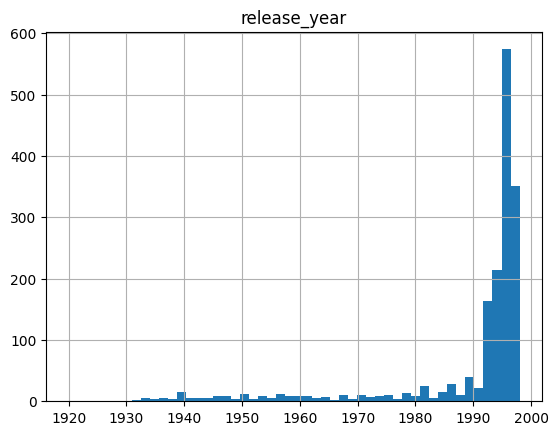

In [5]:
def extract_year(release_date):
    if hasattr(release_date, 'split'):
        components = release_date.split('-')
        if len(components) == 3:
            return int(components[2])
    # Missing value marker
    return 1920


items['release_year'] = items['release_date'].map(extract_year)
items.hist('release_year', bins=50);

Enrich the raw ratings data with the collected items metadata:

In [6]:
all_ratings = pd.merge(items, raw_ratings)

In [7]:
all_ratings.head()

item_id             title release_date  video_release_date  \
0        1  Toy Story (1995)  01-Jan-1995                 NaN   
1        1  Toy Story (1995)  01-Jan-1995                 NaN   
2        1  Toy Story (1995)  01-Jan-1995                 NaN   
3        1  Toy Story (1995)  01-Jan-1995                 NaN   
4        1  Toy Story (1995)  01-Jan-1995                 NaN   

                                            imdb_url  release_year  user_id  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995      308   
1  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995      287   
2  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995      148   
3  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995      280   
4  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995       66   

   rating  timestamp  
0       4  887736532  
1       5  875334088  
2       4  877019411  
3       4  891700426  
4       3  883601324

### Data preprocessing

To understand well the distribution of the data, the following statistics are computed:
- the number of users
- the number of items
- the rating distribution
- the popularity of each movie

In [8]:
min_user_id = all_ratings['user_id'].min()
min_user_id

np.int64(1)

In [9]:
max_user_id = all_ratings['user_id'].max()
max_user_id

np.int64(943)

In [10]:
min_item_id = all_ratings['item_id'].min()
min_item_id

np.int64(1)

In [11]:
max_item_id = all_ratings['item_id'].max()
max_item_id

np.int64(1682)

In [12]:
all_ratings['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Let's do a bit more pandas magic compute the popularity of each movie (number of ratings):

In [13]:
popularity = all_ratings.groupby('item_id').size().reset_index(name='popularity')
items = pd.merge(popularity, items)
items.nlargest(10, 'popularity')

item_id  popularity                          title release_date  \
49        50         583               Star Wars (1977)  01-Jan-1977   
257      258         509                 Contact (1997)  11-Jul-1997   
99       100         508                   Fargo (1996)  14-Feb-1997   
180      181         507      Return of the Jedi (1983)  14-Mar-1997   
293      294         485               Liar Liar (1997)  21-Mar-1997   
285      286         481    English Patient, The (1996)  15-Nov-1996   
287      288         478                  Scream (1996)  20-Dec-1996   
0          1         452               Toy Story (1995)  01-Jan-1995   
299      300         431           Air Force One (1997)  01-Jan-1997   
120      121         429  Independence Day (ID4) (1996)  03-Jul-1996   

     video_release_date                                           imdb_url  \
49                  NaN  http://us.imdb.com/M/title-exact?Star%20Wars%2...   
257                 NaN          http://us.imdb.com/Title?Contact+(1997/I)   
99                  NaN    http://us.imdb.com/M/title-exact?Fargo%20(1996)   
180                 NaN  http://us.imdb.com/M/title-exact?Return%20of%2...   
293                 NaN          http://us.imdb.com/Title?Liar+Liar+(1997)   
285                 NaN  http://us.imdb.com/M/title-exact?English%20Pat...   
287                 NaN   http://us.imdb.com/M/title-exact?Scream%20(1996)   
0                   NaN  http://us.imdb.com/M/title-exact?Toy%20Story%2...   
299                 NaN  http://us.imdb.com/M/title-exact?Air+Force+One...   
120                 NaN  http://us.imdb.com/M/title-exact?Independence%...   

     release_year  
49           1977  
257          1997  
99           1997  
180          1997  
293          1997  
285          1996  
287          1996  
0            1995  
299          1997  
120          1996

In [14]:
items["title"][181]

'GoodFellas (1990)'

In [15]:
indexed_items = items.set_index('item_id')
indexed_items["title"][181]

'Return of the Jedi (1983)'

In [16]:
all_ratings = pd.merge(popularity, all_ratings)
all_ratings.describe()

item_id     popularity  video_release_date   release_year  \
count  100000.000000  100000.000000                 0.0  100000.000000   
mean      425.530130     168.071900                 NaN    1987.950100   
std       330.798356     121.784558                 NaN      14.169558   
min         1.000000       1.000000                 NaN    1920.000000   
25%       175.000000      71.000000                 NaN    1986.000000   
50%       322.000000     145.000000                 NaN    1994.000000   
75%       631.000000     239.000000                 NaN    1996.000000   
max      1682.000000     583.000000                 NaN    1998.000000   

            user_id         rating     timestamp  
count  100000.00000  100000.000000  1.000000e+05  
mean      462.48475       3.529860  8.835289e+08  
std       266.61442       1.125674  5.343856e+06  
min         1.00000       1.000000  8.747247e+08  
25%       254.00000       3.000000  8.794487e+08  
50%       447.00000       4.000000  8.828269e+08  
75%       682.00000       4.000000  8.882600e+08  
max       943.00000       5.000000  8.932866e+08

In [17]:
all_ratings.head()

item_id  popularity             title release_date  video_release_date  \
0        1         452  Toy Story (1995)  01-Jan-1995                 NaN   
1        1         452  Toy Story (1995)  01-Jan-1995                 NaN   
2        1         452  Toy Story (1995)  01-Jan-1995                 NaN   
3        1         452  Toy Story (1995)  01-Jan-1995                 NaN   
4        1         452  Toy Story (1995)  01-Jan-1995                 NaN   

                                            imdb_url  release_year  user_id  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995      308   
1  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995      287   
2  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995      148   
3  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995      280   
4  http://us.imdb.com/M/title-exact?Toy%20Story%2...          1995       66   

   rating  timestamp  
0       4  887736532  
1       5  875334088  
2       4  877019411  
3       4  891700426  
4       3  883601324

Later in the analysis we will assume that this popularity does not come from the ratings themselves but from an external metadata, e.g. box office numbers in the month after the release in movie theaters.

Let's split the enriched data in a train / test split to make it possible to do predictive modeling:

In [18]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

user_id_train = np.array(ratings_train['user_id'])
item_id_train = np.array(ratings_train['item_id'])
rating_train = np.array(ratings_train['rating'])

user_id_test = np.array(ratings_test['user_id'])
item_id_test = np.array(ratings_test['item_id'])
rating_test = np.array(ratings_test['rating'])

# Explicit feedback: supervised ratings prediction

For each pair of (user, item) try to predict the rating the user would give to the item.

This is the classical setup for building recommender systems from offline data with explicit supervision signal. 

In [19]:
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Dot
from keras.models import Model

/home/rth/src/dl-lectures-labs/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [20]:
# For each sample we input the integer identifiers
# of a single user and a single item
class RegressionModel(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding')
        
        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.dot = Dot(axes=1)
        
    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))
        
        y = self.dot([user_vecs, item_vecs])
        return y


model = RegressionModel(64, max_user_id, max_item_id)
model.compile(optimizer="adam", loss='mae')

/home/rth/src/dl-lectures-labs/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
# Useful for debugging the output shape of model
initial_train_preds = model.predict([user_id_train, item_id_train])
initial_train_preds.shape

   1/2500 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step

  15/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step  

  30/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

  45/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

  59/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

  72/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

  84/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

  96/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

 110/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

 123/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

 139/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 153/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 166/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 180/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 194/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 208/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 223/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 237/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 251/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 265/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 279/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 280/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 295/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 309/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 324/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 338/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 342/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

 356/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

 372/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

 387/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

 402/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 417/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 432/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 446/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 457/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 470/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 483/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 497/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 512/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 525/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 539/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 554/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 568/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 582/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 594/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 605/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 619/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 632/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 646/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 660/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 673/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 686/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 699/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 714/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 728/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 742/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 756/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 770/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 785/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 798/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 813/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 826/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 839/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 852/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 864/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 878/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 890/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 904/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 918/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 932/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 947/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 961/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 972/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 982/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 996/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

1010/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1024/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1039/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1054/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1069/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1082/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1096/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1110/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1123/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1135/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1149/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1162/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1177/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1191/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1205/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1219/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1234/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1248/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1263/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1277/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1289/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1301/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1315/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1329/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1330/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1343/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1359/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1371/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1383/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1398/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1411/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1424/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1436/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1451/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1464/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1478/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1493/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1508/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1522/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1537/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1550/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1565/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1581/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1594/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1609/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1624/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1638/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1650/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1664/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1678/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1693/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1707/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1720/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1732/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1745/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1759/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1774/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1788/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1802/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1816/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1830/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1845/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1860/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1875/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1889/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1890/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1904/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1916/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1931/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1946/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1958/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1973/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1987/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2001/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2013/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2026/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2040/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2054/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2065/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2079/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2093/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2105/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2117/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2131/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2145/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2160/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2173/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2188/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2203/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2217/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2231/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2244/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2258/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2270/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2284/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2297/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2309/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2322/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2333/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2345/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2359/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2373/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2388/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2403/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2415/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2428/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2443/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2457/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2472/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2473/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2484/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2497/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step


(80000, 1)

### Model error

Using `initial_train_preds`, compute the model errors:
- mean absolute error
- mean squared error

Converting a pandas Series to numpy array is usually implicit, but you may use `rating_train.values` to do so explicitly. Be sure to monitor the shapes of each object you deal with by using `object.shape`.

In [22]:
# %load solutions/compute_errors.py

### Monitoring runs

Keras enables to monitor various variables during training. 

`history.history` returned by the `model.fit` function is a dictionary
containing the `'loss'` and validation loss `'val_loss'` after each epoch

In [23]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - loss: 3.5627

   6/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 3.5420

  10/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 3.5330

  14/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 3.5341

  19/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 3.5300

  23/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 3.5281

  28/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 3.5266

  32/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 3.5280

  36/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 3.5285

  39/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 3.5290

  42/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 3.5294

  45/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 3.5297

  48/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 3.5298

  52/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 3.5300

  55/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 3.5302

  58/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 3.5305

  63/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 3.5304

  67/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 3.5302

  71/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 3.5302

  74/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 3.5304

  77/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 3.5307

  81/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 3.5311

  85/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 3.5316

  90/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 3.5321

  94/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 3.5325

  99/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 3.5331

 103/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 3.5337

 108/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 3.5342

 113/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 3.5347

 116/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 3.5350

 119/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 3.5352

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 3.5355

 127/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 3.5358

 131/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 3.5361

 135/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 3.5365

 140/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 3.5370

 143/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 3.5372

 148/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 3.5375

 152/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 3.5377

 156/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 3.5379

 159/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 3.5381

 163/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 3.5383

 166/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 3.5384

 169/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 3.5385

 173/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 3.5386

 176/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 3.5386

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 3.5387

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 3.5388

 188/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 3.5390

 192/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 3.5392

 197/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 3.5394

 201/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 3.5394

 205/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 3.5395

 209/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 3.5395

 213/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 3.5395

 218/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 3.5395

 222/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 3.5395

 226/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 3.5395

 230/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 3.5394

 233/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 3.5394

 238/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 3.5393

 242/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 3.5393

 245/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 3.5392

 249/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 3.5391

 253/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 3.5390

 257/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 3.5389

 263/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 3.5387

 267/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 3.5386

 271/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 3.5385

 275/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 3.5384

 279/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 3.5384

 283/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 3.5383

 288/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 3.5382

 292/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 3.5382

 297/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 3.5381

 301/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 3.5381

 306/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5380

 311/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5380

 315/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5380

 318/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5379

 321/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5379

 325/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5379

 328/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5379

 331/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5379

 336/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5379

 340/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5379

 344/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5379

 348/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5378

 351/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5378

 355/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5378

 359/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5377

 364/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5377

 368/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5376

 372/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5376

 375/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5375

 378/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.5375

 381/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.5374

 384/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.5374

 388/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.5373

 392/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.5372

 397/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.5371

 401/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.5371

 407/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.5369

 410/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.5368

 414/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.5367

 418/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.5366

 422/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.5365

 426/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.5364

 431/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.5362

 436/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.5361

 440/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.5360

 444/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3.5358

 448/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5357 

 451/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5356

 456/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5354

 460/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5352

 465/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5350

 468/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5349

 472/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5347

 475/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5346

 479/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5344

 483/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5342

 486/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5340

 491/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5338

 494/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5337

 497/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5335

 500/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5333

 505/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5331

 508/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5329

 512/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5327

 515/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5325

 518/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5323

 522/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3.5321

 526/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3.5318

 529/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3.5316

 533/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3.5314

 536/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3.5312

 541/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3.5308

 544/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3.5306

 548/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3.5303

 553/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3.5298

 557/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3.5295

 560/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3.5293

 564/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3.5289

 568/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3.5285

 573/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3.5281

 578/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3.5276

 581/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3.5273

 584/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3.5270

 588/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5266

 593/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5260

 597/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5256

 601/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5251

 605/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5247

 610/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5241

 613/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5237

 616/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5233

 620/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5228

 623/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5224

 628/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5217

 631/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5213

 634/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5208

 637/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5204

 640/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5199

 644/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5193

 646/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5190

 649/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5185

 653/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5178

 657/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.5172

 662/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 3.5163

 667/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 3.5154

 671/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 3.5146

 675/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 3.5138

 679/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 3.5130

 684/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 3.5120

 689/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 3.5110

 693/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 3.5101

 697/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 3.5092

 702/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 3.5081

 707/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 3.5069

 711/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 3.5060

 714/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 3.5053

 717/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 3.5045

 722/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 3.5032

 727/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.5019

 730/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.5012

 734/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.5001

 737/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.4992

 741/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.4981

 744/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.4973

 748/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.4961

 753/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.4946

 758/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.4931

 763/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.4916

 769/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.4897

 772/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.4887

 776/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.4874

 780/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.4861

 783/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.4851

 788/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.4834

 792/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4820

 795/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4809

 799/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4795

 804/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4777

 808/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4762

 812/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4747

 815/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4735

 819/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4720

 823/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4704

 828/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4685

 832/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4669

 835/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4656

 839/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4640

 843/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4624

 846/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4611

 850/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4594

 853/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4581

 857/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3.4564

 860/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.4551

 864/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.4533

 868/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.4516

 872/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.4498

 877/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.4475

 881/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.4457

 886/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.4433

 890/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.4415

 895/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.4391

 898/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.4377

 903/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.4352

 908/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.4328

 912/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.4309

 916/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.4289

 919/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.4274

 924/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.4249

 928/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.4229

 933/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.4203

 939/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.4173

 944/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.4147

 949/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.4121

 953/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.4100

 958/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.4073

 963/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.4047

 967/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.4025

 972/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.3999

 976/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.3977

 983/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.3939

 987/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.3917

 992/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3889

 997/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3862

1000/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3845

1005/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3817

1009/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3795

1014/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3767

1017/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3750

1022/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3722

1026/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3699

1030/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3676

1034/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3653

1039/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3625

1043/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3602

1047/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3578

1050/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3561

1055/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3532

1059/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3509

1063/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3485

1066/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3468

1069/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3450

1073/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3427

1076/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3409

1080/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3386

1084/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3362

1088/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3339

1092/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3315

1097/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3285

1101/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3261

1105/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3238

1108/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3220

1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3196

1116/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3172

1119/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3154

1122/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3136

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3118

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 2.6379 - val_loss: 1.0501


Epoch 2/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 1.0558

   5/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 1.0478

  11/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 1.0042

  14/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 1.0005

  17/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 1.0021

  21/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 1.0042

  25/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 1.0047

  29/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 1.0049

  33/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 1.0050

  36/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 1.0051

  40/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 1.0049

  45/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 1.0050

  48/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 1.0048

  53/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 1.0040

  58/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 1.0030

  63/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 1.0021

  67/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 1.0014

  71/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 1.0007

  76/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 1.0000

  81/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.9993

  85/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.9987

  88/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.9983

  92/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.9977

  95/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.9973

  99/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.9967

 103/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.9961

 106/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.9956

 109/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.9951

 113/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.9943

 118/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.9933

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.9923

 127/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.9915

 130/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.9909

 133/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.9904

 136/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.9899

 140/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.9891

 143/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.9886

 148/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.9877

 152/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.9871

 157/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.9863

 161/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.9857

 167/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.9849

 172/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.9843

 177/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.9838

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.9834

 184/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.9829

 188/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.9825

 192/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.9821

 197/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.9815

 202/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.9810

 206/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.9807

 211/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.9802

 214/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.9799

 218/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.9795

 222/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.9791

 226/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.9787

 230/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.9782

 234/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.9778

 238/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.9773

 241/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.9770

 243/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.9768

 247/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.9763

 251/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.9759

 255/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.9755

 259/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.9750

 264/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.9745

 268/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.9740

 273/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.9734

 278/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.9728

 282/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.9723

 287/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.9717

 292/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.9711

 296/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.9707

 300/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.9702

 305/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.9696

 308/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.9692

 312/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.9688

 316/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.9683

 320/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.9679

 324/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.9674

 329/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.9669

 334/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.9663

 338/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.9659

 342/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.9655

 347/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.9649

 353/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.9643

 358/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.9638

 361/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.9634

 366/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.9629

 370/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.9625

 373/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.9622

 377/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.9618

 381/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.9614

 385/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.9610

 389/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.9606

 394/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.9601

 398/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.9597

 400/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.9595

 404/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.9592

 409/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9587 

 412/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9584

 416/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9580

 419/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9577

 422/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9574

 425/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9572

 429/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9568

 433/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9564

 436/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9562

 440/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9558

 445/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9554

 449/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9550

 453/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9547

 458/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9542

 462/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9538

 467/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9534

 470/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9531

 474/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9527

 479/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.9523

 483/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.9519

 488/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.9515

 492/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.9511

 495/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.9508

 498/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.9506

 502/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.9502

 507/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.9498

 510/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.9495

 514/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.9492

 519/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.9487

 524/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.9483

 528/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.9480

 531/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.9477

 536/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.9473

 541/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.9469

 544/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.9466

 549/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.9462

 553/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9459

 558/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9455

 563/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9450

 567/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9447

 572/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9443

 575/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9441

 580/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9437

 584/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9433

 587/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9431

 592/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9427

 596/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9424

 600/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9421

 604/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9418

 609/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9414

 613/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9411

 616/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9409

 618/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9407

 621/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9405

 625/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.9402

 629/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9398

 633/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9395

 638/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9392

 642/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9389

 645/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9386

 648/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9384

 652/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9381

 656/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9378

 660/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9375

 665/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9371

 669/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9368

 673/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9366

 677/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9363

 681/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9360

 684/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9358

 688/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9355

 691/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9352

 697/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.9348

 701/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9345

 704/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9343

 709/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9339

 713/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9337

 717/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9334

 721/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9331

 725/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9328

 728/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9326

 731/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9324

 735/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9321

 738/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9319

 742/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9316

 746/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9313

 749/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9311

 753/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9308

 759/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9304

 762/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9302

 765/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9300

 768/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.9298

 773/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9294

 777/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9292

 782/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9288

 786/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9285

 790/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9283

 793/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9281

 798/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9277

 802/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9275

 807/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9271

 812/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9268

 817/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9265

 819/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9263

 822/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9261

 826/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9259

 829/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9257

 832/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9255

 834/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9254

 837/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9252

 841/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9249

 844/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.9247

 848/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9244

 851/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9243

 854/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9241

 857/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9239

 862/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9235

 866/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9233

 870/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9230

 874/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9228

 877/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9226

 880/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9224

 883/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9222

 887/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9220

 891/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9217

 894/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9215

 897/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9213

 901/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9211

 904/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9209

 907/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9207

 911/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9205

 916/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9202

 920/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9199

 924/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9197

 928/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9194

 932/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9192

 936/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9189

 941/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9187

 944/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9185

 948/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9182

 953/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9179

 957/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9177

 962/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9174

 966/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9172

 971/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9169

 975/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9167

 980/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9164

 986/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9160

 989/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9159

 992/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9157

 995/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9155

 999/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9153

1003/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9151

1007/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9148

1011/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9146

1016/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9143

1020/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9141

1025/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9138

1028/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9137

1032/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9135

1035/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9133

1040/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9130

1043/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9129

1047/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9127

1052/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9124

1056/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9122

1061/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9119

1065/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9117

1068/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9115

1071/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9114

1075/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9112

1079/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9109

1082/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9108

1086/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9106

1091/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9103

1096/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9101

1100/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9099

1103/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9097

1107/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9095

1111/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9093

1115/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9091

1118/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9089

1120/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9088

1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9086

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.8512 - val_loss: 0.7966


Epoch 3/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 0.7962

   5/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.7572

  10/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.7473

  13/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.7463

  18/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.7457

  22/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.7442

  25/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.7439

  28/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.7432

  32/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.7424

  36/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.7415

  40/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.7412

  44/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.7411

  47/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.7413

  52/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.7417

  55/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.7418

  59/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.7419

  64/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.7420

  69/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7421

  74/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7422

  78/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7424

  81/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7425

  85/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7427

  89/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7428

  92/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7430

  96/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7433

 100/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7436

 103/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7439

 107/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7441

 110/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7443

 113/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7444

 116/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.7445

 119/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.7447

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.7449

 129/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.7452

 134/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7455

 137/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7456

 142/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7458

 147/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7459

 151/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7460

 155/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7461

 160/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7462

 164/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7462

 168/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7462

 173/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7462

 177/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7462

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7462

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7462

 186/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7462

 189/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7462

 193/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7462

 197/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7463

 201/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7463

 206/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7464

 209/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7464

 214/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7465

 218/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7465

 222/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7465

 226/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7466

 230/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7466

 235/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7467

 239/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7467

 243/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7468

 248/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7468

 251/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7468

 256/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7468

 259/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7468

 263/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7469

 267/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7469

 271/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7469

 275/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7469

 280/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7469

 283/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7470

 287/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7470

 291/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7470

 296/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7471

 300/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7471

 303/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7472

 307/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7472

 311/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7473

 315/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7474

 318/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7474

 324/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7475

 327/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7476

 331/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7476

 334/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7477

 340/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7478

 345/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7479

 347/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7479

 350/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7480

 354/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7480

 358/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.7481

 363/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7482

 367/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7483

 372/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7483

 376/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7484

 380/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7485

 385/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7485

 389/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7486

 393/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7487

 396/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7487

 401/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7488

 405/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7488

 408/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7489

 412/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7489

 417/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7490

 422/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7491

 426/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7491

 429/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7491

 432/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.7492

 436/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7492 

 441/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.7493

 444/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7493

 448/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7493

 452/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7494

 456/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7494

 459/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7495

 462/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7495

 465/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7495

 468/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7496

 472/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7496

 477/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7496

 480/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7497

 483/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7497

 486/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7497

 490/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7498

 495/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7498

 500/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7498

 504/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7499

 509/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7499

 513/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7499

 516/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7499

 519/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7500

 523/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7500

 526/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7500

 530/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7501

 533/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7501

 535/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7501

 540/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7501

 543/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7502

 547/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7502

 551/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7502

 555/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7503

 560/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7503

 565/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7503

 569/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7504

 573/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7504

 575/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7504

 578/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7504

 582/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7505

 586/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7505

 589/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7505

 594/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7505

 598/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7506

 602/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7506

 606/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7506

 610/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7506

 615/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7507

 619/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7507

 623/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7507

 626/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7507

 630/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7507

 634/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7508

 638/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7508

 643/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7508

 647/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7508

 652/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7509

 657/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7509

 662/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7509

 667/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7509

 672/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7510

 677/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7510

 681/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7510

 686/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7510

 691/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7510

 696/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7511

 700/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7511

 705/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7511

 709/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7511

 713/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7511

 718/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7512

 721/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7512

 724/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7512

 727/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7512

 732/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7512

 737/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7512

 740/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7512

 745/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7513

 749/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7513

 753/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7513

 757/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7513

 762/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7513

 767/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7514

 771/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7514

 774/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7514

 778/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7514

 782/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7514

 786/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7514

 790/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7514

 793/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7515

 797/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7515

 803/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7515

 807/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7515

 811/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7515

 815/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7515

 820/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7515

 824/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7516

 829/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7516

 834/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7516

 838/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7516

 841/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7516

 845/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7516

 850/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7516

 853/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7516

 857/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7517

 862/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7517

 865/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7517

 868/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7517

 871/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7517

 875/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7517

 879/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7517

 882/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7517

 887/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7517

 892/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7517

 896/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7517

 900/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7518

 905/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7518

 908/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7518

 911/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7518

 915/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7518

 920/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7518

 925/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7518

 930/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7518

 934/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7518

 937/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7518

 940/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7519

 944/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7519

 947/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7519

 951/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7519

 955/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7519

 960/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7519

 964/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7519

 968/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7519

 971/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7519

 974/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7519

 978/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7519

 983/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7519

 987/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7519

 992/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7519

 994/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7519

 997/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7519

1000/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7519

1003/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7519

1008/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7519

1011/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7520

1015/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7520

1019/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7520

1022/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7520

1025/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7520

1029/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7520

1033/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7520

1037/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7520

1040/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7520

1044/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7520

1047/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7520

1051/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7520

1055/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7520

1061/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7520

1064/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7520

1067/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7520

1071/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7520

1075/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7520

1080/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7520

1084/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7520

1087/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7520

1091/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7520

1096/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7520

1101/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7520

1105/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7520

1110/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7520

1115/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7520

1120/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7520

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7520

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.7528 - val_loss: 0.7673


Epoch 4/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.7861

   7/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.7299

  12/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.7250

  16/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.7242

  20/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.7247

  24/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.7245

  29/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.7234

  33/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.7227

  38/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.7218

  42/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.7211

  45/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.7205

  48/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.7198

  51/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.7192

  55/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.7186

  58/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.7181

  62/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.7174

  65/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.7169

  69/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.7161

  73/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.7156

  77/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.7152

  81/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.7148

  86/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.7146

  91/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7143

  95/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7140

 100/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7138

 104/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7136

 110/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7133

 114/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7131

 117/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7129

 121/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7128

 126/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7125

 130/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7124

 134/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.7123

 138/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7122

 142/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7121

 146/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7120

 151/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7119

 154/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7119

 157/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7119

 160/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7119

 165/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7119

 171/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7119

 176/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7119

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7120

 184/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7120

 187/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7120

 191/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7120

 196/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7120

 200/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7120

 204/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7120

 208/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.7120

 212/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7120

 216/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7120

 220/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7120

 225/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7120

 229/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7120

 233/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7120

 237/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7120

 241/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7120

 245/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7121

 250/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7121

 255/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7121

 258/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7121

 261/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7121

 264/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7122

 268/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7122

 272/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7123

 276/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7123

 280/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.7123

 285/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7124

 289/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7124

 293/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7125

 298/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7125

 301/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7125

 304/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7126

 307/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7126

 311/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7126

 315/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7127

 319/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7127

 322/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7127

 325/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7127

 328/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7127

 333/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7128

 339/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7128

 343/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7128

 348/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7128

 352/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7128

 355/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.7129

 359/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7129

 363/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7129

 367/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7129

 370/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7129

 375/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7130

 379/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7130

 382/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7130

 386/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7131

 390/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7131

 393/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7131

 396/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7131

 400/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7131

 404/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7131

 409/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7132

 414/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7132

 417/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.7132

 420/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.7133

 423/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.7133

 426/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.7133

 430/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.7133

 433/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.7134

 437/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.7134

 442/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7134 

 445/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7135

 449/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7135

 452/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7135

 455/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7136

 459/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7136

 464/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7136

 469/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7137

 472/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7137

 477/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7138

 482/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7138

 486/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7139

 490/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7139

 495/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7139

 499/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7140

 503/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.7140

 507/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7141

 510/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7141

 515/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7141

 518/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7142

 523/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7142

 526/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7143

 529/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7143

 533/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7143

 537/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7144

 541/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7144

 545/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7145

 550/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7145

 553/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7146

 557/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7146

 562/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7147

 566/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7147

 570/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7148

 574/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.7148

 579/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7149

 583/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7149

 587/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7150

 592/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7150

 595/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7151

 598/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7151

 601/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7151

 604/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7152

 607/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7152

 611/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7152

 614/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7153

 617/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7153

 623/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7154

 626/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7154

 630/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7155

 633/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7155

 638/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7156

 641/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7156

 646/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7157

 649/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7157

 653/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7157

 657/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7158

 660/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7158

 665/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7159

 668/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7159

 671/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7159

 674/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7160

 679/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7160

 683/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7161

 688/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7161

 693/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7162

 696/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7162

 701/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7162

 706/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7163

 710/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7163

 714/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.7164

 719/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7164

 724/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7165

 728/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7165

 731/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7166

 734/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7166

 737/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7166

 740/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7166

 743/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7167

 746/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7167

 749/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7167

 753/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7168

 756/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7168

 759/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7168

 763/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7169

 767/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7169

 772/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7169

 776/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7170

 781/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.7170

 786/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7171

 790/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7171

 793/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7171

 796/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7171

 801/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7172

 804/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7172

 807/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7172

 811/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7172

 815/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7173

 819/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7173

 823/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7173

 828/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7174

 832/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7174

 835/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7174

 838/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7174

 841/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7174

 845/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7175

 850/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.7175

 855/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7175

 858/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7175

 862/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7176

 866/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7176

 870/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7176

 874/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7176

 878/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7176

 881/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7177

 887/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7177

 891/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7177

 894/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7177

 899/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7178

 903/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7178

 908/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7178

 912/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7179

 917/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7179

 920/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.7179

 925/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7179

 930/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7180

 934/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7180

 937/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7180

 941/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7181

 944/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7181

 949/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7181

 954/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7181

 957/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7182

 962/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7182

 967/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7182

 971/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7183

 975/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7183

 979/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7183

 983/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7183

 988/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7184

 993/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7184

 997/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7184

1001/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7184

1004/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7184

1007/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7185

1010/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7185

1013/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7185

1016/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7185

1019/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7185

1023/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7186

1027/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7186

1032/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7186

1037/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7186

1041/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7187

1046/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7187

1050/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7187

1055/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7187

1059/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7187

1064/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7188

1068/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7188

1071/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7188

1074/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7188

1077/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7188

1082/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7189

1086/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7189

1090/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7189

1093/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7189

1097/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7189

1102/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7190

1105/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7190

1110/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7190

1113/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7190

1118/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7190

1122/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7190

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.7241 - val_loss: 0.7539


Epoch 5/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.6820

   5/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.6766

   9/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.6784

  13/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.6800

  18/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6799

  21/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.6802

  24/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.6814

  27/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.6833

  30/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.6849

  33/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.6860

  36/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.6868

  40/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.6875

  46/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.6880

  50/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.6881

  55/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 0.6883

  59/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 0.6883

  63/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.6883

  67/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.6883

  72/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6885

  76/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6887

  80/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6889

  84/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6891

  87/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6892

  92/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6893

  95/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6894

  99/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6895

 102/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6895

 105/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6896

 109/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6897

 112/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6897

 115/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6898

 119/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6898

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6899

 127/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6900

 131/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6900

 134/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6901

 137/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6901

 141/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6902

 146/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6904

 151/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6906

 154/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6907

 157/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6909

 161/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6911

 165/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6913

 168/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6914

 171/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6915

 174/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6916

 178/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6918

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6919

 186/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6919

 191/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6920

 195/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6920

 199/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6920

 203/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6921

 207/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6921

 211/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6921

 215/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6922

 219/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6923

 224/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6923

 229/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6923

 234/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6923

 239/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6924

 242/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6924

 247/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6924

 252/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6924

 256/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6924

 259/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6924

 264/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6925

 269/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6925

 274/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6925

 278/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6925

 282/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6925

 287/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6926

 291/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6926

 296/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6926

 300/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6927

 304/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6927

 307/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6927

 311/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6927

 316/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6928

 319/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6928

 324/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6928

 328/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6928

 332/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6928

 336/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6928

 340/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6928

 345/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6928

 348/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6928

 352/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6928

 356/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6928

 360/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6928

 363/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6928

 367/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6928

 371/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6928

 375/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6928

 379/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6928

 384/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6928

 389/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6929

 392/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6929

 395/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6929

 398/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6929

 401/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6929

 404/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6930

 408/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6930

 412/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6930

 416/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6931

 420/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6931

 423/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6931

 427/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6932

 430/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6932

 435/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6932

 438/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.6933 

 442/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.6933

 447/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6933

 451/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6934

 455/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6934

 458/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.6934

 463/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6935

 468/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6935

 472/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6936

 477/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6936

 482/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6937

 486/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6937

 492/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6937

 496/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6938

 500/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6938

 504/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6939

 509/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6939

 513/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6939

 516/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6939

 521/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6940

 526/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6940

 531/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6941

 534/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6941

 538/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6941

 542/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6942

 545/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6942

 548/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6942

 552/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6943

 556/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6943

 559/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6943

 562/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6943

 566/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6944

 569/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6944

 572/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6944

 577/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6945

 581/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6945

 586/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6945

 591/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6946

 595/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6946

 599/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6946

 604/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6947

 608/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6947

 612/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6947

 616/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6948

 621/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6948

 626/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6948

 630/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6948

 633/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6949

 637/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6949

 640/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6949

 643/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6949

 647/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6949

 652/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6950

 656/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6950

 660/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6950

 664/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6950

 668/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6951

 670/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6951

 673/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6951

 676/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6951

 680/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6951

 684/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6952

 687/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6952

 691/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6952

 694/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6952

 697/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6952

 699/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6953

 702/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6953

 706/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6953

 710/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6953

 715/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6954

 720/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6954

 723/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6954

 727/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6955

 731/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6955

 733/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6955

 737/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6955

 741/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6955

 747/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6956

 751/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6956

 756/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6956

 760/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6957

 764/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6957

 769/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6957

 774/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6957

 778/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6958

 781/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6958

 786/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6958

 789/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6958

 793/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6958

 796/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6958

 800/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6959

 803/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6959

 806/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6959

 809/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6959

 814/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6959

 817/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6959

 822/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6960

 827/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6960

 832/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6960

 836/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6960

 840/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6960

 844/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6961

 847/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6961

 851/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6961

 854/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6961

 859/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6961

 864/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6961

 867/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6961

 872/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6962

 875/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6962

 879/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6962

 884/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6962

 888/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6962

 891/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6962

 894/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6962

 899/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6962

 902/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6963

 907/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6963

 912/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6963

 917/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6963

 922/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6963

 927/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6963

 931/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6964

 936/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6964

 941/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6964

 944/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6964

 947/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6964

 951/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6964

 954/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6965

 958/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6965

 962/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6965

 967/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6965

 971/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6965

 976/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6965

 980/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6966

 985/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6966

 989/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6966

 993/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6966

 997/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6966

1001/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6966

1004/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6966

1009/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6967

1014/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6967

1017/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6967

1021/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6967

1026/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6967

1031/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6967

1035/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6968

1038/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6968

1043/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6968

1048/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6968

1053/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6968

1057/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6968

1061/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6968

1065/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6969

1069/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6969

1073/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6969

1077/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6969

1081/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6969

1085/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6969

1087/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6969

1091/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6969

1094/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6970

1097/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6970

1101/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6970

1104/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6970

1109/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6970

1113/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6970

1118/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6970

1122/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6971

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.7008 - val_loss: 0.7471


Epoch 6/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.5864

   6/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.6007

  10/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.6108

  14/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.6196

  18/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6266

  22/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6320

  26/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6368

  29/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6402

  34/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6445

  37/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6460

  41/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6477

  45/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6498

  49/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6516

  52/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6529

  56/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6543

  61/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6557

  64/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6563

  68/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6569

  72/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.6575

  77/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6580

  82/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6584

  86/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6588

  90/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6592

  94/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6595

  97/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6597

 100/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6598

 103/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6600

 108/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6601

 112/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6603

 116/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6605

 120/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6607

 124/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6609

 128/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6612

 132/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6613

 136/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6615

 140/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6617

 144/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6619

 147/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6621

 152/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6623

 156/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6624

 160/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6626

 166/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6628

 169/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6629

 174/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6632

 177/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6633

 181/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6634

 185/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6636

 189/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6637

 193/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6638

 196/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6639

 201/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6641

 205/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6642

 208/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6643

 211/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6644

 215/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6645

 218/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6646

 222/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6647

 226/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6649

 229/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6650

 233/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6651

 236/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6652

 240/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6654

 243/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6655

 248/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6656

 253/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6657

 256/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6658

 259/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6659

 262/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6660

 265/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6661

 269/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6662

 274/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6663

 279/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6664

 284/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6666

 287/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6666

 292/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6668

 297/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6669

 301/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6670

 305/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6671

 310/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.6673

 313/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.6674

 318/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.6675

 322/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.6676

 324/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.6676

 327/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.6677

 331/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.6678

 335/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.6679

 340/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.6680

 344/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.6681

 348/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.6682

 354/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.6683

 357/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.6684

 361/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.6685

 366/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.6686

 369/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.6687

 374/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6688

 378/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6688

 383/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6689

 387/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6690

 392/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6691

 397/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6691

 400/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6692

 403/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6692

 406/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6693

 410/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6693

 414/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6694

 419/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6694

 423/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6695

 426/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6695

 430/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6696

 435/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6697 

 439/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6697

 443/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6698

 447/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6698

 450/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6698

 454/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6699

 458/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6699

 463/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6700

 468/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6700

 472/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6701

 475/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6701

 478/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6702

 483/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6702

 488/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6703

 494/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6704

 499/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6704

 503/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6705

 507/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6705

 511/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6706

 515/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6706

 519/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6706

 525/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6707

 529/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6708

 533/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6708

 537/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6708

 542/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6709

 546/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6709

 549/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6710

 553/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6710

 556/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6710

 560/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6711

 563/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6711

 566/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6711

 569/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6712

 572/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6712

 575/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6712

 579/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6713

 585/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6713

 588/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6714

 592/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6714

 598/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6715

 603/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6715

 608/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6716

 612/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6716

 615/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6717

 619/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6717

 623/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6718

 627/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6718

 632/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6719

 637/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6719

 641/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6719

 645/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6720

 648/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6720

 653/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6721

 657/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6721

 662/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6721

 666/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6722

 671/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6722

 675/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6723

 678/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6723

 681/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6723

 684/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6724

 689/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6724

 692/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6724

 695/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6725

 699/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6725

 703/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6725

 707/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6726

 710/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6726

 714/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6726

 717/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6726

 721/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6727

 725/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6727

 730/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6727

 734/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6727

 738/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6728

 743/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6728

 747/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6728

 750/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6729

 753/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6729

 758/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6729

 761/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6729

 766/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6730

 771/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6730

 774/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6730

 778/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6730

 782/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6731

 786/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6731

 789/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6731

 792/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6731

 795/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6731

 798/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6732

 802/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6732

 806/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6732

 810/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6733

 813/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6733

 816/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6733

 819/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6733

 823/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6733

 828/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6734

 833/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6734

 837/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6734

 842/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6735

 847/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6735

 852/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6735

 854/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6735

 857/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6736

 861/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6736

 864/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6736

 868/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6736

 872/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6736

 876/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6737

 879/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6737

 883/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6737

 886/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6737

 890/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6737

 895/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6737

 898/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6738

 902/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6738

 906/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6738

 909/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6738

 913/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6738

 917/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6738

 920/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6738

 924/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6739

 928/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6739

 933/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6739

 937/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6739

 940/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6739

 945/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6739

 948/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6739

 952/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6740

 956/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6740

 961/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6740

 965/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6740

 968/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6740

 972/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6740

 977/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6741

 980/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6741

 984/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6741

 988/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6741

 992/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6741

 997/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6741

1001/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6741

1005/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6742

1009/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6742

1014/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6742

1017/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6742

1020/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6742

1024/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6742

1029/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6742

1032/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6743

1035/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6743

1040/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6743

1045/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6743

1049/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6743

1052/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6743

1058/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6743

1061/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6744

1065/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6744

1069/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6744

1072/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6744

1077/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6744

1080/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6744

1083/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6744

1086/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6744

1090/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6745

1093/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6745

1096/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6745

1099/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6745

1102/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6745

1105/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6745

1108/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6745

1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6745

1115/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6745

1119/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6746

1122/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6746

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.6787 - val_loss: 0.7443


Epoch 7/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.5989

   6/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.6398

  11/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.6361

  15/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.6339

  20/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.6353

  24/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.6352

  29/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.6349

  34/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.6355

  38/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.6355

  42/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.6353

  44/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6352

  48/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6353

  51/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6355

  56/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6360

  58/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6362

  62/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6365

  67/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6368

  70/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6369

  74/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6371

  78/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6371

  82/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6371

  87/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6371

  90/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6371

  93/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6372

  98/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6372

 101/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6373

 107/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6373

 112/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6373

 115/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6374

 119/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6375

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6376

 126/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6376

 130/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6377

 134/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6378

 138/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6379

 142/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6380

 145/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6381

 148/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6382

 152/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6383

 156/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6383

 160/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6384

 165/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6385

 169/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.6386

 173/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6387

 177/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6388

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6388

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6388

 186/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6389

 191/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6389

 194/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6390

 199/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6391

 203/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6391

 207/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6392

 211/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6393

 215/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6393

 219/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6394

 223/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6395

 227/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6396

 232/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6397

 235/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6398

 238/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6399

 240/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6399

 243/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6400

 247/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6401

 251/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6402

 255/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6403

 260/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6404

 263/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.6404

 267/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6405

 270/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6406

 274/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6407

 278/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6408

 282/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.6409

 284/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.6409

 288/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.6410

 291/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.6411

 295/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.6412

 299/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.6413

 303/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.6414

 307/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.6415

 312/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.6417

 317/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.6418

 320/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.6419

 324/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.6420

 329/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.6421

 334/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.6422

 338/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.6423

 342/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.6424

 346/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.6425

 350/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.6426

 355/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.6427

 358/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.6427

 362/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.6428

 365/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.6429

 368/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.6430

 371/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.6430

 374/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.6431

 378/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.6432

 382/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.6433

 385/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.6433

 389/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.6434

 392/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.6434

 397/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.6435

 401/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.6436

 406/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.6437

 410/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.6437

 414/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.6438

 418/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.6438

 421/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.6439

 424/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.6439

 427/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.6439

 431/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.6440

 435/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.6441

 440/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.6441

 445/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.6442

 449/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.6443

 454/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6444

 458/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6444

 462/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6445

 466/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6446

 470/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6446

 474/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6447

 477/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.6447

 481/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.6448 

 486/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.6449

 490/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.6449

 493/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.6450

 496/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.6450

 498/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.6450

 501/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.6451

 504/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.6451

 508/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.6452

 511/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.6452

 514/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.6453

 518/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.6453

 522/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.6454

 526/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.6454

 529/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.6455

 533/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.6455

 536/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.6456

 540/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.6456

 544/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.6457

 549/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.6458

 552/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.6458

 556/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.6459

 561/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.6459

 565/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.6460

 568/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.6460

 573/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.6461

 577/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.6462

 581/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.6462

 584/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.6463

 589/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.6464

 592/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.6464

 596/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.6465

 600/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.6465

 604/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.6466

 608/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.6467

 613/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.6467

 619/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6468

 621/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.6469

 625/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.6469

 629/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.6470

 634/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6470

 639/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6471

 642/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6472

 647/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6472

 652/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6473

 655/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6473

 658/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6474

 661/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6474

 665/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6475

 669/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6475

 672/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6476

 677/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6476

 682/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6477

 686/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6477

 690/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6478

 693/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6478

 696/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6478

 699/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6479

 702/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6479

 707/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6480

 711/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6480

 716/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6481

 720/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6481

 724/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6481

 728/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6482

 731/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6482

 735/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6482

 740/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6483

 744/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6483

 748/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6484

 753/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6484

 757/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6485

 760/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6485

 764/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6485

 767/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6485

 771/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6486

 776/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6486

 780/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6487

 784/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6487

 788/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6487

 792/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6488

 797/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6488

 801/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6488

 805/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6489

 809/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6489

 814/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6490

 818/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6490

 823/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6490

 828/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6491

 831/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6491

 834/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6491

 838/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6492

 843/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6492

 847/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6492

 851/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6493

 855/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6493

 859/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6493

 862/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6494

 865/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6494

 868/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6494

 873/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6495

 878/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6495

 881/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6495

 886/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6496

 890/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6496

 894/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6496

 897/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6497

 900/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6497

 904/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6497

 909/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6498

 913/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6498

 918/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6498

 921/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6499

 926/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6499

 931/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6499

 935/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6500

 940/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6500

 945/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6501

 950/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6501

 953/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6501

 957/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6502

 960/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6502

 963/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6502

 966/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6502

 969/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6502

 972/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6503

 977/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6503

 980/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6503

 984/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6504

 988/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6504

 992/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6504

 997/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6505

 999/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6505

1004/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6505

1008/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6505

1011/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6506

1017/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6506

1021/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6506

1026/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6507

1030/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6507

1034/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6507

1037/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6508

1040/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6508

1043/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6508

1048/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6508

1053/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6509

1058/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6509

1062/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6509

1067/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6510

1071/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6510

1075/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6510

1079/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6510

1084/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6511

1088/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6511

1092/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6511

1095/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6511

1098/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6512

1100/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6512

1104/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6512

1107/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6512

1111/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6512

1116/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6513

1121/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6513

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6513

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.6580 - val_loss: 0.7410


Epoch 8/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.6480

   6/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.6455

  10/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6420

  13/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.6423

  18/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6448

  21/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6463

  25/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6479

  29/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6488

  33/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6491

  36/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.6492

  41/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6490

  45/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6485

  50/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.6476

  55/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6468

  59/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6462

  64/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6453

  69/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.6447

  73/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.6444

  77/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6441

  80/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6439

  84/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6436

  88/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6433

  92/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6430

  98/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6425

 101/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6423

 104/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6421

 109/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6417

 113/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6414

 118/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6410

 122/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.6407

 127/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6403

 132/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6399

 136/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6396

 141/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6392

 146/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6389

 149/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6387

 154/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6384

 157/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6383

 162/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6380

 166/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6378

 169/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6377

 173/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6375

 178/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6373

 181/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6372

 184/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6371

 188/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6369

 192/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6368

 197/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6367

 202/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.6365

 207/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6364

 211/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6363

 214/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6362

 219/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6361

 222/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6361

 225/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6361

 229/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6360

 233/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6360

 237/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6359

 240/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6359

 245/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6358

 251/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6357

 255/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6357

 259/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6356

 263/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6356

 267/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6355

 272/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6355

 276/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6355

 279/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.6355

 283/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6355

 287/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6355

 290/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6355

 293/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6355

 298/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6355

 303/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6354

 307/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6354

 312/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6354

 316/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6354

 321/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6354

 325/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6354

 329/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6354

 333/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6354

 337/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6353

 342/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6353

 347/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.6353

 351/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6353

 355/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6352

 359/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6352

 362/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6352

 366/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6352

 370/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6352

 373/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6351

 377/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6351

 382/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6351

 385/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6351

 389/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6351

 395/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6351

 399/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6351

 403/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6351

 406/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6351

 409/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6351

 412/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6351

 416/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6351

 421/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6351

 425/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6351

 429/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6351 

 434/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6351

 438/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6351

 442/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6351

 445/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6351

 450/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6351

 454/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6351

 457/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6351

 461/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6351

 466/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6351

 469/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6351

 474/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6351

 478/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6351

 483/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6351

 487/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6351

 491/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6351

 494/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6351

 498/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6351

 501/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6351

 505/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6351

 509/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6351

 512/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6351

 517/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6351

 522/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6351

 525/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6351

 529/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6351

 532/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6351

 536/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6351

 540/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6352

 545/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6352

 550/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6352

 555/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6352

 559/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6352

 565/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6352

 570/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6352

 573/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6352

 576/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6352

 579/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6352

 584/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6352

 587/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6353

 591/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6353

 596/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6353

 600/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6353

 605/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6353

 609/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6353

 613/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6353

 618/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6353

 622/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6354

 626/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6354

 631/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6354

 635/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6354

 639/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6354

 641/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6354

 644/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6354

 648/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6354

 651/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6354

 655/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6355

 659/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6355

 662/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6355

 666/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6355

 670/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6355

 674/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6355

 678/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6355

 682/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6355

 687/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6355

 691/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6355

 695/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6356

 700/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6356

 704/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6356

 707/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6356

 710/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6356

 715/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6356

 720/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6356

 725/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6356

 730/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6356

 733/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6356

 737/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6356

 742/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6356

 746/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6356

 750/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6356

 754/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6356

 757/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6356

 760/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6356

 763/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6356

 767/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6356

 771/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6357

 775/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6357

 779/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6357

 782/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6357

 787/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6357

 792/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6357

 795/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6357

 799/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6357

 803/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6357

 806/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6357

 811/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6357

 814/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6357

 818/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6357

 823/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6357

 827/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6357

 830/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6357

 834/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6357

 838/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6357

 843/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6357

 846/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6357

 849/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6357

 852/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6357

 856/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6357

 861/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6357

 865/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6357

 869/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6357

 872/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6357

 876/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6357

 881/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6357

 885/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6357

 889/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6357

 892/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6357

 895/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6357

 899/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6357

 903/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6357

 906/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6357

 910/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6357

 914/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6357

 919/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6357

 923/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6357

 927/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6357

 931/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6357

 936/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6358

 941/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6358

 946/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6358

 951/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6358

 955/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6358

 958/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6358

 961/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6358

 965/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6358

 968/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6358

 972/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6358

 975/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6358

 981/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6358

 984/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6358

 987/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6358

 991/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6358

 994/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6358

 998/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6358

1002/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6358

1007/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6358

1012/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6358

1017/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6358

1021/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6358

1025/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6358

1029/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6358

1032/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6358

1038/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6358

1043/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6358

1047/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6358

1050/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6358

1054/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6358

1058/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6358

1062/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6358

1066/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6358

1070/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6358

1075/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6359

1080/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6359

1085/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6359

1089/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6359

1092/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6359

1098/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6359

1102/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6359

1105/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6359

1108/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6359

1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6359

1115/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6359

1118/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6359

1122/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6359

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6359

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.6381 - val_loss: 0.7410


Epoch 9/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - loss: 0.6208

   5/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.5836

  10/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.5789

  13/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.5815

  15/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.5818

  18/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.5810

  23/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.5795

  27/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.5791

  32/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5800

  36/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5813

  40/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.5825

  44/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.5834

  47/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5840

  52/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.5848

  57/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.5853

  63/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.5856

  67/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.5859

  70/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.5860

  74/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.5863

  79/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.5867

  82/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.5869

  85/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.5873

  89/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.5876

  92/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.5879

  96/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.5882

  99/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5884

 103/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5886

 107/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5889

 112/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5893

 117/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5896

 121/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5899

 125/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5902

 129/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5904

 132/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5906

 137/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5909

 140/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5911

 145/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.5913

 149/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.5916

 153/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.5919

 157/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5922

 161/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.5925

 164/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5927

 168/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5929

 172/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5931

 176/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.5933

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.5935

 184/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5937

 188/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5939

 191/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5941

 194/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5942

 198/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5944

 202/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5946

 206/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5947

 210/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5949

 214/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5950

 218/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5951

 223/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5953

 228/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5954

 233/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.5956

 238/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5957

 241/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.5958

 246/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.5959

 251/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5960

 254/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.5961

 259/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5962

 263/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5963

 268/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5964

 273/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5966

 276/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5967

 280/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5968

 285/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5969

 289/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5970

 292/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5971

 296/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5972

 300/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5974

 304/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5975

 308/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5976

 311/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5977

 315/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5978

 319/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5979

 322/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5980

 327/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5982

 331/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5983

 336/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5984

 340/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5985

 344/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5986

 348/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5987

 353/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5988

 356/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5989

 360/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5990

 363/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5991

 367/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5992

 372/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5994

 377/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5995

 382/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5997

 386/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5998

 390/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5999

 394/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6000

 398/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6001

 402/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6002

 404/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6003

 407/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6003

 411/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6004

 415/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6005

 420/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6006

 425/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6008

 428/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.6008

 433/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6009 

 436/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6010

 440/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6011

 445/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6012

 448/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6013

 452/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6013

 457/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6014

 461/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6015

 466/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6016

 470/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6017

 474/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6018

 477/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6018

 481/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6019

 484/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6020

 488/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6020

 492/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6021

 496/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6022

 499/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.6022

 503/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6023

 507/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6024

 511/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6024

 517/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6025

 522/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6026

 526/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6027

 529/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6027

 533/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6028

 537/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6029

 542/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6029

 546/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6030

 550/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6031

 554/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6031

 559/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6032

 563/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6032

 567/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6033

 570/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6033

 573/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6034

 576/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6034

 579/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6035

 583/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.6035

 586/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6036

 590/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6036

 593/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6037

 597/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6038

 600/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6038

 604/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6039

 609/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6039

 613/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6040

 617/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6041

 620/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6041

 623/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6041

 627/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6042

 631/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6043

 634/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6043

 638/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6044

 641/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.6044

 646/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6045

 650/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6046

 654/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6046

 657/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6047

 661/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6047

 665/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6048

 670/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6049

 673/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6049

 677/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6049

 680/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6050

 685/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6051

 689/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6051

 694/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6052

 698/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6052

 701/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6053

 706/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6053

 710/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.6054

 715/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6054

 720/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6055

 726/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6056

 731/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6056

 736/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6057

 740/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6058

 744/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6058

 749/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6059

 752/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6059

 757/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6060

 761/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6060

 765/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6061

 769/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6061

 773/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6062

 776/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6062

 779/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.6062

 783/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6063

 786/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6063

 791/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6064

 794/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6064

 798/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6064

 802/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6065

 807/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6065

 811/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6066

 816/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6066

 819/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6067

 823/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6067

 827/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6068

 831/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6068

 835/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6069

 840/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.6069

 843/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6069

 847/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6070

 852/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6070

 857/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6071

 860/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6071

 864/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6071

 867/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6072

 871/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6072

 876/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.6073

 879/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6073

 882/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6073

 885/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6073

 889/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6074

 892/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6074

 896/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6074

 902/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6075

 906/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6075

 911/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6076

 915/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6076

 919/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6077

 924/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6077

 929/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6078

 934/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6078

 939/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6078

 942/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6079

 947/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6079

 951/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6079

 955/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6080

 958/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6080

 963/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6080

 967/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6081

 971/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6081

 974/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6081

 979/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6082

 983/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6082

 986/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6082

 990/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6083

 993/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6083

 996/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6083

 999/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6083

1002/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6084

1005/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6084

1008/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6084

1012/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6084

1017/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6085

1021/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6085

1025/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6085

1030/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6086

1035/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6086

1039/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6086

1043/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6086

1048/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6087

1052/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6087

1055/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6087

1060/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6088

1064/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6088

1067/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6088

1072/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6088

1075/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6089

1079/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6089

1082/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6089

1086/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6089

1091/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6090

1095/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6090

1100/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6090

1105/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6090

1109/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6091

1114/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6091

1119/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6091

1123/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6092

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.6156 - val_loss: 0.7404


Epoch 10/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.6679

   5/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.6251

  10/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.6087

  14/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.6023

  18/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.5988

  21/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.5975

  25/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.5960

  28/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.5952

  32/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.5954

  37/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.5959

  40/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5958

  42/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.5956

  46/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.5950

  50/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.5943

  54/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.5935

  58/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.5929

  62/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.5925

  65/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 0.5922

  69/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - loss: 0.5916

  73/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.5911

  78/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5904

  82/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5900

  86/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5895

  90/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5891

  95/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5886

 100/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5882

 103/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5880

 106/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5878

 109/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5875

 114/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5872

 118/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5870

 121/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5869

 124/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.5867

 128/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5866

 132/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5864

 136/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5862

 139/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5860

 144/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5858

 149/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5856

 154/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5854

 158/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5853

 162/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5852

 166/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5851

 170/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 0.5850

 174/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5849

 179/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5849

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5849

 187/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5849

 192/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.5848

 196/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.5848

 200/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.5848

 205/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.5848

 208/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5848

 212/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5848

 217/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.5848

 221/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.5848

 225/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.5848

 228/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.5848

 233/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5848

 237/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5848

 241/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5848

 245/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5848

 249/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5848

 252/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5848

 255/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5848

 260/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5847

 264/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5847

 268/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5847

 272/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5847

 277/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5847

 281/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5846

 285/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5846

 288/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5846

 291/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.5846

 294/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.5846

 297/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.5846

 300/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.5846

 304/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5846

 307/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5846

 311/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5845

 314/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5845

 319/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5845

 322/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5845

 327/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5845

 331/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5845

 335/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5845

 339/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5844

 344/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5844

 349/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5844

 354/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5844

 357/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5844

 362/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5843

 366/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5843

 369/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.5843

 373/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.5843

 378/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.5843

 382/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.5843

 387/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5843

 391/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5843

 396/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5842

 400/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5842

 405/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5842

 408/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5842

 412/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5842

 416/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5843

 420/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5843

 425/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5843

 429/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5843

 432/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5843

 436/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.5843 

 441/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.5843

 444/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.5843

 450/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.5843

 454/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.5843

 459/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.5843

 462/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.5843

 465/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.5843

 469/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.5843

 472/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.5843

 477/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.5843

 481/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.5844

 486/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.5844

 491/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.5844

 494/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.5844

 497/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.5844

 500/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.5844

 504/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.5844

 507/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.5845

 511/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.5845

 516/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.5845

 521/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.5845

 525/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.5845

 528/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.5845

 534/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.5846

 537/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.5846

 542/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.5846

 545/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.5846

 549/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.5846

 553/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.5846

 558/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.5846

 562/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.5847

 566/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.5847

 569/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.5847

 572/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.5847

 575/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5847

 578/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5847

 581/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5847

 584/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5847

 588/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5848

 591/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5848

 597/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5848

 601/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5848

 606/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5848

 609/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5849

 612/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5849

 617/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5849

 622/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5849

 625/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5849

 630/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5849

 634/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5850

 637/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5850

 641/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.5850

 645/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5850

 649/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5850

 652/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5850

 656/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5850

 660/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5851

 664/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5851

 669/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5851

 673/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5851

 676/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5851

 680/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5851

 683/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5851

 686/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5852

 691/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5852

 695/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5852

 699/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5852

 703/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5852

 705/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5852

 708/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5852

 712/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5853

 715/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5853

 718/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5853

 723/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5853

 727/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5853

 731/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5854

 735/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5854

 738/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5854

 744/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5854

 747/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5854

 750/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5855

 753/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5855

 757/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5855

 761/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5855

 766/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5856

 769/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5856

 773/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5856

 777/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5856

 781/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.5856

 786/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5857

 791/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5857

 796/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5857

 799/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5857

 804/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5858

 808/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5858

 812/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5858

 818/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5859

 822/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5859

 825/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5859

 829/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5859

 834/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5860

 838/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5860

 842/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5860

 845/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5860

 849/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5861

 854/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5861

 858/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5861

 863/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5861

 868/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5862

 872/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5862

 876/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5862

 880/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5863

 884/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5863

 888/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5863

 892/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5863

 896/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5864

 900/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5864

 905/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5864

 910/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5864

 913/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5865

 916/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5865

 919/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.5865

 922/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5865

 926/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5866

 929/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5866

 934/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5866

 938/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5866

 942/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5866

 947/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5867

 950/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5867

 955/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5867

 960/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5868

 964/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5868

 968/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5868

 973/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5868

 976/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5868

 979/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5869

 984/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5869

 988/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5869

 993/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5869

 997/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5870

1001/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5870

1006/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5870

1009/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5870

1014/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5870

1018/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5871

1023/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5871

1026/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5871

1030/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5871

1034/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5871

1037/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5872

1042/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5872

1046/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5872

1049/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5872

1053/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5872

1057/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5872

1062/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5873

1065/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5873

1068/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5873

1072/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5873

1075/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5873

1080/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5873

1083/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5873

1088/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5874

1092/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5874

1097/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5874

1102/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5874

1106/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5874

1109/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5875

1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5875

1116/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5875

1119/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5875

1123/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5875

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.5922 - val_loss: 0.7401


CPU times: user 5min 7s, sys: 8.58 s, total: 5min 16s
Wall time: 2min 51s


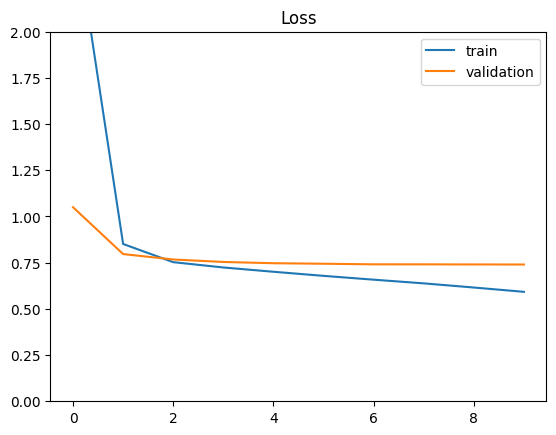

In [24]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

**Questions**:

- Why is the train loss higher than the first loss in the first few epochs?
- Why is Keras not computing the train loss on the full training set at the end of each epoch as it does on the validation set?


Now that the model is trained, the model MSE and MAE look nicer:

In [25]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(4, 4))
    plt.xlim(-1, 6)
    plt.xlabel("True rating")
    plt.ylim(-1, 6)
    plt.ylabel("Predicted rating")
    plt.scatter(y_true, y_pred, s=60, alpha=0.01)

  1/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

  3/625 ━━━━━━━━━━━━━━━━━━━━ 1:18 126ms/step

 16/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step  

 30/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step 

 43/625 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step

 57/625 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step 

 70/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

 83/625 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

 96/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

111/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

126/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

142/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

156/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

171/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

185/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

200/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

213/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

228/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

243/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

259/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

272/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

287/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

301/625 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

316/625 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

331/625 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

343/625 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

358/625 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

372/625 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

384/625 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

398/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

413/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

426/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

439/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

452/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

467/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

481/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

494/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

508/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

522/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

535/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

549/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

563/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

576/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

589/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

602/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


Final test MSE: 0.904
Final test MAE: 0.734


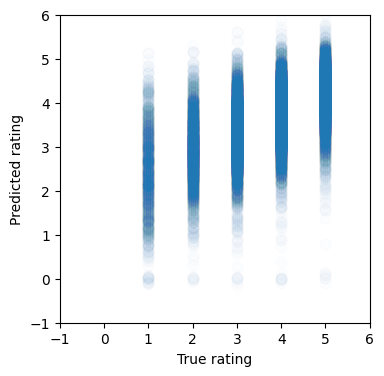

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
plot_predictions(rating_test, test_preds)

   1/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step

  14/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step

  27/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step 

  42/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

  56/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

  71/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

  84/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

  96/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

 109/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

 123/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

 135/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

 149/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 163/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 176/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 189/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 203/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 217/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 229/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 243/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 257/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 272/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 285/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 298/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 311/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 325/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 338/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 352/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 364/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 377/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 392/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

 405/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 420/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 421/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 433/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 447/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 462/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 476/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 490/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 504/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 519/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 534/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 548/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 562/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 577/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 591/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 604/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 615/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 630/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 644/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

 657/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 671/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 684/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 695/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 708/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 722/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 736/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 737/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 748/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 762/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 774/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 788/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 801/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 815/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 828/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 843/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 857/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 871/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 884/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 898/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 911/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 925/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step

 939/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

 952/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

 966/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

 981/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

 995/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1009/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1010/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1023/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1035/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1049/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1063/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1075/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1088/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1103/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1116/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1130/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1145/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1158/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1170/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1184/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

1198/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1210/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1223/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1236/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1247/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1261/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1275/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1289/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1303/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1317/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1329/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1341/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1355/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1368/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1382/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1397/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1410/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1425/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1438/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1449/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

1462/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1477/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1490/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1504/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1518/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1532/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1545/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1557/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1572/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1587/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1602/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1616/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1630/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1644/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1656/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1669/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1682/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1698/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1713/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

1728/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1744/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1757/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1771/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1784/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1798/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1810/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1824/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1837/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1849/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1862/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1876/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1891/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1904/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1918/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1932/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1946/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1961/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

1976/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

1988/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2002/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2015/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2029/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2043/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2058/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2072/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2084/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2098/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2112/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2124/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2137/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2150/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2164/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2178/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2193/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2207/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2220/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2235/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

2250/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2265/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2277/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2290/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2303/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2318/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2334/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2348/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2363/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2377/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2390/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2404/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2417/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2431/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2442/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2456/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2470/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2485/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2499/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step


Final train MSE: 0.618
Final train MAE: 0.574


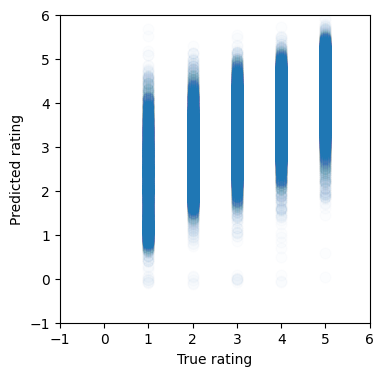

In [27]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))
plot_predictions(rating_train, train_preds)

### Model Embeddings

- It is possible to retrieve the embeddings by simply using the Keras function `model.get_weights` which returns all the model learnable parameters.
- The weights are returned the same order as they were build in the model
- What is the total number of parameters?

In [28]:
# weights and shape
weights = model.get_weights()
[w.shape for w in weights]

[(944, 64), (1683, 64)]

In [29]:
# Solution: 
# model.summary()

In [30]:
user_embeddings = weights[0]
item_embeddings = weights[1]

In [31]:
item_id = 181
print(f"Title for item_id={item_id}: {indexed_items['title'][item_id]}")

Title for item_id=181: Return of the Jedi (1983)


In [32]:
print(f"Embedding vector for item_id={item_id}")
print(item_embeddings[item_id])
print("shape:", item_embeddings[item_id].shape)

Embedding vector for item_id=181
[-0.28070372 -0.20504741 -0.20422375  0.48099867  0.45304877  0.44386676
 -0.11787731  0.34578073 -0.21616425 -0.2152602  -0.31944206 -0.33790123
  0.44959298 -0.73838574  0.22606686 -0.47439918 -0.1422308   0.07183192
 -0.45137554  0.2088442  -0.04875624  0.3843324   0.21495892 -0.29926386
 -0.47832623 -0.24920343 -0.39852855 -0.10804466 -0.35755184 -0.46381566
 -0.2899322   0.3069138   0.5086694  -0.0113887   0.2923462  -0.31296566
  0.0408712   0.20683964 -0.07686566 -0.2763072  -0.47576436  0.12019557
  0.37676555  0.46176502  0.34778407 -0.27124062 -0.48811677 -0.18666136
  0.4240644   0.412908   -0.07726185  0.03743478 -0.09521414  0.15659937
  0.15524499 -0.2857425  -0.39820513  0.0581235  -0.24624892  0.36207786
 -0.26811954 -0.35607386  0.4228636  -0.3799833 ]
shape: (64,)


### Finding most similar items

Finding k most similar items to a point in embedding space

- Write in numpy a function to compute the cosine similarity between two points in embedding space.
- Test it on the following cells to check the similarities between popular movies.
- Bonus: try to generalize the function to compute the similarities between one movie and all the others and return the most related movies.

Notes:
- you may use `np.linalg.norm` to compute the norm of vector, and you may specify the `axis=`
- the numpy function `np.argsort(...)` enables to compute the sorted indices of a vector
- `items["name"][idxs]` returns the names of the items indexed by array idxs

In [33]:
EPSILON = 1e-07  # to avoid division by 0.


def cosine(x, y):
    # TODO: implement me!
    return 0.

In [34]:
# %load solutions/similarity.py

In [35]:
def print_similarity(item_a, item_b, item_embeddings, titles):
    print(titles[item_a])
    print(titles[item_b])
    similarity = cosine(item_embeddings[item_a],
                        item_embeddings[item_b])
    print(f"Cosine similarity: {similarity:.3}")
    
print_similarity(50, 181, item_embeddings, indexed_items["title"])

Star Wars (1977)
Return of the Jedi (1983)
Cosine similarity: 0.0


In [36]:
print_similarity(181, 288, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Scream (1996)
Cosine similarity: 0.0


In [37]:
print_similarity(181, 1, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Toy Story (1995)
Cosine similarity: 0.0


In [38]:
print_similarity(181, 181, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Return of the Jedi (1983)
Cosine similarity: 0.0


In [39]:
def cosine_similarities(item_id, item_embeddings):
    """Compute similarities between item_id and all items embeddings"""
    query_vector = item_embeddings[item_id]
    dot_products = item_embeddings @ query_vector

    query_vector_norm = np.linalg.norm(query_vector)
    all_item_norms = np.linalg.norm(item_embeddings, axis=1)
    norm_products = query_vector_norm * all_item_norms
    return dot_products / (norm_products + EPSILON)


similarities = cosine_similarities(181, item_embeddings)
similarities

array([-0.2284165 ,  0.81522346,  0.7490194 , ...,  0.72239864,
        0.78955674,  0.6326275 ], shape=(1683,), dtype=float32)

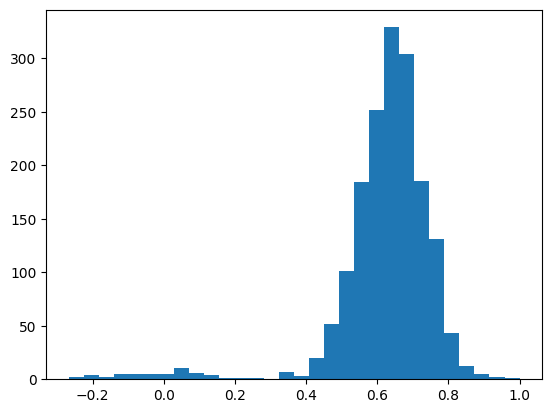

In [40]:
plt.hist(similarities, bins=30);

In [41]:
def most_similar(item_id, item_embeddings, titles,
                 top_n=30):
    sims = cosine_similarities(item_id, item_embeddings)
    # [::-1] makes it possible to reverse the order of a numpy
    # array, this is required because most similar items have
    # a larger cosine similarity value
    sorted_indexes = np.argsort(sims)[::-1]
    idxs = sorted_indexes[0:top_n]
    return list(zip(idxs, titles[idxs], sims[idxs]))


most_similar(50, item_embeddings, indexed_items["title"], top_n=10)

[(np.int64(50), 'Star Wars (1977)', np.float32(1.0)),
 (np.int64(181), 'Return of the Jedi (1983)', np.float32(0.9175112)),
 (np.int64(172), 'Empire Strikes Back, The (1980)', np.float32(0.90002024)),
 (np.int64(228), 'Star Trek: The Wrath of Khan (1982)', np.float32(0.8870127)),
 (np.int64(174), 'Raiders of the Lost Ark (1981)', np.float32(0.8770929)),
 (np.int64(204), 'Back to the Future (1985)', np.float32(0.8681772)),
 (np.int64(290), 'Fierce Creatures (1997)', np.float32(0.85638064)),
 (np.int64(527), 'Gandhi (1982)', np.float32(0.8522146)),
 (np.int64(313), 'Titanic (1997)', np.float32(0.8496763)),
 (np.int64(144), 'Die Hard (1988)', np.float32(0.8467038))]

In [42]:
# items[items['title'].str.contains("Star Trek")]

In [43]:
most_similar(227, item_embeddings, indexed_items["title"], top_n=10)

[(np.int64(227),
  'Star Trek VI: The Undiscovered Country (1991)',
  np.float32(0.9999999)),
 (np.int64(228), 'Star Trek: The Wrath of Khan (1982)', np.float32(0.9010656)),
 (np.int64(230),
  'Star Trek IV: The Voyage Home (1986)',
  np.float32(0.88544023)),
 (np.int64(1540),
  'Amazing Panda Adventure, The (1995)',
  np.float32(0.8718744)),
 (np.int64(755), 'Jumanji (1995)', np.float32(0.86602557)),
 (np.int64(177),
  'Good, The Bad and The Ugly, The (1966)',
  np.float32(0.86407447)),
 (np.int64(429),
  'Day the Earth Stood Still, The (1951)',
  np.float32(0.86163414)),
 (np.int64(778), 'Don Juan DeMarco (1995)', np.float32(0.8613604)),
 (np.int64(290), 'Fierce Creatures (1997)', np.float32(0.857994)),
 (np.int64(781), 'French Kiss (1995)', np.float32(0.8525573))]

The similarities do not always make sense: the number of ratings is low and the embedding  does not automatically capture semantic relationships in that context. Better representations arise with higher number of ratings, and less overfitting  in models or maybe better loss function, such as those based on implicit feedback.

### Visualizing embeddings using TSNE

- we use scikit learn to visualize items embeddings
- Try different perplexities, and visualize user embeddings as well
- What can you conclude ?

In [44]:
from sklearn.manifold import TSNE

item_tsne = TSNE(perplexity=30).fit_transform(item_embeddings)

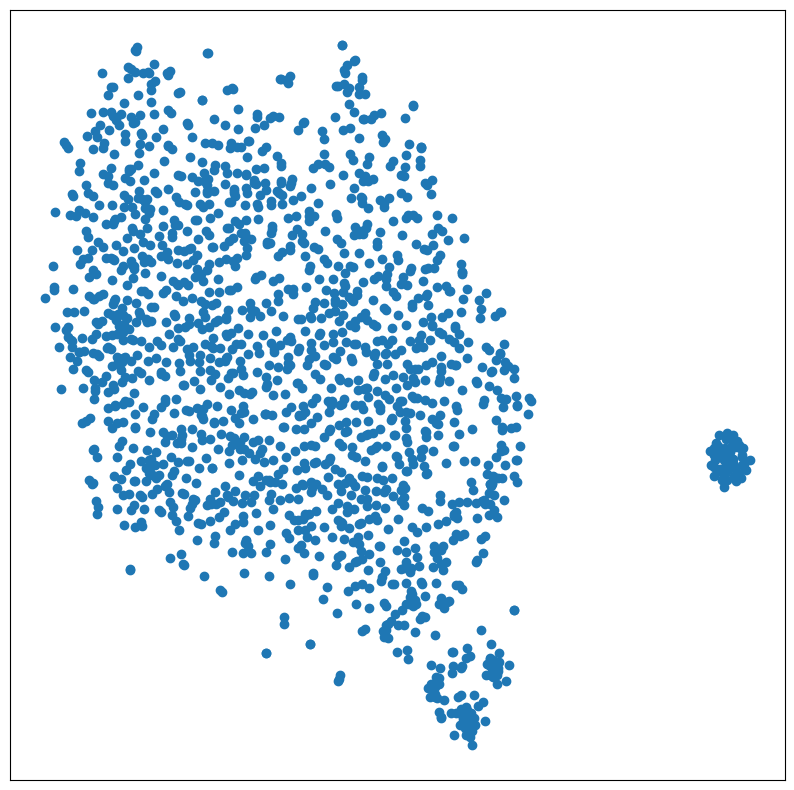

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

In [46]:
%pip install -q plotly

/home/rth/src/dl-lectures-labs/.venv/bin/python3: No module named pip


Note: you may need to restart the kernel to use updated packages.


In [47]:
import plotly.express as px

tsne_df = pd.DataFrame(item_tsne, columns=["tsne_1", "tsne_2"])
tsne_df["item_id"] = np.arange(item_tsne.shape[0])
tsne_df = tsne_df.merge(items.reset_index())

px.scatter(tsne_df, x="tsne_1", y="tsne_2",
           color="popularity",
           hover_data=["item_id", "title",
                       "release_year", "popularity"])

Alternatively with [Uniform Manifold Approximation and Projection](https://github.com/lmcinnes/umap):

In [48]:
# %pip install umap-learn

In [49]:
# import umap

# item_umap = umap.UMAP().fit_transform(item_embeddings)
# plt.figure(figsize=(10, 10))
# plt.scatter(item_umap[:, 0], item_umap[:, 1]);
# plt.xticks(()); plt.yticks(());
# plt.show()

In [50]:
from keras.layers import Concatenate

In [51]:
# For each sample we input the integer identifiers
# of a single user and a single item
class DeepRegressionModel(Model):

    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(
            output_dim=embedding_size,
            input_dim=max_user_id + 1,
            input_length=1,
            name='user_embedding'
        )
        self.item_embedding = Embedding(
            output_dim=embedding_size,
            input_dim=max_item_id + 1,
            input_length=1,
            name='item_embedding'
        )

        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.concat = Concatenate()

        ## Error 1: Dropout was too high, preventing any training
        self.dropout = Dropout(0.5)
        self.dense1 = Dense(64, activation="relu")
        ## Error 2: output dimension was 2 where we predict only 1-d rating
        ## Error 3: tanh activation squashes the outputs between -1 and 1
        ## when we want to predict values between 1 and 5
        self.dense2 = Dense(1)

    def call(self, inputs, training=False):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))

        input_vecs = self.concat([user_vecs, item_vecs])

        y = self.dropout(input_vecs, training=training)
        y = self.dense1(y)
        y = self.dropout(y, training=training)
        y = self.dense2(y)

        return y


model = DeepRegressionModel(64, max_user_id, max_item_id)
## Error 4: A binary crossentropy loss is only useful for binary
## classification, while we are in regression (use mse or mae)
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train, item_id_train])

   1/2500 ━━━━━━━━━━━━━━━━━━━━ 51s 21ms/step

  11/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step 

  22/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

  32/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

/home/rth/src/dl-lectures-labs/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning:

Argument `input_length` is deprecated. Just remove it.



  42/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

  53/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

  65/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

  76/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

  86/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

  98/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 109/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 120/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 130/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 141/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 152/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 163/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 174/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 185/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 196/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 207/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 218/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 229/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 240/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 251/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 262/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 272/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 282/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 293/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 304/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 315/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 326/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 336/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 347/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 357/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 368/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 379/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 390/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 401/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 412/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 423/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 435/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step 

 445/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 457/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 468/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 479/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 489/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 511/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 521/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 532/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 541/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 552/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 563/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 573/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 584/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 594/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 605/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 616/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 627/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 637/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 648/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 659/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 669/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 680/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 691/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 701/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 712/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 713/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 723/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 733/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 743/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 752/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 763/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 773/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 783/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 793/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 803/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 813/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 824/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 835/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 844/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 854/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 864/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 875/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 885/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

 896/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

 907/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

 917/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

 926/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

 936/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

 944/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

 955/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

 966/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

 977/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

 986/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

 996/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1006/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1017/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1027/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1036/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1045/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1054/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1064/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1074/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1084/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1095/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1104/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1113/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1123/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1133/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1143/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1154/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1164/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1174/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1185/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1194/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1204/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1215/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1224/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1234/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1244/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1254/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1263/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1273/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1283/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1294/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1305/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1316/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1326/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1335/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1345/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1356/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1366/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1377/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1388/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1398/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1409/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1420/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1430/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1440/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1450/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1459/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1468/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1480/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1490/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1510/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1520/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1531/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1542/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1553/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1563/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1574/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1585/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1595/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1606/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1615/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1625/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1636/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1647/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1657/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1658/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1667/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1677/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1688/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1698/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1708/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1718/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1728/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1737/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1746/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1755/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1765/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1775/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1785/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1794/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1804/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1814/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1824/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1834/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1844/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1853/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1863/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1874/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1883/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1893/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1904/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1915/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

1925/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

1936/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

1947/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

1957/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

1968/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

1977/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

1987/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

1997/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2008/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2018/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2027/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2037/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2047/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2056/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2067/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2078/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2088/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2098/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2109/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2118/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2129/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2139/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2149/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2159/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2170/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2180/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2191/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2201/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2211/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2221/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2230/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2240/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2250/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2260/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2270/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2280/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2290/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2299/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2308/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2318/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2328/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2338/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2347/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2357/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2367/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2377/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2388/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2399/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2409/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2418/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2428/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2439/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2449/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2459/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2469/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2479/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2490/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step


In [52]:
# %load solutions/deep_explicit_feedback_recsys.py

In [53]:
%%time
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 3.5136

   3/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - loss: 3.5897

   7/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 3.6075

   9/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 3.6105

  13/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 3.6055

  16/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 3.5986

  20/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 3.5838

  22/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 3.5771

  25/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 3.5683

  28/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 3.5582

  32/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 3.5458

  35/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 3.5370

  38/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 3.5279

  41/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 3.5187

  45/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 3.5073

  47/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 3.5016

  50/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 3.4929

  54/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 3.4814

  58/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 3.4699

  62/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 3.4579

  65/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 3.4486

  69/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 3.4361

  72/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 3.4266

  75/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 3.4170

  78/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 3.4071

  81/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 3.3969

  85/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 3.3827

  89/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 3.3676

  93/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.3518

  97/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.3355

  99/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.3272

 103/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.3099

 106/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.2965

 109/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.2828

 113/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.2639

 116/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.2495

 119/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.2349

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.2151

 125/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.2052

 128/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.1901

 131/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.1750

 134/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.1598

 137/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.1446

 140/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.1294

 144/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 3.1093

 148/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 3.0892

 152/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 3.0694

 156/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 3.0497

 159/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 3.0351

 162/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 3.0206

 165/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 3.0062

 167/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 2.9967

 170/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 2.9825

 173/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 2.9685

 176/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 2.9546

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 2.9364

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 2.9228

 186/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 2.9095

 189/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 2.8963

 192/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 2.8833

 196/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 2.8662

 200/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 2.8494

 203/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 2.8369

 206/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 2.8247

 209/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 2.8125

 212/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 2.8006

 215/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 2.7887

 218/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 2.7771

 222/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 2.7617

 226/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 2.7467

 230/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 2.7319

 234/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 2.7173

 238/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 2.7030

 242/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 2.6890

 244/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 2.6821

 246/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 2.6752

 248/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 2.6684

 251/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 2.6583

 255/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 2.6449

 258/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 2.6351

 261/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 2.6254

 265/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 2.6126

 268/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 2.6032

 271/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 2.5939

 274/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 2.5847

 277/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 2.5756

 280/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 2.5666

 283/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 2.5577

 286/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 2.5490

 289/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 2.5403

 291/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 2.5346

 295/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 2.5233

 298/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 2.5149

 301/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 2.5067

 303/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 2.5012

 306/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 2.4931

 310/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 2.4825

 313/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 2.4746

 317/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 2.4642

 320/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 2.4565

 324/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 2.4464

 327/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 2.4389

 330/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 2.4315

 334/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 2.4217

 338/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 2.4121

 340/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 2.4073

 342/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 2.4026

 345/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 2.3956

 347/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 2.3910

 351/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 2.3818

 354/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 2.3750

 357/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 2.3683

 361/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 2.3595

 364/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 2.3530

 368/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 2.3443

 371/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 2.3380

 375/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 2.3295

 378/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 2.3233

 381/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 2.3171

 385/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 2.3089

 389/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 2.3009

 393/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 2.2930

 396/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 2.2871

 400/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 2.2793

 403/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 2.2735

 406/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 2.2678

 409/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 2.2622

 412/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 2.2566

 415/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 2.2510

 419/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 2.2437

 422/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.2383

 425/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.2330

 428/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.2276

 430/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.2241

 433/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.2189

 436/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.2137

 440/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.2069

 444/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.2001

 448/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.1934

 451/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.1885

 455/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.1819

 458/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.1771

 461/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.1723

 463/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.1691

 466/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.1644

 469/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 2.1597

 473/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 2.1535

 476/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 2.1488

 479/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 2.1443

 483/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 2.1382

 485/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 2.1352

 487/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 2.1323

 490/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 2.1278

 494/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 2.1220

 498/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 2.1162

 501/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 2.1119

 504/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 2.1076

 507/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 2.1034

 510/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 2.0992

 513/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 2.0950

 516/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 2.0909

 521/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 2.0841

 525/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 2.0787

 529/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.0734

 532/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.0694

 535/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.0655

 538/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.0616

 542/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.0564

 545/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.0526

 549/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.0475

 553/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.0425

 556/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.0388

 559/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.0351

 563/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.0302

 567/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.0254

 571/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.0206

 573/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.0182

 576/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.0147

 579/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 2.0112

 582/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 2.0077 

 585/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 2.0042

 589/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1.9996

 593/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1.9951

 596/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1.9917

 600/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1.9872

 603/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1.9839

 606/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1.9806

 609/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1.9774

 611/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1.9752

 614/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1.9720

 617/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1.9687

 620/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1.9656

 623/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1.9624

 625/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1.9603

 627/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1.9582

 630/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1.9551

 634/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 1.9510

 637/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 1.9479

 640/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 1.9449

 643/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 1.9418

 646/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 1.9388

 649/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 1.9358

 652/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 1.9329

 654/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 1.9309

 656/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 1.9290

 659/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 1.9260

 662/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 1.9231

 665/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 1.9203

 667/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 1.9183

 670/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 1.9155

 673/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 1.9127

 676/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 1.9099

 679/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 1.9071

 683/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 1.9034

 687/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 1.8997

 690/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 1.8970

 694/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 1.8934

 698/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8898

 702/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8863

 706/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8828

 709/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8801

 712/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8775

 714/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8758

 717/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8732

 721/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8698

 724/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8673

 727/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8648

 730/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8623

 733/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8598

 736/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8573

 737/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8565

 741/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8532

 744/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8507

 747/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8483

 749/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8467

 752/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8443

 756/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.8411

 759/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.8388

 761/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.8372

 764/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.8348

 766/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.8333

 770/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.8302

 774/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.8271

 777/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.8248

 780/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.8226

 784/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.8195

 787/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.8173

 790/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.8151

 793/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.8128

 797/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.8099

 800/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.8077

 804/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.8048

 807/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.8027

 810/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.8005

 813/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7984

 816/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7962

 819/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7941

 821/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7927

 824/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7906

 826/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7892

 829/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7872

 832/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7851

 834/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7837

 837/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7817

 840/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7796

 844/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7769

 847/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7749

 850/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7729

 852/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7716

 854/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7702

 858/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7676

 861/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7656

 863/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.7643

 865/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.7630

 869/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.7605

 872/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.7585

 875/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.7566

 878/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.7547

 881/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.7528

 884/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.7509

 887/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.7490

 890/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.7472

 893/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.7453

 897/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.7428

 901/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.7404

 904/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.7385

 907/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.7367

 910/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.7349

 913/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.7331

 916/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.7313

 920/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.7289

 923/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.7271

 926/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.7254

 929/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.7236

 933/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.7213

 936/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.7195

 940/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.7172

 943/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.7155

 947/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.7132

 951/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.7110

 954/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.7093

 957/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.7076

 960/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.7059

 964/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.7037

 967/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.7020

 971/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6998

 973/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6987

 975/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6976

 978/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6960

 981/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6944

 983/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6933

 986/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6917

 990/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6896

 992/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6885

 995/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6869

 998/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6853

1001/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6838

1004/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6822

1007/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6806

1011/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6786

1015/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6765

1018/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6750

1021/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6735

1024/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6719

1028/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6699

1031/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6684

1034/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6669

1037/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6654

1041/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6634

1043/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6625

1047/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6605

1050/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6590

1052/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6581

1056/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6561

1059/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6547

1062/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6532

1066/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6513

1069/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6499

1072/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6485

1076/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6466

1079/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6452

1082/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6438

1086/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6420

1089/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6406

1092/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6392

1094/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6383

1097/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6369

1100/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6355

1103/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6342

1107/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6324

1111/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6306

1115/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6288

1118/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6275

1121/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6261

1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.6248

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - loss: 1.1313 - val_loss: 0.7722


Epoch 2/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - loss: 0.7800

   5/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.8599

   8/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.8750

  10/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.8820

  14/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.8907

  18/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.8935

  20/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.8938

  24/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.8938

  27/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.8943

  31/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.8942

  34/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.8938

  36/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.8934

  39/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.8930

  43/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.8923

  46/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.8915

  51/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8906

  53/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.8905

  55/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.8904

  59/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.8904

  63/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8904

  66/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8904

  70/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8905

  73/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8904

  76/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8905

  79/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8905

  82/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8905

  86/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8904

  89/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8904

  93/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8904

  96/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8904

  99/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8903

 102/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.8904

 104/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8904

 107/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8905

 109/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8906

 111/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8906

 114/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8906

 117/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8907

 121/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8906

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8906

 126/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8906

 129/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8905

 132/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8905

 135/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8904

 138/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8904

 140/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8904

 143/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.8903

 146/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.8903

 149/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - loss: 0.8903

 153/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.8903

 156/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.8903

 159/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.8902

 163/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.8902

 167/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.8902

 171/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.8902

 174/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.8901

 178/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.8901

 181/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.8900

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.8900

 187/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.8900

 190/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.8899

 193/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.8899

 196/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.8898

 200/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.8898

 203/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.8897

 207/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.8897

 209/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.8896

 212/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.8896

 215/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.8895

 218/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.8895

 221/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.8894

 224/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.8893

 226/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.8893

 229/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.8892

 233/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.8891

 236/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.8890

 239/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.8890

 242/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 0.8889

 245/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8888

 248/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8887

 251/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8887

 255/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8886

 258/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8885

 261/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8884

 264/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8884

 267/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8883

 270/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8882

 273/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8882

 275/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8881

 278/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8880

 281/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8880

 284/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8879

 287/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8878

 290/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8877

 294/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8876

 298/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8875

 302/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8874

 306/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8872

 309/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8872

 312/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8871

 316/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8870

 318/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8869

 322/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8868

 325/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8867

 328/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8866

 331/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8865

 334/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8865

 337/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8864

 340/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8863

 343/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8862

 347/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8861

 351/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8860

 354/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8859

 357/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8858

 361/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8857

 365/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8856

 369/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8855

 372/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8855

 376/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8854

 379/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8853

 383/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8852

 386/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8852

 389/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8851

 392/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.8851

 396/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.8850

 399/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.8849

 402/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.8849

 405/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.8848

 409/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.8847

 412/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.8847

 415/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.8846

 418/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.8845

 421/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.8845

 423/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.8844

 426/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.8844

 429/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.8843

 432/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.8843

 435/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.8842

 438/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.8842

 442/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.8841

 445/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.8840

 447/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.8840

 450/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.8839

 453/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.8839

 456/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.8839

 459/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.8838

 462/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.8838

 466/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.8837

 470/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.8836

 474/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.8836

 477/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.8835

 480/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.8835

 484/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.8834

 487/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.8834

 490/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.8833

 493/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.8833

 496/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.8832

 500/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.8832

 503/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.8831

 506/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.8831

 510/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.8830

 513/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.8830

 516/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.8830

 520/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.8829

 523/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.8829

 526/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.8828

 529/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.8828

 532/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.8827

 535/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.8827

 539/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.8827

 542/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.8826

 547/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8826

 550/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8825

 554/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8825

 557/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8824

 561/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8824

 564/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8823

 568/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8823

 571/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8822

 575/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8822

 578/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8822

 581/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8821

 584/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8821

 586/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8821

 589/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8820

 592/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8820

 596/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8820

 599/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8819 

 602/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8819

 604/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8819

 608/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8818

 611/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8818

 614/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8818

 617/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8817

 619/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8817

 621/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8817

 624/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8816

 628/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8816

 631/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8816

 634/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8815

 637/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8815

 640/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8815

 643/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8814

 646/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8814

 649/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8814

 652/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8814

 656/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8813

 660/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8813

 664/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8813

 668/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8812

 671/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8812

 673/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8812

 676/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8812

 678/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8811

 681/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8811

 684/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8811

 687/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8811

 691/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8810

 694/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8810

 697/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8810

 700/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8809

 703/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8809

 707/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8809

 711/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8808

 715/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8808

 718/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8808

 721/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8807

 724/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8807

 727/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8807

 730/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8807

 733/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8806

 736/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8806

 739/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8806

 742/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8806

 744/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8805

 748/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8805

 751/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8805

 754/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8805

 757/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8804

 760/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8804

 764/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8804

 768/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8804

 772/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8803

 776/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8803

 779/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8803

 783/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8802

 786/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8802

 789/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8802

 791/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8802

 793/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8802

 796/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8801

 800/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8801

 803/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8801

 806/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8801

 809/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8800

 813/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8800

 816/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8800

 819/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8800

 822/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8799

 825/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8799

 828/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8799

 830/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8799

 833/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8798

 836/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8798

 839/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8798

 842/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8798

 845/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8798

 849/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8797

 852/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8797

 856/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8797

 859/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8797

 862/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8796

 866/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.8796

 869/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.8796

 872/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.8796

 875/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.8795

 878/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.8795

 882/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.8795

 885/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.8795

 888/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.8795

 892/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.8794

 896/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.8794

 899/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.8794

 903/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.8794

 907/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.8793

 910/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.8793

 914/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.8793

 917/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8793

 920/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8793

 923/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8793

 925/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8792

 928/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8792

 931/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8792

 934/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8792

 937/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8792

 940/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8792

 944/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8791

 947/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8791

 950/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8791

 952/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8791

 955/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8791

 958/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8791

 961/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8791

 964/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8790

 967/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8790

 970/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8790

 974/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8790

 977/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8790

 980/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8790

 983/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8790

 986/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8789

 988/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8789

 991/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8789

 994/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8789

 997/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8789

 999/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8789

1002/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8789

1005/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8789

1009/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8788

1013/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8788

1017/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8788

1020/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8788

1023/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8788

1026/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8788

1029/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8788

1032/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8788

1036/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8787

1039/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8787

1042/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8787

1045/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8787

1048/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8787

1051/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8787

1055/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8787

1058/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8787

1061/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8786

1064/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8786

1067/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8786

1069/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8786

1072/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8786

1075/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8786

1077/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8786

1081/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8786

1084/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8785

1087/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8785

1090/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8785

1094/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8785

1097/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8785

1100/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8785

1104/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8784

1106/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8784

1109/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8784

1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8784

1115/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8784

1118/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8784

1120/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8784

1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8783

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 0.8727 - val_loss: 0.7560


Epoch 3/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - loss: 0.7594

   4/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 0.8231

   8/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.8368

  12/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.8343

  15/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.8342

  19/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.8339

  22/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.8342

  26/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.8360

  30/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.8367

  33/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.8372

  36/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.8375

  38/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8379

  41/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8384

  44/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8389

  47/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8393

  50/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8395

  53/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8396

  55/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8397

  58/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8399

  62/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8400

  65/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8401

  68/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8403

  72/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8405

  75/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8406

  79/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8407

  84/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8408

  87/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8410

  90/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8413

  92/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8414

  95/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8416

  98/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8417

 102/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8419

 105/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8421

 108/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8422

 112/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8423

 114/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8424

 117/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8425

 120/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8426

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8428

 127/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8430

 130/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8432

 134/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8434

 138/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8436

 142/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8438

 145/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8439

 148/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8440

 151/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8441

 154/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8442

 158/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8442

 161/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8443

 164/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8444

 167/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8444

 171/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8445

 174/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8445

 176/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8446

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8446

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8447

 187/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8448

 190/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8448

 193/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8449

 197/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8449

 200/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8450

 204/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8451

 207/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8451

 211/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8452

 215/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8453

 219/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8454

 223/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8454

 227/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8455

 231/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8455

 235/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8455

 238/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8456

 241/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8456

 245/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8457

 248/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8457

 252/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8458

 255/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8459

 258/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8459

 261/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8460

 265/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8460

 268/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8461

 271/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8461

 273/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8461

 276/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8462

 279/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8462

 282/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8462

 285/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8463

 288/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8463

 292/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8463

 296/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.8464

 300/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.8464

 304/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.8464

 306/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.8464

 310/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.8464

 313/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.8464

 316/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.8464

 319/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.8464

 323/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.8465

 325/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.8465

 329/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.8465

 332/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.8465

 335/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.8465

 339/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.8466

 343/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.8466

 347/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.8466

 350/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.8467

 354/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.8467

 357/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8468

 359/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8468

 362/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8468

 364/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8468

 367/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8469

 369/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8469

 372/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8470

 375/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8470

 377/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8470

 381/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8471

 385/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8471

 389/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8472

 393/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8472

 397/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8473

 400/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8473

 405/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8474

 407/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8474

 409/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8474

 411/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8474

 415/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8474

 418/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.8475

 421/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.8475

 425/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.8475

 429/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.8476

 432/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.8476

 435/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.8476

 439/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.8476

 442/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.8476

 445/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.8477

 448/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.8477

 451/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.8477

 454/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.8477

 458/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.8477

 461/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.8477

 464/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.8477

 468/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.8477

 472/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8477

 474/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8477

 478/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8477

 481/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8477

 484/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8478

 488/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8478

 492/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8478

 496/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8478

 499/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8478

 501/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8478

 504/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8478

 508/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8478

 510/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8478

 513/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8478

 515/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8478

 518/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8478

 521/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8478

 525/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8478

 527/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.8478

 530/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.8478

 533/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.8478

 537/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.8478

 540/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.8478

 543/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.8477

 546/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.8477

 549/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.8477

 552/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.8477

 556/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.8477

 559/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.8477

 563/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.8477

 566/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.8477

 569/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.8476

 572/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8476

 575/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8476

 578/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8476

 581/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8476

 585/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.8476

 588/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8476 

 591/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8475

 595/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.8475

 598/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.8475

 602/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.8475

 605/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.8475

 608/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8475

 611/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8474

 614/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8474

 617/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8474

 619/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8474

 624/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.8474

 628/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.8474

 631/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8473

 634/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8473

 637/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8473

 639/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.8473

 642/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8473

 645/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8473

 648/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8473

 651/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8472

 654/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8472

 656/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8472

 659/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8472

 662/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8472

 665/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8472

 668/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8472

 671/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8472

 675/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8472

 678/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8472

 680/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8472

 683/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8471

 686/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8471

 689/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8471

 692/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8471

 695/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.8471

 698/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8471

 702/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8471

 705/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8471

 708/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8471

 713/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8470

 716/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8470

 720/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8470

 723/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8470

 726/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8470

 730/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8470

 733/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8470

 735/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8470

 739/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8469

 743/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8469

 746/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8469

 749/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.8469

 752/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8469

 756/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8469

 759/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8469

 762/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8468

 766/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8468

 769/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8468

 773/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8468

 776/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8468

 780/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8468

 783/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8468

 786/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8467

 790/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8467

 794/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8467

 797/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8467

 800/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8467

 804/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8467

 808/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8467

 812/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8466

 815/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8466

 818/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8466

 821/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8466

 824/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8466

 827/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8466

 830/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8466

 834/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.8466

 839/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.8465

 842/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.8465

 846/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.8465

 849/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.8465

 852/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.8465

 855/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.8465

 859/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.8465

 862/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.8464

 865/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.8464

 868/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.8464

 872/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.8464

 876/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.8464

 880/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.8464

 883/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.8464

 885/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.8463

 889/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.8463

 893/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.8463

 896/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.8463

 899/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.8463

 903/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.8463

 906/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.8462

 909/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.8462

 913/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.8462

 915/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.8462

 917/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8462

 919/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8462

 921/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8462

 924/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8462

 927/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8461

 929/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8461

 931/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8461

 934/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8461

 936/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8461

 940/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8461

 943/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8461

 945/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8461

 948/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8461

 951/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8460

 953/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8460

 956/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8460

 959/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8460

 962/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.8460

 966/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8460

 969/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8460

 973/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8460

 977/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8460

 980/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8459

 984/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8459

 986/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8459

 989/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8459

 992/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8459

 995/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8459

 999/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8459

1002/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8459

1006/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8459

1009/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8458

1013/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8458

1016/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8458

1019/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8458

1023/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8458

1028/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8458

1031/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8458

1034/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8458

1037/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8458

1040/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8457

1044/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8457

1048/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8457

1052/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8457

1055/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8457

1058/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8457

1061/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8457

1063/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8457

1065/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8457

1069/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8457

1072/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8456

1075/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8456

1078/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8456

1081/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8456

1084/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8456

1087/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8456

1090/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8456

1093/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8456

1096/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8456

1099/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8456

1102/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8456

1105/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8456

1108/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8455

1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8455

1114/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8455

1116/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8455

1119/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8455

1122/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8455

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.8422 - val_loss: 0.7541


Epoch 4/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.8046

   5/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.8337

   9/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.8424

  12/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.8421

  15/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.8413

  18/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.8389

  21/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.8369

  26/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.8333

  29/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8326

  33/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.8310

  36/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.8299

  39/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.8291

  44/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.8283

  48/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.8276

  52/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.8268

  54/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.8265

  57/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.8262

  60/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8261

  62/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8260

  65/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.8258

  69/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8256

  73/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8256

  76/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8257

  79/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8258

  83/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8259

  86/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8260

  88/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8260

  90/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8260

  94/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8259

  98/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8259

 101/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8259

 103/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8258

 105/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8258

 108/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8258

 112/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8257

 114/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8257

 117/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8256

 120/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8256

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8256

 126/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8255

 130/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8255

 133/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8254

 136/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.8254

 140/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8254

 143/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8254

 147/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8254

 151/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8253

 155/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8253

 158/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8253

 160/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8252

 164/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8252

 166/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8252

 169/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8251

 173/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8251

 177/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8251

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8250

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8250

 186/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.8249

 190/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8249

 192/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8248

 195/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8248

 198/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8248

 201/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8247

 205/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8247

 208/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8246

 212/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8246

 215/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8245

 218/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8245

 220/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8244

 222/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8244

 224/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.8243

 226/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8243

 228/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8242

 231/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8242

 233/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8241

 236/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8241

 240/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8240

 242/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8239

 245/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8239

 249/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8238

 252/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8238

 255/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8237

 258/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8237

 261/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8237

 263/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8236

 265/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8236

 267/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8236

 270/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8236

 272/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8235

 274/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8235

 277/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8235

 280/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8234

 283/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8234

 286/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8233

 290/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8233

 293/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8232

 296/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.8232

 299/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8231

 303/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8231

 306/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8231

 310/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8230

 313/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8230

 317/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8230

 320/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8229

 323/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8229

 325/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8229

 328/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8229

 332/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8228

 335/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8228

 338/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8228

 341/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8228

 343/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 0.8227

 346/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8227

 349/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8227

 352/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8227

 354/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8227

 357/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8226

 359/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8226

 362/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8226

 364/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8226

 367/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8226

 370/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.8225

 372/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8225

 375/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8225

 378/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8224

 381/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8224

 384/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8223

 386/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8223

 388/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8223

 390/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8223

 393/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8222

 396/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8222

 398/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8222

 400/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8222

 403/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8221

 405/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8221

 408/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8221

 411/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8221

 414/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8220

 416/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8220

 418/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8220

 420/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8220

 423/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8220

 426/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.8220

 428/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8219

 430/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8219

 433/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8219

 435/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8219

 437/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8219

 440/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8219

 442/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8218

 445/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8218

 447/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8218

 449/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8218

 451/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8218

 453/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8218

 455/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8217

 458/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8217

 460/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8217

 463/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8217

 466/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8217

 469/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8217

 472/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8217

 475/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.8216

 478/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.8216

 481/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.8216

 484/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.8216

 486/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.8216

 488/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.8215

 491/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.8215

 493/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.8215

 496/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.8215

 499/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.8214

 501/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.8214

 504/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.8214

 507/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.8214

 510/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.8214

 514/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.8214

 516/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.8213

 519/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.8213

 521/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.8213

 524/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.8213

 528/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.8213

 530/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.8213

 534/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.8212

 536/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.8212

 539/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.8212

 542/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.8212

 544/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.8212

 548/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8212

 551/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8212

 554/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8211

 557/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8211

 559/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8211

 562/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8211

 564/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8211

 567/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8211

 569/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8211

 571/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8211

 575/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8211

 577/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8210

 580/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8210

 583/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8210

 586/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8210

 589/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8210

 591/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8210

 594/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8210

 596/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.8210

 599/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8210

 601/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8210

 603/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8210

 605/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8210

 607/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8210

 610/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8209

 612/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8209

 615/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8209

 618/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8209

 621/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8209

 623/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8209

 625/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8209

 627/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8209

 629/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8209

 631/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8209

 635/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8209

 637/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8209

 640/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8209

 642/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8209

 645/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8209

 648/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8208

 650/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.8208

 653/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8208 

 655/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8208

 658/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8208

 660/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8208

 663/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8208

 665/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8208

 668/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8208

 670/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8208

 673/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8208

 675/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8208

 677/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8208

 680/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8208

 682/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8208

 685/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8207

 687/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8207

 689/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8207

 692/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8207

 695/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8207

 697/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8207

 699/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.8207

 703/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.8207

 706/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.8207

 709/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.8207

 712/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.8206

 715/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.8206

 718/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.8206

 722/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.8206

 724/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.8206

 728/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.8206

 731/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.8206

 734/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.8206

 737/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.8205

 739/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.8205

 742/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.8205

 745/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.8205

 747/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.8205

 750/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.8205

 752/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.8205

 755/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.8205

 758/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.8205

 761/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.8205

 763/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.8204

 765/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.8204

 768/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.8204

 771/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.8204

 774/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.8204

 777/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.8204

 780/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.8204

 783/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.8204

 786/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.8204

 789/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.8204

 791/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.8204

 793/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.8204

 795/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.8203

 798/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.8203

 800/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8203

 802/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8203

 804/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8203

 807/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8203

 810/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8203

 813/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8203

 816/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8203

 819/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8203

 821/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8203

 825/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8203

 827/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8202

 830/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8202

 832/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8202

 836/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8202

 838/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8202

 841/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8202

 843/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8202

 846/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8202

 849/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8202

 852/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8202

 854/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8201

 857/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8201

 859/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8201

 862/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8201

 865/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8201

 867/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8201

 870/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8201

 872/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8201

 875/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8201

 878/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8201

 881/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8200

 884/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8200

 886/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8200

 890/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8200

 893/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.8200

 896/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.8200

 899/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.8200

 901/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.8200

 904/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.8200

 907/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.8200

 910/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.8199

 913/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.8199

 916/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.8199

 919/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.8199

 921/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.8199

 924/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.8199

 927/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.8199

 931/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.8199

 933/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.8199

 935/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.8199

 939/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.8198

 941/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.8198

 944/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.8198

 947/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.8198

 950/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.8198

 953/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.8198

 956/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.8198

 959/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.8198

 962/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.8198

 965/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.8198

 968/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.8198

 972/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.8197

 975/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.8197

 978/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.8197

 980/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.8197

 983/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.8197

 986/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.8197

 989/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8197

 992/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8197

 995/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8197

 998/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8197

1001/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8197

1004/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8197

1006/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8196

1008/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8196

1010/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8196

1012/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8196

1014/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8196

1016/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8196

1018/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8196

1020/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8196

1023/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8196

1026/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8196

1029/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8196

1031/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8196

1035/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8196

1038/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8195

1041/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8195

1044/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8195

1046/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8195

1050/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8195

1053/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8195

1056/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8195

1059/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8195

1062/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8195

1065/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8195

1068/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8194

1070/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8194

1073/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8194

1075/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8194

1078/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8194

1081/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8194

1083/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8194

1086/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8194

1088/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8194

1092/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8194

1095/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8194

1098/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8193

1101/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8193

1103/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8193

1106/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8193

1109/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8193

1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8193

1114/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8193

1117/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8193

1119/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8193

1123/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8193

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8192

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.8153 - val_loss: 0.7475


Epoch 5/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - loss: 0.6897

   3/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - loss: 0.7533

   6/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 0.7627

  10/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7680

  13/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.7710

  16/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 0.7745

  18/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7755

  21/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7769

  24/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7781

  26/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7790

  28/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 0.7796

  30/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 0.7802

  32/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7807

  35/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7814

  38/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7819

  41/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7824

  43/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7828

  46/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7832

  49/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7838

  51/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7841

  54/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7845

  57/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7849

  60/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7851

  62/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7852

  65/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7854

  68/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7855

  71/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7857

  74/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7858

  77/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7860

  80/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7863

  83/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7864

  85/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7865

  88/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7868

  90/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7869

  93/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7871

  95/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7872

  98/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7873

 101/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7875

 104/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7876

 107/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7878

 109/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7879

 111/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7880

 114/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7882

 117/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7884

 119/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7885

 122/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7886

 124/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7887

 126/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7888

 128/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7889

 131/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7890

 133/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7890

 136/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7891

 139/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7892

 143/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7893

 145/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7894

 147/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7894

 150/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7895

 152/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7895

 154/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7895

 156/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7896

 159/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7896

 162/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7897

 165/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7897

 168/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7898

 171/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7898

 174/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7899

 177/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7899

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7900

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7900

 186/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7900

 189/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7901

 191/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7901

 194/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7901

 197/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7901

 199/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7901

 201/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7901

 203/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7901

 205/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7901

 207/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7901

 209/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7902

 212/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7902

 215/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7902

 218/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7902

 221/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7902

 223/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7902

 225/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7902

 227/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7902

 229/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7902

 231/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7902

 234/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7902

 237/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7902

 240/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7902

 243/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7902

 245/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7903

 249/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7903

 252/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7903

 254/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7903

 257/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7903

 259/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7903

 262/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7904

 264/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7904

 267/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7904

 270/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7904

 273/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7905

 276/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7905

 278/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7905

 282/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7906

 285/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7906

 287/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7907

 290/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7907

 292/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7907

 295/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7907

 297/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7907

 299/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7908

 302/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7908

 305/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7908

 309/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7908

 312/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7908

 314/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7908

 318/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7908

 321/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7909

 324/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7909

 327/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7909

 330/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7909

 333/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7909

 336/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7909

 339/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7910

 343/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7910

 345/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7910

 348/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7910

 350/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7910

 352/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7911

 354/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7911

 357/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7911

 360/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7911

 362/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7911

 366/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7912

 368/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7912

 370/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7912

 372/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7912

 375/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7912

 377/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7913

 380/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7913

 384/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7913

 386/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7913

 388/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7913

 390/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7913

 392/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7913

 394/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7913

 398/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7914

 401/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7914

 404/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7914

 407/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7914

 410/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7914

 413/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7914

 416/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7915

 420/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7915

 423/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7915

 425/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7915

 427/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7915

 429/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7915

 432/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7916

 434/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7916

 437/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7916

 440/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7916

 444/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7917

 446/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7917

 449/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7917

 452/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7917

 455/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7918

 458/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7918

 460/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7918

 464/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7919

 467/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7919

 470/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7919

 473/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7919

 476/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7920

 479/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7920

 482/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7920

 485/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7921

 488/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7921

 491/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7921

 494/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7922

 497/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7922

 500/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7923

 502/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7923

 505/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7923

 508/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7924

 512/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7924

 514/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7924

 517/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7925

 519/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7925

 521/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7925

 523/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7925

 526/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7926

 528/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7926

 530/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7926

 532/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7926

 535/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7927

 538/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7927

 540/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7927

 541/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7927

 543/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7928

 545/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7928

 547/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7928

 549/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7928

 552/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7928

 555/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7929

 557/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7929

 560/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7929

 562/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7929

 564/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7930

 567/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7930

 569/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7930

 571/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7930

 574/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7931

 577/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7931

 580/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7931

 582/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7931

 584/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7932

 588/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7932

 591/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7932

 594/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7933

 597/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7933

 601/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7933

 603/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7933

 606/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7934

 609/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7934

 612/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7934

 616/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7935

 618/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7935

 620/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7935

 622/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7935

 625/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7936

 628/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7936

 631/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7936

 633/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7936

 637/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7937

 639/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7937

 642/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7937

 644/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7937

 647/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7938

 650/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7938

 653/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7938

 657/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7939

 660/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7939

 663/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7939

 667/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7940

 670/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7940

 673/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7940

 676/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7940

 679/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7941

 682/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7941

 686/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7941 

 688/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7941

 691/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7942

 693/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7942

 696/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7942

 698/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7942

 700/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7942

 703/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7943

 706/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7943

 709/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7943

 711/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7943

 714/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7944

 716/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7944

 719/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7944

 722/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7944

 725/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7945

 727/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7945

 729/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7945

 733/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7945

 735/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7945

 737/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7945

 740/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7946

 743/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7946

 746/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7946

 748/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7946

 750/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7946

 753/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7946

 755/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7947

 757/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7947

 760/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7947

 762/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7947

 765/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7947

 768/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7948

 771/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7948

 773/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7948

 776/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7948

 779/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7948

 782/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7949

 785/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7949

 788/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7949

 791/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7949

 794/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7949

 797/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7950

 799/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7950

 802/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7950

 805/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7950

 808/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7950

 811/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7951

 814/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7951

 817/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7951

 820/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7951

 822/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7951

 825/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7951

 828/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7952

 831/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7952

 834/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7952

 836/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7952

 839/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7952

 843/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7952

 846/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7953

 848/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7953

 851/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7953

 853/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7953

 856/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7953

 859/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7953

 862/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7954

 865/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7954

 869/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7954

 872/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7954

 875/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7954

 877/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7954

 880/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7955

 883/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7955

 885/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7955

 888/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7955

 891/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7955

 894/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7955

 896/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7955

 898/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7955

 900/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7955

 902/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7955

 904/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7956

 906/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7956

 908/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7956

 909/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7956

 911/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7956

 914/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7956

 916/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7956

 918/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7956

 920/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7956

 923/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7956

 926/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7956

 929/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7956

 932/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7957

 935/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7957

 937/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7957

 940/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7957

 943/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7957

 946/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7957

 950/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7957

 953/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7957

 955/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7957

 957/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7957

 960/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7957

 962/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7958

 965/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7958

 968/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7958

 971/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7958

 974/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7958

 978/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7958

 980/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7958

 983/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7958

 985/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7958

 988/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7958

 991/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7958

 994/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7959

 996/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7959

 998/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7959

1000/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7959

1003/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7959

1007/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7959

1009/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7959

1012/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7959

1014/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7959

1018/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7959

1020/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7959

1023/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7959

1026/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7959

1029/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7960

1031/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7960

1033/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7960

1036/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7960

1038/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7960

1041/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7960

1044/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7960

1046/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7960

1049/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7960

1052/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7960

1055/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7960

1058/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7960

1061/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7960

1064/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7960

1067/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7960

1070/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7960

1072/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7960

1075/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7961

1078/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7961

1081/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7961

1084/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7961

1086/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7961

1089/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7961

1092/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7961

1096/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7961

1098/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7961

1100/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7961

1102/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7961

1104/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7961

1107/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7961

1109/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7961

1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7961

1114/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7961

1117/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7961

1120/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7961

1123/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7961

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.7986 - val_loss: 0.7498


Epoch 6/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - loss: 0.7172

   3/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - loss: 0.7666

   5/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - loss: 0.7784

   8/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 0.7777

  10/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 0.7812

  13/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 0.7837

  16/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 0.7852

  19/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 0.7862

  22/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 0.7867

  26/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7870

  28/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7869

  31/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7867

  33/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7867

  36/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7864

  38/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7861

  41/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7860

  43/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7859

  46/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7857

  48/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7857

  50/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7856

  52/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7855

  55/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7853

  58/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7852

  61/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7850

  64/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7849

  67/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7846

  70/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7844

  73/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7842

  76/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7839

  78/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7837

  81/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7835

  84/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7834

  86/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7833

  89/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7831

  92/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7829

  95/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7826

  98/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7824

 101/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7822

 104/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7822

 107/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7821

 110/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7821

 113/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7821

 115/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7821

 118/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7821

 121/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7821

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7821

 126/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7821

 129/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7821

 131/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7821

 134/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7821

 137/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7820

 141/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.7819

 144/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.7818

 147/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.7817

 150/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.7817

 153/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.7816

 156/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.7816

 159/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.7816

 162/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.7816

 165/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.7816

 168/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.7815

 171/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.7815

 173/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.7815

 176/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 0.7815

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7815

 182/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7814

 185/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7814

 188/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7814

 190/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7813

 193/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7813

 196/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7812

 198/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7812

 200/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7812

 203/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7811

 205/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7810

 207/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7810

 209/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7809

 211/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7809

 213/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7809

 215/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7808

 217/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7808

 219/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7807

 222/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7807

 224/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7806

 226/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7806

 229/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7806

 231/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7805

 234/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7805

 237/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7805

 239/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7805

 241/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7804

 245/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7804

 247/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7804

 249/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7804

 251/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7804

 254/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7804

 256/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7804

 259/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7803

 262/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7803

 264/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7803

 267/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7803

 269/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7803

 272/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7802

 275/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7802

 278/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7802

 281/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7802

 284/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7802

 287/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7802

 289/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7802

 292/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7802

 295/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7802

 298/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7802

 301/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7802

 303/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7802

 306/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7802

 309/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7802

 313/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7802

 315/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7802

 318/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7803

 321/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7803

 323/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7803

 326/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7803

 329/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7803

 332/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7804

 334/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7804

 337/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.7804

 340/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.7805

 343/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.7805

 346/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.7805

 349/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.7805

 352/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.7805

 354/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7805

 357/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.7806

 360/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.7806

 363/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.7806

 367/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.7806

 370/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.7806

 373/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.7807

 375/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.7807

 378/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.7807

 382/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.7807

 384/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.7807

 387/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.7807

 389/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.7807

 392/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.7808

 395/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.7808

 397/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.7808

 401/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.7808

 404/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.7808

 407/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.7808

 411/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.7808

 414/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.7808

 416/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.7808

 419/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.7808

 422/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.7808

 425/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.7808

 427/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.7808

 429/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.7808

 431/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.7808

 434/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.7809

 437/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.7809

 440/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.7809

 443/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.7809

 445/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.7809

 448/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.7809

 451/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 0.7809

 454/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7809

 457/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7809

 459/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7809

 461/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7810

 464/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7810

 467/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7810

 470/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7810

 473/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7810

 476/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7810

 479/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7811

 482/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7811

 485/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7811

 488/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7811

 490/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7811

 492/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7811

 495/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7811

 497/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7812

 500/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.7812

 503/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.7812

 506/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.7812

 508/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.7812

 510/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.7812

 512/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.7812

 514/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.7812

 516/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.7812

 518/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.7812

 520/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7813

 523/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7813

 525/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7813

 527/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7813

 530/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7813

 533/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7813

 537/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.7813

 539/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7813

 543/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.7814

 545/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.7814

 548/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.7814

 550/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.7814

 553/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.7814

 556/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.7814

 560/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.7814

 562/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.7815

 565/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.7815

 568/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.7815

 570/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.7815

 573/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.7815

 575/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.7815

 579/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.7815

 581/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.7815

 584/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.7815

 586/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.7815

 589/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7816

 592/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7816

 595/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7816

 597/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7816

 599/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7816

 602/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7816

 604/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7816

 608/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7816

 611/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7816

 613/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7816

 616/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7816

 619/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7816

 622/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7816

 624/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7816

 626/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7816

 629/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7816

 631/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7816

 634/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.7817

 636/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.7817

 639/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.7817

 641/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.7817

 643/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.7817

 645/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.7817

 648/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.7817

 650/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.7817

 653/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.7817

 655/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.7817

 657/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.7817

 659/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7817

 662/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7817

 665/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7817

 668/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7817

 672/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.7817

 675/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.7817

 678/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.7817

 681/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7817 

 683/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7817

 685/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7817

 688/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7817

 691/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7817

 693/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7817

 696/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7817

 699/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7817

 702/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7818

 705/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7818

 707/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7818

 709/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7818

 712/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7818

 715/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7818

 718/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7818

 721/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7818

 723/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.7818

 726/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.7818

 729/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.7818

 732/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.7818

 735/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.7818

 737/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7818

 740/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7818

 743/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7818

 745/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7818

 747/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7818

 749/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7818

 752/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7818

 755/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7818

 758/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7818

 760/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7818

 762/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7818

 765/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7818

 768/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7818

 770/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7819

 773/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7819

 775/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7819

 778/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7819

 781/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7819

 784/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7819

 787/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7819

 790/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7819

 792/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7819

 794/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7819

 797/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7819

 801/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7819

 803/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7819

 807/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7820

 810/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7820

 813/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7820

 816/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7820

 819/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7820

 821/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7820

 824/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7820

 827/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7820

 829/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7820

 832/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7820

 834/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7820

 837/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7820

 839/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7820

 842/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7820

 845/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7821

 847/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7821

 850/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7821

 853/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7821

 856/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7821

 859/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7821

 862/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7821

 866/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7821

 869/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7821

 872/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7821

 875/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7821

 879/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7821

 882/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7821

 884/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7821

 886/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7821

 889/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7821

 891/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7821

 894/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7821

 897/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7821

 900/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7821

 903/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7821

 906/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7821

 909/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7821

 911/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7821

 913/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7821

 916/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7821

 918/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7821

 920/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7821

 922/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7821

 925/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7821

 928/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7821

 931/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7821

 933/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7821

 935/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7821

 938/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7821

 940/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7821

 943/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7821

 946/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7821

 948/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7821

 951/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7821

 954/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7821

 956/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7821

 958/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7821

 961/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7821

 965/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7821

 967/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7821

 969/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7821

 972/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7821

 974/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7821

 977/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7821

 979/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7821

 982/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7821

 985/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7820

 988/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7820

 990/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7820

 993/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7820

 995/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7820

 997/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7820

1000/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7820

1003/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7820

1006/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7820

1009/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7820

1011/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7820

1013/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7820

1015/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7820

1018/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7820

1021/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7820

1024/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7820

1027/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7820

1029/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7820

1032/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7820

1035/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7820

1038/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7820

1040/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7820

1043/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7820

1046/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7820

1049/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7819

1051/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7819

1054/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7819

1056/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7819

1060/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7819

1062/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7819

1065/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7819

1068/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7819

1071/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7819

1074/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7819

1076/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7819

1079/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7819

1082/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7819

1084/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7819

1087/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7819

1090/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7819

1092/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7819

1095/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7819

1097/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7819

1100/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7819

1102/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7819

1105/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7819

1107/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7819

1109/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7819

1111/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7819

1113/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7819

1116/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7819

1119/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7819

1122/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7819

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7819

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 0.7809 - val_loss: 0.7459


Epoch 7/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.8052

   4/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.7687

   6/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 0.7575

  10/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.7438

  13/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.7391

  16/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.7365

  18/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.7366

  21/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.7381

  23/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7396

  25/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7406

  29/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.7426

  31/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7438

  33/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7449

  35/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7462

  38/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7478

  40/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7486

  43/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7497

  46/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7507

  48/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7513

  51/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7520

  54/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7528

  56/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7532

  58/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7537

  61/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7545

  64/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7553

  66/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7558

  69/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7566

  72/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7574

  76/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7583

  79/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.7588

  81/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.7591

  84/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.7596

  86/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.7598

  88/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.7601

  90/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.7603

  93/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.7605

  96/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.7608

  98/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.7609

 101/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.7612

 104/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.7615

 107/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.7618

 110/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.7620

 112/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.7621

 114/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.7622

 116/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7623

 119/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7625

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.7626

 125/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.7627

 127/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7628

 129/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7629

 131/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7629

 133/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7630

 135/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7631

 138/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7632

 141/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7632

 145/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7633

 147/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7634

 150/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7635

 152/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7635

 155/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7636

 158/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7636

 161/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7637

 164/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7637

 168/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7638

 171/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7639

 174/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7639

 177/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7640

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7641

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7642

 186/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7643

 189/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7643

 192/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7644

 195/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7645

 198/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7645

 200/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7646

 203/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7646

 206/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7647

 209/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7647

 211/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7647

 214/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7648

 217/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7648

 220/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7649

 222/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7649

 225/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7649

 227/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7649

 231/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7649

 234/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.7649

 236/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7649

 239/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7649

 241/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7649

 244/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7649

 247/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7649

 249/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7649

 251/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7649

 253/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7649

 256/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7649

 259/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7648

 262/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7648

 265/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7648

 268/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7648

 271/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7648

 273/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7648

 276/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7648

 279/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7648

 281/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7648

 284/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7648

 287/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7648

 290/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7648

 293/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7648

 296/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7648

 299/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7648

 302/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7648

 304/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7648

 306/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7648

 309/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7648

 312/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7648

 315/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7648

 318/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7649

 320/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7649

 322/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7649

 325/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7649

 328/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7649

 330/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7649

 333/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7649

 335/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7649

 339/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7649

 342/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7649

 345/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7649

 348/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7649

 351/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7649

 354/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7649

 357/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7649

 360/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7649

 363/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7649

 366/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7649

 368/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7649

 371/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7650

 374/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7650

 376/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7650

 378/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7650

 381/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7650

 383/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7649

 386/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7649

 388/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7649

 391/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7649

 394/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7649

 397/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7649

 400/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7649

 403/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7649

 405/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7649

 407/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7649

 409/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7649

 411/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7649

 413/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7649

 416/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7649

 418/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7649

 421/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7649

 424/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7649

 428/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7649

 432/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7649

 434/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7649

 437/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7649

 439/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7649

 442/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7649

 445/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7649

 449/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7649

 451/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7649

 454/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7649

 457/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7650

 460/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7650

 463/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7650

 465/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7650

 467/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7650

 470/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7650

 473/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7650

 478/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7650

 480/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7650

 483/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7650

 485/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7650

 488/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7650

 492/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7650

 494/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7650

 498/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7650

 500/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.7650

 503/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.7650

 506/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.7650

 508/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.7649

 511/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.7649

 513/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.7649

 516/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7649

 519/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.7649

 522/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7649

 524/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7649

 527/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7649

 530/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7649

 533/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7649

 536/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7649

 539/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7648

 541/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7648

 543/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7648

 546/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7648

 548/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7648

 550/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7648

 553/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7648

 555/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7648

 558/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7648

 561/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7648

 563/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7648

 565/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7648

 567/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7648

 569/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7648

 571/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7648

 574/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7648

 577/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7648

 580/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7648

 582/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7648

 585/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7648

 588/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7647

 590/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7647

 592/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7647

 595/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7647

 597/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7647

 600/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 603/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 605/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 607/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 609/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 612/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 615/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 617/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 619/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 621/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 624/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 626/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 628/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 630/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 633/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 635/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 638/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 641/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 643/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7647

 646/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7648

 648/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7648

 651/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7648

 654/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7648

 657/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7648

 660/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7648

 663/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7648

 665/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7648

 668/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7648

 671/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7648

 675/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7648

 678/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7648

 680/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7648

 683/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7648

 685/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7648

 688/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7648 

 691/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7648

 694/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7648

 697/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7648

 700/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7648

 703/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7648

 706/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7648

 709/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7648

 712/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7648

 715/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7648

 717/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7648

 720/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7648

 722/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7648

 724/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7648

 728/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7648

 731/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7648

 735/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7649

 738/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7649

 741/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7649

 744/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7649

 746/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7649

 750/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7649

 752/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7649

 755/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7649

 759/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7649

 761/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7649

 764/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7649

 767/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7649

 771/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7649

 774/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7650

 777/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7650

 781/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7650

 784/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7650

 786/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7650

 789/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7650

 792/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7650

 795/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7650

 797/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7650

 800/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7650

 803/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7651

 806/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7651

 809/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7651

 812/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7651

 815/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7651

 817/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7651

 819/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7651

 822/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7651

 824/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7651

 828/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7651

 830/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7651

 833/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7651

 835/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7651

 837/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7651

 839/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7651

 842/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7651

 845/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7651

 847/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7651

 851/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7651

 853/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7651

 855/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7651

 858/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7652

 861/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7652

 864/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7652

 866/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7652

 868/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7652

 872/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7652

 874/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7652

 877/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7652

 879/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7652

 882/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7652

 885/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7652

 887/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7652

 890/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7652

 892/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7652

 895/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7652

 898/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7652

 901/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7652

 904/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7652

 906/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7652

 908/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7652

 911/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7652

 913/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7652

 917/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7652

 920/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7652

 922/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7652

 924/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7652

 926/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7652

 929/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7652

 931/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7652

 934/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7652

 937/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7652

 940/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7652

 943/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7652

 945/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7652

 947/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7652

 950/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7652

 952/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7652

 955/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7652

 957/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7652

 960/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7652

 962/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7653

 965/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7653

 968/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7653

 970/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7653

 973/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7653

 976/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7653

 978/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7653

 981/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7653

 984/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7653

 986/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7653

 989/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7653

 991/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7653

 994/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7653

 997/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7653

1000/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7653

1003/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7653

1006/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7653

1008/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7653

1011/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7653

1014/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7653

1017/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7653

1019/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7653

1021/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7653

1023/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7653

1025/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7653

1029/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7653

1032/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7653

1034/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7653

1036/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7653

1039/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7653

1041/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7653

1044/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7653

1047/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7653

1050/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7653

1052/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7653

1055/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7653

1058/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7653

1061/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7653

1064/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7653

1067/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7653

1070/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7653

1072/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7653

1076/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7653

1078/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7653

1081/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7653

1083/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7653

1086/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7653

1089/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7653

1091/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7653

1094/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7653

1097/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7653

1099/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7653

1101/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7653

1104/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7653

1107/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7653

1111/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7653

1114/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7653

1116/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7653

1118/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7653

1120/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7653

1123/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7653

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7653

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.7659 - val_loss: 0.7436


Epoch 8/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - loss: 0.8192

   3/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - loss: 0.7896

   6/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7679

   9/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7666

  13/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.7672

  16/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 0.7674

  19/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7651

  22/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7635

  24/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7626

  28/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.7606

  31/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7594

  34/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7585

  37/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7579

  40/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7572

  43/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7566

  45/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7563

  48/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7557

  51/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7550

  54/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7547

  56/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7545

  58/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7544

  60/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7544

  63/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7542

  65/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7541

  68/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7539

  70/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7539

  72/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7538

  75/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7538

  77/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7538

  80/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7538

  82/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7538

  84/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7537

  86/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7538

  90/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7538

  93/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7538

  96/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7539

  98/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7540

 101/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7540

 104/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7540

 106/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7540

 109/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7539

 111/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7539

 114/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7538

 116/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7538

 118/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7537

 121/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7536

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7536

 125/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7536

 127/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7536

 130/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7536

 132/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7536

 135/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7536

 137/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7536

 140/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7535

 143/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7535

 146/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7535

 149/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7534

 152/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7534

 155/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7534

 158/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7534

 161/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7534

 164/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7534

 166/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7533

 169/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7533

 172/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7533

 175/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7533

 177/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7533

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7532

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7532

 185/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7532

 189/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7532

 191/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7531

 194/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7531

 197/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7531

 200/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7530

 203/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7530

 205/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7530

 207/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7530

 210/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7530

 212/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7529

 214/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7529

 217/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7529

 219/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7529

 221/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7528

 224/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7528

 226/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7528

 229/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7528

 232/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7528

 235/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7528

 237/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7527

 240/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7527

 242/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7527

 244/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7526

 246/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7526

 249/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7526

 251/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7526

 254/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7525

 257/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7525

 259/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7525

 262/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7525

 264/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7525

 266/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7525

 268/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7525

 270/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7525

 273/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7525

 277/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7525

 280/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7525

 282/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7524

 285/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7524

 288/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7524

 291/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7524

 294/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7524

 297/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7524

 300/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7524

 302/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7524

 304/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7524

 307/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7523

 310/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7523

 314/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7523

 317/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7523

 320/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7523

 323/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7524

 325/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7524

 328/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7524

 331/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7524

 333/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7524

 336/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7524

 338/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7524

 341/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7524

 344/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7524

 348/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7524

 351/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7524

 353/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7524

 356/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7524

 358/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7524

 361/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7524

 364/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7524

 367/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7524

 369/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7524

 372/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7524

 376/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7523

 379/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7523

 382/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7523

 385/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7523

 388/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7523

 392/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7523

 394/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7523

 398/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7522

 400/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7522

 403/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7522

 406/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7522

 408/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7522

 410/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7522

 412/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7521

 415/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7521

 418/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7521

 421/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7521

 424/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7521

 427/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7520

 430/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7520

 434/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7520

 437/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7520

 439/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7520

 442/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7520

 444/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7519

 447/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7519

 450/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7519

 453/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7519

 455/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7519

 458/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7519

 461/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7519

 464/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7519

 467/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7518

 469/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7518

 472/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7518

 474/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7518

 477/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7518

 480/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7518

 482/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7518

 486/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7518

 489/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7518

 492/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7518

 495/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7518

 498/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7517

 501/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7517

 504/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7517

 507/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7517

 509/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7517

 511/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7517

 513/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7517

 516/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7517

 519/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7517

 523/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7517

 525/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7517

 527/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7517

 529/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7517

 531/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7517

 534/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7517

 537/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7516

 539/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7516

 542/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7516

 545/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7516

 547/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7516

 549/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7516

 551/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7516

 554/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7516

 557/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7516

 560/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7516

 562/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7516

 565/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7516

 567/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7516

 569/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7516

 571/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7516

 574/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7515

 577/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7515

 579/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7515

 582/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7515

 585/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7515

 588/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7515

 591/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7515

 593/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7515

 595/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7515

 598/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7515

 601/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7515

 604/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7515

 606/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7515

 609/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7515

 611/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7515

 614/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7515

 617/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7515

 619/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7515

 622/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7515

 625/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7515

 628/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7515

 630/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7515

 633/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7515

 635/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7515

 638/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7515

 641/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7515

 644/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7515

 647/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7515

 649/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7515

 653/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7515

 656/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7515

 658/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7515

 662/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7515

 665/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7515

 667/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7515

 670/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7516

 672/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7516

 675/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7516

 677/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7516

 681/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7516

 683/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7516

 685/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7516

 688/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7516 

 691/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7516

 694/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7516

 696/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7516

 699/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7516

 702/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7516

 705/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7516

 709/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7516

 712/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7516

 714/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7516

 717/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7516

 719/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7516

 722/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7516

 725/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7516

 727/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7516

 729/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7516

 732/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7516

 735/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7516

 738/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7516

 740/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7516

 743/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7516

 746/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7516

 749/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7516

 751/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7516

 754/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7516

 756/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7516

 758/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7516

 761/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7516

 764/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7516

 767/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7517

 770/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7517

 773/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7517

 775/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7517

 777/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7517

 780/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7517

 783/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7517

 786/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7517

 788/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7517

 790/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7517

 792/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7517

 796/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7517

 799/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7517

 802/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7517

 805/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7517

 808/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7517

 810/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7517

 813/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7517

 815/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7517

 817/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7517

 820/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7517

 822/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7517

 824/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7517

 827/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7517

 830/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7517

 833/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7517

 836/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7517

 839/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7517

 842/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7517

 844/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7517

 846/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7517

 848/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7517

 851/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7517

 854/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7517

 857/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7517

 859/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7517

 862/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7517

 864/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7517

 867/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7517

 869/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7517

 871/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7517

 873/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7517

 875/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7517

 878/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7518

 880/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7518

 883/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7518

 885/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7518

 887/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7518

 890/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7518

 892/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7518

 894/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7518

 897/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7518

 900/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7518

 902/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7518

 904/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7518

 906/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7518

 909/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7518

 911/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7518

 914/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7518

 917/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7518

 919/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7518

 921/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7518

 924/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7518

 926/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7518

 928/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7518

 931/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7518

 935/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7518

 937/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7518

 940/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7518

 943/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7518

 946/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7518

 949/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7518

 951/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7519

 954/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7519

 956/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7519

 959/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7519

 961/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7519

 964/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7519

 966/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7519

 969/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7519

 972/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7519

 974/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7519

 977/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7519

 980/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7519

 983/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7519

 986/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7519

 988/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7519

 990/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7519

 993/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7519

 996/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7519

 999/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7519

1001/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7519

1004/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7519

1007/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7519

1011/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7519

1013/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7519

1015/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7519

1017/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7519

1020/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7520

1023/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7520

1026/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7520

1028/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7520

1030/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7520

1032/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7520

1034/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7520

1037/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7520

1039/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7520

1042/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7520

1044/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7520

1047/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7520

1050/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7520

1052/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7520

1055/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7520

1058/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7520

1061/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7520

1064/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7520

1067/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7521

1070/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7521

1073/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7521

1076/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7521

1079/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7521

1081/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7521

1084/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7521

1087/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7521

1089/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7521

1092/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7521

1095/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7521

1098/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7521

1101/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7521

1103/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7521

1106/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7521

1108/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7521

1111/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7521

1113/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7521

1117/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7521

1120/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7521

1122/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7521

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7522

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.7539 - val_loss: 0.7399


Epoch 9/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.7719

   4/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.7551

   6/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - loss: 0.7516

   8/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 0.7444

  11/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 0.7394

  14/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7377

  17/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 0.7350

  19/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7341

  21/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7330

  23/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7322

  26/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7307

  29/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.7305

  31/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.7310

  34/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.7317

  38/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7326

  41/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7329

  45/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 0.7332

  47/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7333

  50/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7333

  54/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7332

  56/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7333

  58/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7336

  60/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7338

  63/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7340

  65/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7340

  68/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7339

  71/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7339

  74/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7340

  77/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7340

  79/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7340

  82/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7340

  84/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7340

  87/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7339

  90/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7339

  93/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7339

  97/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7338

 100/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7337

 102/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7336

 104/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7336

 106/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7335

 108/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7334

 111/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7333

 113/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7333

 115/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7332

 118/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7331

 120/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7331

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7330

 125/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7329

 128/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7329

 130/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7328

 132/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7328

 134/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7328

 137/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7327

 140/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7327

 143/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7326

 145/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7326

 149/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7325

 152/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7324

 154/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7323

 156/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7322

 159/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7322

 161/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7321

 164/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7320

 167/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7320

 170/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7319

 172/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7319

 175/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7318

 178/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7318

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7318

 182/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7318

 184/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7317

 186/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7317

 189/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7317

 191/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7317

 194/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.7317

 198/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7317

 200/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7317

 203/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7317

 206/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7317

 209/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7317

 213/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7317

 216/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7317

 219/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.7317

 222/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7317

 225/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7317

 228/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7317

 230/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7317

 233/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7317

 236/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7317

 238/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7317

 241/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7317

 244/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7317

 246/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7317

 248/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7318

 251/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7318

 253/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.7318

 257/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7319

 260/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7319

 263/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7320

 266/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7320

 269/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7321

 271/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7321

 273/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7321

 276/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7322

 279/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7322

 282/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7323

 285/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7323

 288/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7323

 291/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7323

 294/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7324

 297/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7324

 300/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7324

 303/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7325

 305/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7325

 308/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7325

 310/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7325

 313/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7326

 315/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7326

 317/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7326

 320/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7326

 322/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7327

 325/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7327

 327/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7327

 330/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7327

 332/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7328

 335/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7328

 337/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7328

 341/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7329

 343/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7329

 345/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7330

 348/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7330

 350/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7330

 353/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7331

 356/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7331

 360/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7331

 362/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7332

 365/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7332

 368/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7332

 371/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7333

 374/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7333

 377/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7334

 380/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7334

 383/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7334

 385/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7335

 388/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7335

 390/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7335

 392/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7336

 395/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7336

 397/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7336

 399/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7337

 402/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7337

 404/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7337

 407/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7338

 409/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7338

 411/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7338

 413/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7339

 417/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7339

 419/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7339

 423/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7340

 425/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7340

 428/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7341

 431/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7341

 434/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7342

 436/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7342

 438/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7342

 441/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7343

 444/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7343

 447/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7343

 450/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7344

 452/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7344

 454/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7344

 456/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7344

 459/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7345

 461/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7345

 464/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7345

 466/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7346

 469/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7346

 471/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7346

 474/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7347

 478/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7347

 481/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7348

 485/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7348

 488/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7349

 491/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7349

 495/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7349

 497/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7350

 500/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7350

 503/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7350

 505/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7351

 508/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7351

 511/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7351

 514/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7352

 516/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7352

 518/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7352

 520/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7352

 523/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7353

 526/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7353

 529/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7353

 532/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7354

 534/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7354

 537/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7354

 541/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7354

 543/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7355

 546/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7355

 548/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7355

 550/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7355

 552/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7356

 554/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7356

 557/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7356

 559/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7356

 561/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7356

 563/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7357

 565/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7357

 568/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7357

 570/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7357

 573/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7358

 576/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7358

 578/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7358

 580/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7358

 582/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7358

 585/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7359

 587/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7359

 590/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7359

 592/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7359

 595/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7360

 597/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7360

 599/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7360

 602/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7360

 605/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7361

 608/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7361

 610/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7361

 613/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7361

 615/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7361

 618/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7362

 621/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7362

 623/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7362

 625/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7362

 627/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7363

 631/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7363

 633/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7363

 636/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7363

 639/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7364

 642/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7364

 645/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7364

 648/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7365

 651/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7365

 654/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7365

 656/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7365

 659/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7366

 662/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7366

 665/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7366

 669/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7367

 671/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7367

 675/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7367

 678/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7367

 681/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7367

 683/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7368

 686/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7368 

 689/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7368

 691/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7368

 694/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7368

 697/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7368

 699/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7369

 701/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7369

 703/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7369

 706/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7369

 709/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7369

 711/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7369

 714/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7370

 716/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7370

 719/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7370

 722/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7370

 725/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7370

 727/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7370

 730/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7370

 734/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7371

 737/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7371

 740/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7371

 743/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7371

 746/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7371

 748/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7372

 750/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7372

 753/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7372

 755/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7372

 757/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7372

 760/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7372

 763/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7373

 766/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7373

 769/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7373

 771/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7373

 774/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7373

 777/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7373

 780/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7374

 784/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7374

 787/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7374

 789/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7374

 792/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7374

 794/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7374

 797/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7375

 800/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7375

 803/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7375

 806/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7375

 810/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7375

 812/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7376

 815/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7376

 818/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7376

 820/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7376

 823/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7376

 826/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7376

 829/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7377

 831/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7377

 834/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7377

 837/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7377

 840/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7377

 842/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7377

 844/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7378

 847/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7378

 849/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7378

 852/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7378

 854/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7378

 856/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7378

 859/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7379

 862/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7379

 865/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7379

 868/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7379

 871/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7379

 874/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7379

 876/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7380

 878/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7380

 881/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7380

 883/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7380

 886/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7380

 888/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7380

 891/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7381

 893/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7381

 895/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7381

 898/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7381

 900/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7381

 904/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7381

 907/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7382

 910/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7382

 913/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7382

 916/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7382

 918/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7382

 920/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7382

 923/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7382

 925/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7383

 927/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7383

 930/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7383

 933/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7383

 935/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7383

 938/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7383

 940/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7383

 943/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7383

 945/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7384

 948/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7384

 950/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7384

 953/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7384

 955/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7384

 957/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7384

 960/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7384

 962/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7384

 965/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7384

 967/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7385

 971/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7385

 974/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7385

 977/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7385

 979/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7385

 982/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7385

 985/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7386

 987/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7386

 991/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7386

 994/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7386

 996/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7386

 999/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7386

1001/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7386

1004/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7387

1006/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7387

1009/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7387

1012/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7387

1015/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7387

1018/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7387

1020/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7387

1022/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7387

1025/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7388

1028/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7388

1031/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7388

1034/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7388

1037/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7388

1040/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7388

1043/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7389

1046/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7389

1049/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7389

1052/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7389

1055/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7389

1057/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7389

1060/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7389

1063/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7390

1066/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7390

1069/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7390

1071/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7390

1074/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7390

1076/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7390

1079/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7390

1081/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7390

1083/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7390

1085/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7391

1089/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7391

1091/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7391

1094/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7391

1097/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7391

1099/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7391

1102/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7391

1104/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7391

1107/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7392

1109/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7392

1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7392

1114/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7392

1116/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7392

1119/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7392

1121/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7392

1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7392

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.7448 - val_loss: 0.7395


Epoch 10/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 33s 29ms/step - loss: 0.7976

   4/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.7786

   6/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7670

   9/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 0.7517

  12/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7487

  15/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7461

  17/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7451

  19/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 0.7459

  22/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7465

  25/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7464

  28/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7455

  30/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7451

  34/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 0.7449

  37/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7446

  40/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7445

  42/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7444

  44/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - loss: 0.7444

  48/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7446

  50/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7448

  53/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7449

  56/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.7449

  57/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7449

  60/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7447

  63/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7446

  65/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7445

  68/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7444

  71/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7445

  74/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7444

  77/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7443

  80/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7441

  83/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7440

  86/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7439

  89/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7437

  92/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7434

  95/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7432

  98/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7429

 101/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7428

 104/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7426

 107/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 0.7425

 110/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 0.7424

 112/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7423

 114/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7423

 116/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7422

 119/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 0.7420

 121/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7419

 124/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 0.7418

 126/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7417

 129/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 0.7416

 132/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 0.7414

 134/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 0.7413

 137/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7412

 140/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7412

 142/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7411

 144/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7410

 147/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7409

 150/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7408

 152/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7408

 154/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7407

 156/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7406

 160/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7405

 162/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7405

 166/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7404

 169/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7402

 171/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7402

 174/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7400

 176/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7400

 178/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7399

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7398

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7398

 185/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7397

 188/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7397

 190/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7396

 193/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7396

 196/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7395

 198/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7394

 201/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7394

 204/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7393

 207/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7392

 209/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7391

 211/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.7391

 214/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.7390

 217/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.7389

 219/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.7389

 222/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.7388

 225/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.7387

 228/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.7386

 232/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.7385

 234/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.7385

 237/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.7384

 240/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.7383

 242/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.7383

 245/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.7382

 247/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.7381

 249/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.7381

 251/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.7380

 253/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.7380

 255/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.7379

 258/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.7379

 260/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.7378

 263/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.7378

 265/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.7377

 268/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.7376

 270/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.7376

 274/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.7375

 277/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.7374

 279/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.7374

 282/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.7373

 284/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.7373

 287/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.7372

 289/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.7372

 292/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.7371

 295/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - loss: 0.7370

 298/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7370

 301/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7369

 304/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7369

 307/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7368

 309/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7368

 312/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.7368

 315/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7367

 318/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7367

 321/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7367

 323/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7367

 325/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7366

 328/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7366

 331/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7366

 334/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7366

 336/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7365

 340/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7365

 342/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7365

 345/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7364

 347/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.7364

 351/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7364

 354/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7363

 357/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7363

 360/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7363

 362/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7362

 365/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7362

 368/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7362

 371/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7361

 374/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7361

 377/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7361

 380/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7360

 383/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7360

 385/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7359

 388/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.7359

 391/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7359

 395/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7358

 398/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7358

 400/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7358

 402/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7357

 405/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7357

 408/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7357

 411/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7356

 414/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7356

 417/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7356

 420/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7356

 423/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7355

 426/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.7355

 429/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7355

 432/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7355

 435/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7354

 438/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7354

 441/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7354

 443/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7354

 445/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7354

 449/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7353

 452/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7353

 455/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7353

 459/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7352

 461/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7352

 464/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7352

 466/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.7352

 468/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7352

 470/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7352

 473/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7351

 476/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7351

 479/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7351

 482/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7351

 484/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7350

 486/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7350

 488/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7350

 490/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7350

 493/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7350

 495/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7350

 497/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7349

 499/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7349

 501/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7349

 503/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7349

 505/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7349

 508/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7348

 510/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7348

 512/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7348

 514/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7348

 517/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 0.7348

 519/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7348

 522/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7347

 525/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7347

 528/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7347

 531/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7347

 534/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7347

 536/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7346

 539/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7346

 542/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7346

 546/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7346

 548/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7346

 551/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7346

 553/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7345

 556/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.7345

 559/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7345

 561/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7345

 564/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7345

 567/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7345

 570/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7345

 573/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7344

 575/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7344

 577/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7344

 579/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7344

 581/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7344

 584/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7344

 587/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7344

 589/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7344

 591/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7344

 593/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7344

 596/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7344

 598/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7343

 600/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.7343

 603/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7343

 605/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7343

 608/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7343

 610/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7343

 612/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7343

 615/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7343

 617/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7343

 619/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7343

 622/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7343

 624/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7343

 628/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7342

 631/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7342

 634/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7342

 637/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7342

 640/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7342

 643/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7342

 645/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.7342

 647/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7342

 650/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7342

 653/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7342

 656/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7342

 658/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7342

 661/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7342

 664/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7342

 667/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7341

 670/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7341

 673/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7341

 676/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7341

 679/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7341

 682/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7341

 685/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7341

 687/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.7341

 690/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7341 

 692/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7341

 694/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7341

 696/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7341

 698/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7341

 701/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7341

 703/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7340

 707/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7340

 709/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7340

 713/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7340

 716/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7340

 718/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7340

 721/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7340

 724/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7340

 726/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7340

 728/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7340

 731/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.7340

 733/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7340

 736/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7339

 738/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7339

 740/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7339

 743/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7339

 746/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7339

 749/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7339

 753/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7339

 756/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7339

 759/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7339

 762/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7339

 765/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7339

 767/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7339

 770/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7339

 772/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7339

 775/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7339

 777/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7339

 781/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7338

 783/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7338

 787/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7338

 790/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7338

 792/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7338

 795/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7338

 798/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7338

 800/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7338

 803/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7338

 805/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7338

 808/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7338

 811/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7338

 814/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7338

 817/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7338

 820/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7338

 823/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7338

 825/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7338

 828/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7338

 830/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7338

 833/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7338

 836/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7338

 838/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7338

 841/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7338

 843/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7338

 846/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7338

 849/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7338

 851/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7338

 854/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7338

 857/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7338

 861/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.7338

 863/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7338

 866/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7338

 869/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7338

 872/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7338

 874/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7338

 877/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7338

 879/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7338

 883/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7338

 885/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7338

 887/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7338

 890/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7338

 893/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7338

 895/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7338

 897/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7338

 899/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7338

 901/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7338

 904/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7338

 907/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 909/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 911/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 913/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 915/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 918/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 920/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 922/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 925/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 928/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 930/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 933/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 936/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 939/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 941/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 943/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 946/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 948/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 950/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.7338

 953/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7338

 956/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7338

 958/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7338

 961/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7338

 963/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7339

 965/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7339

 967/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7339

 970/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7339

 973/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7339

 975/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7339

 977/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7339

 979/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7339

 981/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7339

 983/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7339

 986/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7339

 989/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7339

 992/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7339

 995/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7339

 998/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7339

1002/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7339

1004/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7340

1007/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7340

1010/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7340

1012/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7340

1016/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7340

1018/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7340

1021/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7340

1023/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7340

1026/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7340

1029/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7340

1033/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7340

1036/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7340

1038/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7340

1041/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7340

1043/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7340

1047/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7341

1050/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7341

1053/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7341

1055/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7341

1057/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7341

1059/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7341

1061/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7341

1064/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7341

1067/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7341

1070/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7341

1072/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7341

1076/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7341

1079/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7341

1081/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7341

1084/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7341

1086/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7342

1089/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7342

1092/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7342

1094/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7342

1097/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7342

1099/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7342

1102/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7342

1104/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7342

1108/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7342

1110/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7342

1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7342

1115/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7342

1118/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7342

1121/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7342

1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7343

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.7372 - val_loss: 0.7359


CPU times: user 7min 56s, sys: 11.7 s, total: 8min 8s
Wall time: 4min 11s


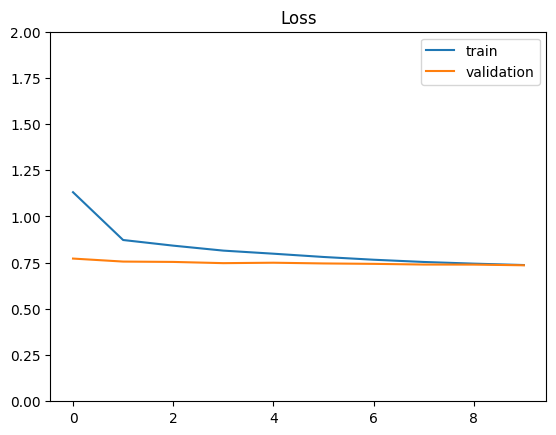

In [54]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [55]:
train_preds = model.predict([user_id_train, item_id_train])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, rating_train))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, rating_train))

   1/2500 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step

  10/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step

  20/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

  30/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step

  41/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step

  51/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

  61/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

  71/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

  81/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

  91/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

 101/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

 111/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

 122/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

 133/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

 144/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

 153/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

 164/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

 174/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

 185/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 195/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 205/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 215/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 225/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 235/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 243/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 252/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 262/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 272/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 282/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 292/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 301/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 310/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 319/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 328/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 338/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 347/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 357/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 366/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 375/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 385/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 394/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 395/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 396/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 405/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 416/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 426/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 436/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 446/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 454/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 463/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

 472/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 483/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 493/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 501/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 511/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 522/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 531/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 541/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 552/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 561/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 572/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 582/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 592/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 601/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 611/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 621/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 632/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 641/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step

 649/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step 

 658/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 668/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 677/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 687/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 696/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 706/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 716/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 725/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 735/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 744/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 755/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 765/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 775/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 785/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 794/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 805/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 814/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 824/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 833/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step

 843/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 851/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 860/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 869/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 880/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 889/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 900/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 910/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 921/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 931/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 942/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 952/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 962/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 973/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 984/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

 994/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

1004/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

1013/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step

1023/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1032/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1042/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1053/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1062/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1073/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1084/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1095/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1106/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1116/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1126/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1136/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1145/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1155/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1166/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1176/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1186/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1195/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step

1205/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1215/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1225/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1235/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1244/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1254/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1263/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1272/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1282/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1293/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1303/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1312/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1322/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1332/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1343/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1354/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1364/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1374/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

1383/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1393/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1402/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1412/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1421/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1431/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1440/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1450/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1459/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1468/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1477/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1487/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1498/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1508/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1519/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1529/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1539/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1549/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1560/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

1569/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1579/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1588/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1598/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1608/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1618/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1628/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1638/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1648/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1659/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1669/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1679/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1689/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1698/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1708/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1717/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1728/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1739/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1749/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

1759/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1769/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1779/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1789/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1800/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1811/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1821/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1831/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1841/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1851/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1861/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1871/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1882/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1892/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1902/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1912/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1922/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1932/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

1942/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

1952/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

1961/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

1971/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

1981/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

1991/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2001/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2009/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2019/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2030/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2040/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2049/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2058/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2067/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2077/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2086/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2096/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2106/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2116/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

2127/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2137/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2147/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2148/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2157/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2166/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2176/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2186/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2196/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2206/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2217/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2228/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2239/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2250/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2259/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2269/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2280/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2291/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2302/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2312/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

2323/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2334/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2345/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2355/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2365/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2375/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2384/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2394/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2404/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2413/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2423/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2433/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2443/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2452/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2462/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2472/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2482/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2492/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step


Final train MSE: 0.831
Final train MAE: 0.703


In [56]:
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

  1/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step

 10/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

 20/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

 29/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

 39/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

 48/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

 58/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

 68/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

 78/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 87/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

 97/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

107/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

118/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

129/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

138/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

147/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

158/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

168/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

179/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

189/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

200/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

211/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

222/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

233/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

242/625 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

253/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

264/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

275/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

285/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

295/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

306/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

317/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

328/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

338/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

348/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

357/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

366/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

375/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

386/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

398/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

409/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

419/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

429/625 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

439/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

449/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

460/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

471/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

481/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

492/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

503/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

513/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

523/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

533/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

543/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

553/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

564/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

575/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

586/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

596/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

607/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

616/625 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


Final test MSE: 0.886
Final test MAE: 0.731


The performance of this model is not necessarily significantly better than the previous model but you can notice that the gap between train and test is lower, probably thanks to the use of dropout.

Furthermore this model is more flexible in the sense that we can extend it to include metadata for hybrid recsys as we will see in the following.

### Home assignment: 
 - Add another layer, compare train/test error.
 - Can you improve the test MAE? 
 - Try adding more dropout and change layer sizes.
 
 
Manual tuning of so many hyperparameters is tedious. In practice it's better to automate the design of the model using an hyperparameter search tool such as:

- https://keras-team.github.io/keras-tuner/ (Keras specific)
- https://optuna.org/ (any machine learning framework, Keras included)

## Using item metadata in the model

Using a similar framework as previously, we will build another deep model that can also leverage additional metadata. The resulting system is therefore an **Hybrid Recommender System** that does both **Collaborative Filtering** and **Content-based recommendations**.

<img src="images/rec_archi_3.svg" style="width: 600px;" />


In [57]:
from sklearn.preprocessing import QuantileTransformer

meta_columns = ['popularity', 'release_year']

scaler = QuantileTransformer()
item_meta_train = scaler.fit_transform(ratings_train[meta_columns])
item_meta_test = scaler.transform(ratings_test[meta_columns])

In [58]:
class HybridModel(Model):

    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding')
        
        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.concat = Concatenate()
        
        self.dense1 = Dense(64, activation="relu")
        self.dropout = Dropout(0.3)
        self.dense2 = Dense(64, activation='relu')
        self.dense3 = Dense(1)
        
    def call(self, inputs, training=False):
        user_inputs = inputs[0]
        item_inputs = inputs[1]
        meta_inputs = inputs[2]

        user_vecs = self.flatten(self.user_embedding(user_inputs))
        user_vecs = self.dropout(user_vecs, training=training)

        item_vecs = self.flatten(self.item_embedding(item_inputs))
        item_vecs = self.dropout(item_vecs, training=training)

        input_vecs = self.concat([user_vecs, item_vecs, meta_inputs])

        y = self.dense1(input_vecs)
        y = self.dropout(y, training=training)
        y = self.dense2(y)
        y = self.dropout(y, training=training)
        y = self.dense3(y)
        return y
        
model = HybridModel(64, max_user_id, max_item_id)
model.compile(optimizer='adam', loss='mae')

initial_train_preds = model.predict([user_id_train,
                                     item_id_train,
                                     item_meta_train])

   1/2500 ━━━━━━━━━━━━━━━━━━━━ 1:18 31ms/step

   9/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step  

  18/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step

  27/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step

/home/rth/src/dl-lectures-labs/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:100: UserWarning:

Argument `input_length` is deprecated. Just remove it.



  35/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step

  43/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step

  50/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step

  58/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step

  67/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step

  76/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step

  85/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step

  93/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step

 102/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step

 111/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step

 120/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step

 129/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step

 137/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step

 146/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step

 154/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step

 163/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step

 172/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step

 180/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step

 188/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step

 196/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step

 205/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step

 214/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step

 223/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step

 232/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step

 241/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step

 249/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step

 258/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 266/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 274/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 282/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 291/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 298/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 306/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 314/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 322/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 331/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 340/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 348/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 357/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 366/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 374/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 382/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 391/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 401/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 408/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 417/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 425/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 433/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step

 441/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 449/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 457/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 465/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 473/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 481/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 490/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 498/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 506/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 514/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 522/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 531/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 540/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 549/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 557/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 566/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 574/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 583/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 591/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step

 599/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

 607/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

 614/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

 623/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

 632/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

 641/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

 650/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

 659/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

 668/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

 677/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

 686/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

 695/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

 703/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

 712/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

 721/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

 730/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

 738/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

 747/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 755/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 764/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 773/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 781/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 789/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 798/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 807/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 815/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 824/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 832/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 840/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 848/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 857/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 865/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 873/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 882/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 891/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 898/2500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step

 907/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step 

 915/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

 924/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

 925/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

 934/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

 943/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

 952/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

 960/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

 968/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

 977/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

 985/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

 993/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

1002/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

1011/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

1018/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

1027/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

1035/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

1043/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

1050/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

1058/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

1066/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step

1073/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1082/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1091/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1099/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1107/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1115/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1123/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1131/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1139/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1146/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1154/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1162/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1171/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1179/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1187/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1194/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1202/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1209/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1217/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1225/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1234/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step

1243/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

1252/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

1261/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

1270/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

1279/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

1288/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

1297/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

1305/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

1313/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

1321/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

1330/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

1339/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

1348/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

1356/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

1364/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

1373/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

1382/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

1391/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step

1400/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1409/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1417/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1426/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1435/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1444/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1453/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1454/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1461/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1470/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1478/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1487/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1495/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1503/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1511/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1519/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1528/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1536/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1544/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step

1551/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

1559/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

1567/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

1575/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

1583/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

1590/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

1599/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

1607/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

1615/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

1624/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

1633/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

1642/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

1647/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

1655/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

1663/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

1671/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

1679/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

1687/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

1696/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

1705/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

1712/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

1721/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

1730/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

1739/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

1747/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

1755/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

1763/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

1771/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

1779/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

1787/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

1796/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

1803/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

1811/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

1819/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

1827/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

1835/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

1844/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

1853/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

1861/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

1869/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

1877/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

1885/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

1894/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

1903/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

1912/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

1921/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

1930/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

1939/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

1948/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

1957/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

1965/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

1973/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

1981/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

1990/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

1999/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

2007/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

2015/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

2023/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

2032/2500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

2041/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2050/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2058/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2066/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2074/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2082/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2090/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2098/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2107/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2116/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2124/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2132/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2141/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2149/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2158/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2166/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2174/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2183/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2191/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

2199/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

2207/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

2215/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

2223/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

2231/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

2238/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

2246/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

2254/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

2262/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

2271/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

2279/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

2287/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

2296/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

2305/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

2313/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

2322/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

2331/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

2340/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

2348/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2356/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2365/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2373/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2382/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2390/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2398/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2406/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2414/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2422/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2430/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2438/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2447/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2457/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2466/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2474/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2482/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2491/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2499/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step


In [59]:
%%time
history = model.fit([user_id_train, item_id_train, item_meta_train],
                    rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 44s 39ms/step - loss: 3.5562

   3/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - loss: 3.6463

   6/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 3.6239

   9/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 3.6068

  11/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - loss: 3.5933

  14/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 3.5696

  16/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 3.5547

  18/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 3.5401

  20/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 3.5271

  23/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 3.5089

  25/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 3.4966

  28/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 3.4798

  31/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 3.4632

  33/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 3.4519

  35/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 3.4401

  38/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 3.4209

  40/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 3.4075

  42/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 3.3931

  44/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 3.3777

  46/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 3.3616

  48/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 3.3448

  51/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 3.3179

  53/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 3.2990

  56/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 3.2694

  58/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 3.2490

  60/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 3.2282

  62/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 3.2072

  64/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 3.1861

  67/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 3.1543

  70/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 3.1227

  72/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 3.1019

  74/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 3.0813

  77/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 3.0510

  79/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 3.0311

  81/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 3.0114

  83/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 2.9921

  86/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 2.9636

  89/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 2.9358

  91/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 2.9177

  95/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.8823

  97/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.8650

 100/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.8396

 103/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.8149

 105/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.7988

 108/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.7751

 110/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.7596

 112/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.7444

 115/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.7220

 117/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.7073

 119/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.6929

 121/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.6788

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.6648

 125/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.6511

 127/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.6377

 130/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 2.6179

 132/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 2.6050

 134/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 2.5923

 137/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 2.5736

 139/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.5614

 141/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.5494

 143/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 2.5376

 145/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - loss: 2.5260

 147/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 2.5146

 149/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - loss: 2.5034

 151/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - loss: 2.4923

 153/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - loss: 2.4814

 156/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - loss: 2.4654

 158/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - loss: 2.4549

 160/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - loss: 2.4445

 163/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - loss: 2.4293

 165/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - loss: 2.4193

 169/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 2.3999

 171/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 2.3904

 173/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 2.3810

 175/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 2.3717

 177/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 2.3626

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 2.3491

 182/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 2.3403

 184/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 2.3316

 186/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 2.3231

 189/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 2.3104

 192/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 2.2981

 194/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 2.2900

 196/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 2.2820

 198/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 2.2741

 200/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 2.2663

 202/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 2.2586

 205/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 2.2472

 207/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 2.2398

 209/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 2.2324

 212/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 2.2216

 214/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 2.2144

 217/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 2.2039

 219/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 2.1970

 221/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 2.1902

 223/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 2.1834

 226/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 2.1734

 229/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 2.1637

 231/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 2.1572

 233/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 2.1508

 236/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 2.1414

 238/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 2.1352

 240/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 2.1291

 242/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 2.1230

 244/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 2.1170

 246/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 2.1111

 248/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 2.1052

 250/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 2.0994

 254/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 2.0880

 257/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 2.0796

 259/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 2.0741

 262/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 2.0659

 264/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 2.0605

 267/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 2.0525

 269/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 2.0473

 272/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 2.0395

 274/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 2.0344

 276/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 2.0294

 279/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 2.0219

 281/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 2.0169

 284/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 2.0096

 286/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 2.0048

 288/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 2.0000

 291/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 1.9929

 293/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 1.9883

 297/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 1.9791

 300/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 1.9723

 302/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 1.9678

 304/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 1.9634

 306/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 1.9590

 308/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 1.9547

 310/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 1.9504

 313/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 1.9440

 315/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 1.9398

 317/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 1.9356

 320/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 1.9294

 322/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 1.9254

 326/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 1.9173

 329/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 1.9114

 332/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 1.9055

 335/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 1.8997

 337/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 1.8959

 339/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 1.8921

 342/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 1.8864

 345/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 1.8809

 348/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 1.8754

 350/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 1.8718

 352/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 1.8682

 354/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 1.8646

 357/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 1.8593

 360/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 1.8541

 362/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 1.8507

 365/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 1.8455

 367/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 1.8422

 369/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 1.8388

 371/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 1.8355

 373/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 1.8322

 375/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 1.8289

 377/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 1.8257

 379/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 1.8225

 381/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 1.8193

 384/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 1.8145

 387/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 1.8099

 389/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 1.8068

 392/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 1.8022

 395/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 1.7976

 397/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 1.7946

 400/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 1.7902

 402/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 1.7872

 405/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 1.7828

 407/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 1.7799

 410/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 1.7756

 413/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 1.7714

 416/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 1.7672

 418/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 1.7644

 421/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 1.7603

 423/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 1.7575

 425/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 1.7548

 427/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 1.7521

 430/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 1.7481

 432/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 1.7455

 435/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 1.7415

 438/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 1.7376

 440/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 1.7350

 443/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 1.7312

 445/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 1.7287

 447/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 1.7262

 450/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 1.7224

 452/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 1.7199

 454/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 1.7175

 457/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 1.7138

 459/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 1.7114

 462/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 1.7078

 465/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 1.7043

 467/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 1.7019

 470/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 1.6984

 473/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 1.6949

 476/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 1.6915

 479/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 1.6881

 481/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 1.6858

 484/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 1.6825

 486/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 1.6803

 489/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 1.6770

 492/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 1.6737

 494/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 1.6716

 497/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 1.6683

 500/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 1.6652

 502/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6631

 505/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6599

 507/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6578

 509/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6558

 512/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6527

 514/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6507

 518/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6467

 520/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6447

 523/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6417

 524/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6407

 526/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6388

 528/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6368

 530/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6349

 532/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6330

 534/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6310

 536/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6291

 538/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6273

 540/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6254

 542/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 1.6235

 544/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 1.6216

 546/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 1.6198

 550/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 1.6161

 552/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 1.6143

 555/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 1.6116

 557/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 1.6098

 559/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 1.6080

 561/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 1.6063

 564/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 1.6036

 567/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 1.6010

 569/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 1.5993

 572/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 1.5967

 575/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 1.5942

 577/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 1.5925

 580/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 1.5899

 582/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 1.5883

 584/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 1.5866

 586/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 1.5850

 588/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 1.5833

 590/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 1.5817

 592/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 1.5801

 595/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 1.5776

 597/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 1.5760

 600/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 1.5736

 603/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 1.5713

 605/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 1.5697

 608/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 1.5674

 611/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 1.5650

 613/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 1.5635

 616/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 1.5612

 618/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 1.5597

 621/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 1.5574

 623/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 1.5559

 625/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 1.5544

 629/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 1.5515

 632/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 1.5493

 635/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 1.5471

 637/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 1.5456

 639/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 1.5442

 641/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 1.5428

 643/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 1.5413

 645/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 1.5399

 647/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 1.5385

 649/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 1.5371

 652/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 1.5350

 654/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 1.5336

 657/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 1.5316

 659/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.5302

 661/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.5288

 664/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.5268

 666/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.5254

 669/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.5234

 671/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.5221

 673/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.5207

 676/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.5188

 679/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.5168

 681/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.5155

 684/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.5135

 686/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.5122

 688/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.5109

 691/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.5090

 693/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.5078

 695/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.5065

 697/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.5052

 699/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.5040

 702/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.5021

 704/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.5009

 706/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.4996

 708/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.4984

 710/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.4972

 712/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.4959

 714/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.4947

 716/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.4935

 718/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.4923

 720/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.4911

 722/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.4899

 724/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.4887

 727/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.4870

 729/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.4858

 732/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.4840

 735/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 1.4823

 737/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1.4811 

 740/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1.4794

 742/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1.4783

 746/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1.4760

 748/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1.4749

 750/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1.4738

 752/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1.4726

 754/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1.4715

 756/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1.4704

 758/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1.4693

 761/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1.4677

 763/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1.4666

 765/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1.4655

 767/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1.4644

 769/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1.4633

 771/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1.4622

 773/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 1.4612

 775/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.4601

 777/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.4590

 779/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.4580

 781/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.4569

 783/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.4559

 786/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.4543

 788/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.4533

 791/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.4517

 794/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.4502

 796/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.4491

 798/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.4481

 800/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.4471

 803/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.4456

 805/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.4446

 808/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.4431

 810/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.4421

 814/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 1.4401

 817/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 1.4386

 820/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 1.4372

 823/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 1.4357

 826/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 1.4343

 828/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 1.4333

 830/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 1.4323

 832/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 1.4314

 834/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 1.4304

 836/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 1.4295

 838/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 1.4286

 840/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 1.4276

 842/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 1.4267

 845/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 1.4253

 848/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 1.4239

 850/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 1.4230

 852/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 1.4221

 854/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.4212

 856/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.4202

 859/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.4189

 861/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.4180

 864/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.4166

 866/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.4157

 869/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.4144

 871/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.4135

 873/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.4126

 876/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.4113

 879/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.4100

 881/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.4091

 884/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.4078

 886/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.4070

 888/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.4061

 891/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.4048

 894/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.4036

 897/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.4023

 899/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.4014

 901/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.4006

 903/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.3998

 906/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.3985

 908/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.3977

 910/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.3969

 913/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.3956

 916/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.3944

 918/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.3936

 920/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.3928

 922/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.3920

 925/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.3908

 928/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.3896

 930/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1.3888

 932/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.3880

 934/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.3872

 937/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.3860

 939/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.3852

 941/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.3844

 943/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.3836

 946/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.3825

 948/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.3817

 950/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.3809

 952/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.3802

 955/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.3790

 957/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.3782

 960/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.3771

 963/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.3760

 965/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.3752

 968/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.3741

 971/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.3730

 974/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.3718

 977/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.3707

 980/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.3696

 982/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.3689

 984/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.3682

 986/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.3675

 988/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.3667

 990/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.3660

 992/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.3653

 996/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.3638

 999/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.3628

1001/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.3621

1004/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.3610

1006/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.3603

1009/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.3592

1011/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.3585

1015/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.3572

1017/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.3565

1020/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.3554

1023/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.3544

1025/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.3537

1027/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.3530

1029/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.3523

1031/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.3517

1034/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.3506

1037/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.3496

1040/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.3486

1042/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.3480

1045/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.3470

1047/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.3463

1049/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.3456

1051/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.3450

1053/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.3443

1055/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.3437

1057/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.3430

1059/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.3424

1061/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.3417

1064/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.3407

1066/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.3401

1068/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.3395

1072/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.3382

1074/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.3375

1076/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.3369

1078/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.3363

1081/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.3353

1083/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.3347

1086/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.3337

1089/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3328

1091/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3322

1093/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3316

1095/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3310

1097/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3303

1100/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3294

1103/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3285

1106/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3276

1108/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3270

1110/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3264

1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3258

1114/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3252

1116/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3246

1119/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3237

1121/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3231

1123/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3225

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3219

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - loss: 0.9902 - val_loss: 0.7615


Epoch 2/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - loss: 0.8546

   3/1125 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - loss: 0.8294

   5/1125 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - loss: 0.8461

   7/1125 ━━━━━━━━━━━━━━━━━━━━ 36s 32ms/step - loss: 0.8578

   9/1125 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - loss: 0.8603

  11/1125 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - loss: 0.8611

  14/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - loss: 0.8633

  16/1125 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 0.8649

  18/1125 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 0.8652

  20/1125 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 0.8647

  22/1125 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 0.8638

  25/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - loss: 0.8623

  28/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.8608

  30/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.8598

  32/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.8586

  34/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.8575

  37/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.8563

  39/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.8553

  41/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.8545

  44/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.8533

  46/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.8527

  49/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.8518

  51/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.8512

  53/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.8506

  55/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.8502

  57/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.8498

  59/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.8495

  61/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.8493

  63/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.8491

  65/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.8489

  67/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.8488

  69/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.8486

  71/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.8484

  73/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.8483

  75/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.8481

  78/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.8479

  80/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.8477

  83/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.8475

  86/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.8472

  88/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.8470

  91/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.8467

  93/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.8465

  95/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.8463

  97/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.8461

 100/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.8458

 102/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.8456

 104/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.8454

 106/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.8452

 109/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.8449

 111/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.8447

 114/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.8444

 116/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.8443

 118/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.8441

 120/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.8440

 122/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.8438

 125/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.8436

 127/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.8435

 129/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.8433

 131/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.8432

 133/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.8431

 135/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.8430

 138/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.8428

 141/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.8427

 143/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.8426

 146/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.8426

 148/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.8425

 151/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.8424

 153/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.8423

 155/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.8422

 157/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.8421

 159/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.8420

 162/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.8419

 164/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.8417

 167/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.8416

 169/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.8415

 172/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.8413

 175/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.8412

 177/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.8410

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.8409

 182/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.8408

 185/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.8407

 188/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.8405

 190/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.8404

 193/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.8403

 196/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.8401

 198/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.8400

 201/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.8399

 203/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.8399

 205/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.8398

 208/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.8396

 210/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.8396

 213/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.8394

 215/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.8394

 217/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.8393

 219/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.8392

 222/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.8391

 224/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.8391

 227/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.8390

 230/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.8389

 232/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.8388

 235/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.8387

 238/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.8386

 241/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.8385

 244/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.8385

 246/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.8384

 248/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.8383

 250/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.8383

 253/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.8382

 256/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.8381

 258/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.8381

 260/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.8380

 262/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.8380

 264/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.8379

 267/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.8379

 269/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.8378

 272/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.8378

 275/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.8377

 277/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.8377

 281/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.8376

 283/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.8376

 286/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.8375

 288/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.8375

 290/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.8374

 293/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.8374

 295/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.8374

 298/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.8373

 301/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.8373

 303/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.8372

 305/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.8372

 307/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.8372

 310/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.8371

 312/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.8371

 314/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.8370

 316/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.8370

 318/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.8370

 321/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.8369

 324/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.8368

 326/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.8368

 329/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.8367

 331/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.8367

 333/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.8367

 335/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.8366

 337/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.8366

 339/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.8365

 342/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.8365

 344/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.8364

 346/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.8364

 348/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.8364

 350/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.8363

 352/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.8363

 354/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.8363

 356/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.8362

 359/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.8362

 361/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.8361

 365/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.8361

 368/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.8360

 370/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.8360

 372/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.8359

 374/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.8359

 377/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.8358

 380/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.8358

 383/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.8357

 385/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.8357

 387/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.8356

 390/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.8356

 392/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.8356

 394/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.8355

 397/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.8355

 399/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.8354

 402/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.8354

 404/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.8354

 406/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.8353

 408/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.8353

 410/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.8353

 412/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.8352

 415/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.8352

 417/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.8352

 419/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.8352

 422/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.8351

 425/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.8351

 427/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.8351

 430/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.8350

 432/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.8350

 435/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.8350

 437/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.8349

 441/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.8349

 443/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.8349

 445/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.8348

 447/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.8348

 449/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.8348

 452/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.8347

 454/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.8347

 457/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.8347

 460/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.8346

 463/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.8346

 466/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.8346

 468/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.8346

 471/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.8345

 474/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.8345

 476/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.8345

 479/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.8344

 481/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.8344

 484/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.8344

 487/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.8344

 489/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.8343

 492/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.8343

 494/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.8343

 496/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.8343

 499/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.8342

 501/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.8342

 503/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.8342

 505/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.8342

 507/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.8342

 510/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.8341

 512/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.8341

 515/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.8341

 518/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.8341

 520/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.8341

 523/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.8341

 525/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.8340

 528/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.8340

 530/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.8340

 532/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.8340

 535/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.8340

 537/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.8339

 538/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.8339

 540/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.8339

 542/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.8339

 544/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.8339

 548/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.8339

 551/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.8338

 554/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.8338

 556/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.8338

 559/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.8338

 562/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.8338

 564/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.8337

 566/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.8337

 570/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.8337

 572/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.8337

 575/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.8337

 577/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8337

 579/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8336

 582/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8336

 584/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8336

 586/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8336

 588/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8336

 590/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8336

 592/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8336

 594/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8336

 597/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8335

 599/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8335

 601/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8335

 603/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8335

 605/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8335

 607/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8335

 609/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8335

 612/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8334

 615/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8334

 617/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.8334

 620/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.8334

 622/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.8334

 624/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.8334

 626/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.8334

 628/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.8334

 630/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.8333

 632/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.8333

 635/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.8333

 637/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.8333

 640/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.8333

 643/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.8333

 645/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.8333

 648/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.8333

 650/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.8332

 652/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.8332

 654/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.8332

 656/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.8332

 658/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.8332

 660/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.8332

 663/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.8332

 665/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.8332

 668/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.8332

 670/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.8332

 673/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.8331

 675/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.8331

 678/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.8331

 680/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.8331

 683/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.8331

 685/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.8331

 687/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.8331

 690/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.8331

 692/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.8330

 696/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.8330

 698/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.8330

 701/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.8330

 703/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.8330

 706/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.8330

 708/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.8330

 711/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.8330

 713/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.8330

 715/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.8330

 717/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.8330

 719/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.8329

 721/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.8329

 723/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.8329

 725/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.8329

 728/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.8329

 730/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.8329

 732/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.8329

 734/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.8329

 736/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8329 

 740/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8329

 742/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8329

 745/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8329

 747/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8329

 749/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8328

 751/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8328

 753/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8328

 756/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8328

 758/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8328

 760/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8328

 762/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8328

 764/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8328

 766/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8328

 768/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8328

 771/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8328

 773/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.8328

 776/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.8328

 779/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.8327

 781/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.8327

 784/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.8327

 786/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.8327

 788/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.8327

 791/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.8327

 793/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.8327

 796/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.8327

 798/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.8327

 800/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.8327

 802/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.8327

 805/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.8327

 808/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.8327

 810/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.8327

 813/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8326

 815/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8326

 818/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8326

 820/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8326

 822/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8326

 824/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8326

 826/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8326

 829/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8326

 831/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8326

 833/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8326

 835/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8326

 837/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8326

 839/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8326

 841/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8326

 843/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8326

 845/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8326

 848/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8325

 850/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8325

 852/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8325

 854/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.8325

 856/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.8325

 859/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.8325

 861/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.8325

 863/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.8325

 865/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.8325

 867/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.8325

 869/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.8325

 871/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.8325

 873/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.8325

 876/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.8324

 879/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.8324

 881/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.8324

 884/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.8324

 887/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.8324

 889/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.8324

 892/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8324

 894/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8324

 896/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8324

 898/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8324

 900/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8324

 903/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8323

 905/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8323

 907/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8323

 909/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8323

 911/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8323

 914/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8323

 916/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8323

 918/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8323

 920/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8323

 923/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8323

 925/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8322

 928/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8322

 930/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.8322

 933/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.8322

 935/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.8322

 937/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.8322

 940/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.8322

 942/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.8322

 945/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.8322

 947/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.8322

 949/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.8322

 951/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.8321

 954/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.8321

 957/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.8321

 960/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.8321

 963/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.8321

 965/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.8321

 968/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.8321

 971/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.8320

 974/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.8320

 976/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.8320

 978/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.8320

 980/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.8320

 982/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.8320

 986/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.8320

 989/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.8320

 991/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.8320

 994/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.8319

 996/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.8319

 998/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.8319

1000/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.8319

1002/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.8319

1004/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.8319

1006/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.8319

1009/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8319

1011/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8319

1014/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8318

1016/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8318

1018/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8318

1020/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8318

1022/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8318

1025/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8318

1027/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8318

1029/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8318

1031/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8318

1033/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8318

1036/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8317

1038/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8317

1040/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8317

1042/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8317

1045/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8317

1047/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.8317

1049/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8317

1052/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8317

1055/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8317

1058/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8317

1061/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8316

1063/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8316

1066/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8316

1069/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8316

1071/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8316

1074/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8316

1077/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8316

1079/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8316

1081/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8316

1083/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8316

1087/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8315

1089/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8315

1092/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8315

1094/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8315

1096/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8315

1099/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8315

1101/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8315

1104/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8315

1106/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8315

1108/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8315

1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8315

1114/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8314

1116/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8314

1118/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8314

1120/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8314

1122/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8314

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8314

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - loss: 0.8273 - val_loss: 0.7556


Epoch 3/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - loss: 0.7727

   3/1125 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - loss: 0.8164

   5/1125 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 0.8225

   7/1125 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - loss: 0.8219

  10/1125 ━━━━━━━━━━━━━━━━━━━━ 32s 30ms/step - loss: 0.8226

  13/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.8251

  16/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - loss: 0.8230

  18/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - loss: 0.8217

  20/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.8202

  22/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.8189

  24/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.8182

  26/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.8177

  30/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.8165

  32/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.8160

  34/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.8156

  37/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.8150

  39/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.8146

  42/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.8139

  44/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.8135

  47/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.8129

  49/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.8125

  51/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.8121

  53/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.8118

  55/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.8116

  58/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.8111

  61/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.8107

  63/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.8104

  66/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.8100

  69/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.8095

  72/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.8091

  75/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.8088

  77/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.8087

  80/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.8085

  82/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.8084

  84/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.8083

  86/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.8082

  89/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.8080

  91/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.8079

  94/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.8078

  97/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.8077

  99/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.8076

 101/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.8075

 103/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.8075

 106/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.8074

 108/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.8074

 111/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.8074

 114/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.8074

 116/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.8074

 119/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.8074

 121/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.8074

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.8074

 126/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.8074

 128/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.8074

 131/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.8074

 134/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.8074

 136/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.8074

 139/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.8073

 142/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.8073

 144/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.8073

 146/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.8072

 148/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.8072

 151/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.8072

 153/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.8071

 155/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.8071

 158/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.8071

 160/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.8071

 163/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.8071

 166/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.8071

 169/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.8071

 172/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.8071

 174/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.8071

 177/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.8071

 179/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.8071

 181/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.8071

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.8071

 186/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.8071

 190/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.8071

 192/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.8071

 195/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.8071

 198/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.8072

 200/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.8072

 203/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.8072

 205/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.8072

 208/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.8073

 210/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.8073

 213/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.8074

 216/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.8074

 218/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.8074

 221/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.8075

 223/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.8075

 226/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.8075

 230/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.8075

 232/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.8075

 234/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.8075

 237/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.8075

 239/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.8075

 243/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.8075

 245/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.8075

 249/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.8074

 251/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.8074

 254/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.8074

 256/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.8074

 258/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.8073

 261/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.8073

 263/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.8073

 265/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.8072

 267/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.8072

 269/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.8072

 273/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.8071

 275/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.8070

 278/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.8070

 280/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.8069

 283/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.8069

 286/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.8068

 288/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.8068

 290/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.8068

 293/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.8067

 295/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.8067

 298/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.8066

 300/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.8066

 303/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.8066

 305/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.8065

 308/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.8065

 310/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.8064

 312/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.8064

 315/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.8063

 317/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.8063

 319/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.8063

 321/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.8062

 324/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.8062

 326/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.8062

 329/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.8061

 331/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.8061

 333/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.8061

 336/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.8060

 339/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.8060

 342/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.8060

 346/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.8060

 348/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.8059

 351/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.8059

 354/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.8059

 357/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.8058

 360/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.8058

 363/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.8058

 365/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.8058

 368/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.8057

 371/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.8057

 374/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.8057

 377/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.8057

 380/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.8056

 382/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.8056

 385/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.8056

 388/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.8056

 390/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.8056

 392/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8056

 394/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8055

 397/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8055

 399/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8055

 401/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8055

 404/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8055

 406/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8055

 408/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8054

 409/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8054

 411/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8054

 413/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8054

 415/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8054

 418/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8054

 420/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8053

 422/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8053

 425/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8053

 427/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8053

 429/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8053

 431/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8053

 434/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8052

 436/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8052

 438/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8052

 440/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8052

 442/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.8052

 445/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.8052

 448/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.8051

 451/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.8051

 455/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.8051

 458/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.8051

 460/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.8051

 462/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.8050

 464/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.8050

 467/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.8050

 470/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.8050

 472/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.8050

 475/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.8050

 477/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.8049

 480/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.8049

 482/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.8049

 485/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.8049

 487/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.8049

 489/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.8048

 491/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.8048

 494/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.8048

 496/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.8048

 498/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.8048

 501/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.8048

 503/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.8048

 505/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.8048

 508/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.8047

 510/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.8047

 513/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.8047

 516/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.8047

 519/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.8047

 521/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.8047

 523/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.8047

 525/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.8047

 527/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.8047

 529/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.8047

 531/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.8047

 533/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.8046

 535/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.8046

 537/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.8046

 540/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.8046

 543/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.8046

 545/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.8046

 547/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.8046

 550/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.8046

 552/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.8046

 555/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.8045

 558/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.8045

 561/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.8045

 564/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.8045

 566/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.8045

 568/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.8045

 570/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.8045

 573/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.8045

 575/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.8045

 577/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.8044

 580/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.8044

 582/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.8044

 584/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.8044

 586/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.8044

 588/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.8044

 591/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.8044

 594/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.8044

 597/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.8044

 600/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.8043

 603/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.8043

 605/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.8043

 608/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.8043

 610/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.8043

 612/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.8043

 615/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.8043

 617/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.8043

 620/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.8043

 622/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.8043

 624/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.8042

 627/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.8042

 629/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.8042

 632/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.8042

 634/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.8042

 637/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.8042

 640/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.8042

 642/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.8042

 644/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.8042

 646/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.8042

 649/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.8042

 651/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.8042

 655/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.8041

 657/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.8041

 660/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.8041

 663/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.8041

 665/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.8041

 667/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.8041

 669/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.8041

 672/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.8041

 674/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.8041

 677/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.8041

 680/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.8041

 683/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8041

 686/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8041

 688/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 690/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 693/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 695/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 697/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 699/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 701/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 703/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 705/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 707/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 709/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 711/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 713/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 715/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 717/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 719/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 721/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 723/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 724/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.8040

 726/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.8040 

 728/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.8040

 730/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.8040

 732/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.8040

 735/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.8040

 737/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.8040

 739/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.8040

 741/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.8040

 743/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.8040

 745/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.8040

 747/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.8040

 749/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.8040

 751/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.8040

 753/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.8040

 756/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.8040

 759/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.8040

 761/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.8040

 763/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.8040

 766/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8040

 768/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8040

 770/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8040

 772/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8040

 775/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8040

 777/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8040

 779/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8040

 783/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8040

 785/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8040

 788/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8040

 791/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8040

 793/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8040

 795/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8040

 797/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8040

 799/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8040

 801/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8040

 803/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8040

 806/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.8040

 808/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.8040

 811/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.8040

 813/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.8040

 816/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.8040

 818/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.8040

 821/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.8040

 823/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.8040

 825/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.8040

 827/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.8040

 830/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.8040

 832/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.8040

 834/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.8039

 837/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.8039

 839/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.8039

 842/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.8039

 844/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.8039

 847/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8039

 850/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8039

 853/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8039

 855/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8039

 857/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8039

 860/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8039

 862/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8039

 864/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8039

 866/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8039

 868/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8039

 870/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8039

 872/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8039

 875/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8039

 877/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8039

 879/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8039

 881/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8039

 884/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8039

 886/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 888/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 890/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 892/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 894/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 896/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 899/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 901/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 903/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 905/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 907/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 909/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 911/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 913/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 915/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 918/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 920/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 923/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 925/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.8039

 928/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8039

 931/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8039

 933/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8039

 936/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8039

 938/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8039

 941/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8039

 943/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8039

 946/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8039

 949/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8039

 952/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8039

 955/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8039

 957/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8039

 959/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8039

 962/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8038

 965/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8038

 967/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.8038

 969/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.8038

 972/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.8038

 974/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.8038

 978/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.8038

 980/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.8038

 983/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.8038

 987/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.8038

 990/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.8038

 993/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.8038

 996/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.8038

 998/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.8038

1000/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.8038

1002/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.8038

1005/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1007/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1009/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1011/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1013/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1016/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1019/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1021/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1023/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1025/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1027/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1029/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1030/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1032/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1034/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1036/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1039/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1041/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1043/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8038

1046/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8038

1048/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8037

1051/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8037

1053/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8037

1056/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8037

1059/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8037

1061/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8037

1064/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8037

1066/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8037

1069/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8037

1072/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8037

1074/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8037

1076/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8037

1079/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8037

1081/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8037

1083/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8037

1085/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8037

1088/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8037

1090/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8037

1092/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8037

1094/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8037

1097/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8037

1099/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8037

1102/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8037

1105/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8037

1107/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8037

1110/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8036

1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8036

1115/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8036

1117/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8036

1119/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8036

1122/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8036

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8036

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - loss: 0.8011 - val_loss: 0.7409


Epoch 4/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.7609

   3/1125 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - loss: 0.7523

   6/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - loss: 0.7690

   8/1125 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 0.7729

  10/1125 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 0.7776

  12/1125 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 0.7824

  14/1125 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - loss: 0.7843

  16/1125 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - loss: 0.7844

  18/1125 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - loss: 0.7844

  20/1125 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - loss: 0.7839

  22/1125 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - loss: 0.7835

  24/1125 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - loss: 0.7832

  26/1125 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - loss: 0.7829

  28/1125 ━━━━━━━━━━━━━━━━━━━━ 34s 32ms/step - loss: 0.7824

  31/1125 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - loss: 0.7820

  34/1125 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 0.7817

  37/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - loss: 0.7813

  40/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - loss: 0.7811

  43/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7808

  46/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7805

  49/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7801

  52/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7798

  54/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7796

  58/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7792

  62/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7788

  65/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7784

  68/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7782

  71/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7782

  73/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7781

  76/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7781

  79/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.7781

  82/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.7781

  84/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.7781

  86/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.7780

  89/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.7780

  92/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.7779

  95/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 0.7779

  98/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 0.7779

 101/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 0.7780

 104/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 0.7780

 108/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7779

 112/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7779

 114/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7778

 118/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7778

 121/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.7778

 124/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7778

 126/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7778

 129/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7778

 131/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7778

 134/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7779

 137/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7780

 139/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7780

 141/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7780

 143/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7781

 146/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7782

 148/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7782

 150/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7783

 152/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7784

 154/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7785

 156/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.7785

 158/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7786

 160/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7787

 162/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7787

 164/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7787

 167/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7788

 169/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7789

 171/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7790

 173/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7790

 175/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7791

 177/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7791

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7792

 182/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7793

 184/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7794

 186/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - loss: 0.7794

 188/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7795

 191/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - loss: 0.7796

 193/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7796

 196/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7797

 198/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7798

 201/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7798

 203/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7799

 205/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7799

 207/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7800

 210/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7800

 212/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7801

 214/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7801

 216/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7802

 218/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7802

 220/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7802

 222/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7803

 224/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7803

 226/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7804

 228/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7804

 231/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7805

 233/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7805

 235/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7806

 237/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7806

 239/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7806

 241/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7807

 244/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7807

 246/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7807

 248/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7808

 250/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7808

 252/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7808

 254/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7809

 256/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7809

 258/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7809

 261/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7810

 264/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7810

 266/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7811

 268/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7811

 270/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7812

 272/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7812

 274/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7812

 276/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7813

 279/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7813

 281/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7814

 283/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7814

 285/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7814

 288/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7815

 290/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7815

 292/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7816

 294/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7816

 297/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7817

 301/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7817

 303/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7817

 306/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7818

 308/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7818

 310/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7818

 313/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7819

 315/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7819

 318/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7819

 320/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7819

 323/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7819

 326/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7820

 328/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7820

 331/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7820

 333/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7820

 335/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7820

 337/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7820

 339/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7820

 342/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7821

 344/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7821

 347/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7821

 349/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7821

 352/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7821

 355/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7821

 357/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7821

 360/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7822

 363/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7822

 365/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7822

 367/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7822

 369/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7822

 372/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7822

 374/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7822

 376/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7823

 378/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7823

 381/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7823

 383/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7823

 385/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7823

 387/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7823

 389/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7823

 392/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7823

 394/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7824

 396/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7824

 398/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7824

 401/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7824

 404/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7824

 406/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7824

 408/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7825

 410/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7825

 413/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7825

 415/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7825

 418/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7825

 420/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7825

 423/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7825

 425/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7825

 427/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7826

 430/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7826

 432/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7826

 435/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7826

 437/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7826

 439/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7826

 441/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7826

 443/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7826

 445/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7826

 448/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7826

 450/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7826

 452/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7827

 455/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7827

 457/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7827

 460/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7827

 462/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7827

 465/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7827

 467/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7827

 469/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7828

 472/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7828

 474/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7828

 477/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7828

 479/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7828

 481/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7828

 483/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7828

 486/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7828

 488/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7828

 490/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7828

 492/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7828

 494/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7828

 496/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7828

 498/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7828

 500/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7828

 502/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7829

 504/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7829

 508/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7829

 510/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7829

 512/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7829

 515/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7829

 517/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7829

 520/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7829

 522/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7829

 524/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7829

 526/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7829

 528/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7829

 531/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7830

 534/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7830

 536/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7830

 538/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7830

 540/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7830

 542/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7830

 545/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7830

 547/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7830

 549/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7830

 551/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7830

 553/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7830

 556/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7830

 558/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7830

 560/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7830

 562/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7830

 565/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7830

 567/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7830

 570/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7830

 572/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7830

 574/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7830

 577/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7830

 579/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7830

 582/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7830

 584/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7830

 587/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7830

 590/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7830

 592/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7830

 594/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7830

 597/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7830

 599/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7830

 602/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7830

 605/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7830

 607/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7830

 610/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7830

 613/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7830

 615/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7830

 618/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7830

 620/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7830

 622/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7830

 624/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7830

 627/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7830

 629/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7830

 631/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7830

 634/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7830

 636/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7830

 638/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7829

 640/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7829

 642/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7829

 645/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7829

 647/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7829

 649/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7829

 651/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7829

 654/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7829

 656/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7829

 659/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7829

 662/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7829

 664/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7829

 666/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7829

 668/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7829

 671/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7829

 673/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7829

 675/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7829

 678/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7829

 680/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7828

 682/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7828

 684/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7828

 686/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7828

 689/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7828

 691/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7828

 693/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7828

 696/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7828

 698/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7828

 700/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7828

 703/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7828

 706/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7828

 709/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7828

 711/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7827

 713/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7827

 715/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7827

 718/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7827

 720/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7827

 722/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7827

 724/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7827

 727/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7827

 730/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7827

 732/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7827

 734/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7827

 736/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7827 

 739/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7827

 742/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7827

 744/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7827

 747/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7827

 749/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7826

 752/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7826

 754/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7826

 756/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7826

 759/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7826

 762/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7826

 764/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7826

 766/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7826

 769/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7826

 772/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7826

 774/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7826

 776/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7826

 778/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7826

 780/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7826

 782/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7826

 785/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7826

 788/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7826

 790/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7826

 792/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7825

 794/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7825

 796/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7825

 799/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7825

 801/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7825

 804/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7825

 806/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7825

 809/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7825

 811/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7825

 813/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7825

 815/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7825

 817/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7825

 820/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7825

 822/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7825

 824/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7825

 827/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7825

 829/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7825

 832/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7825

 834/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7825

 837/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7825

 839/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7825

 842/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7825

 844/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7825

 847/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7825

 851/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7825

 853/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7824

 856/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7824

 858/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7824

 861/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7824

 864/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7824

 866/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7824

 868/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7824

 870/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7824

 872/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7824

 874/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7824

 876/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7824

 878/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7824

 880/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7824

 882/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7824

 884/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7824

 886/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7824

 889/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7824

 891/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7824

 895/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7824

 898/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7824

 901/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7824

 904/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7824

 906/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7824

 909/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7824

 911/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7824

 913/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7824

 916/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7824

 918/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7824

 922/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7824

 924/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7824

 927/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7824

 931/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7824

 933/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7824

 937/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7824

 940/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7823

 943/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7823

 946/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7823

 948/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7823

 951/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7823

 953/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7823

 955/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7823

 957/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7823

 959/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7823

 962/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7823

 964/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7823

 967/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7823

 969/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7823

 971/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7823

 974/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7823

 977/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7823

 980/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7823

 982/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7823

 985/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7823

 987/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7823

 989/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7823

 991/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7823

 993/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7823

 996/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7823

 998/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7823

1000/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7823

1002/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7823

1005/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7823

1007/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7823

1009/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7823

1012/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7823

1014/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7823

1017/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7823

1019/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7823

1021/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7823

1024/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7823

1026/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7823

1028/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7823

1030/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7823

1032/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7823

1034/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7823

1037/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7823

1039/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7823

1042/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7823

1045/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7823

1047/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7823

1050/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7823

1052/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7823

1055/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7823

1057/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7823

1060/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7823

1063/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7823

1066/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7823

1069/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7823

1071/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7822

1073/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7822

1076/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7822

1078/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7822

1080/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7822

1082/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7822

1085/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7822

1087/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7822

1089/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7822

1091/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7822

1094/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7822

1096/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7822

1099/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7822

1101/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7822

1103/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7822

1105/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7822

1107/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7822

1109/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7822

1111/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7822

1113/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7822

1116/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7822

1118/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7822

1121/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7822

1123/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7822

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7822

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - loss: 0.7804 - val_loss: 0.7395


Epoch 5/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 39s 35ms/step - loss: 0.7421

   4/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 0.7087

   7/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 0.7128

   9/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 0.7151

  11/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - loss: 0.7142

  14/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 0.7136

  16/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7137

  19/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 0.7142

  21/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7146

  23/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7151

  25/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7157

  28/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7168

  31/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 0.7183

  33/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 0.7193

  36/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 0.7208

  38/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7217

  40/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7226

  43/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7242

  45/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7252

  48/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7267

  50/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7277

  53/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7291

  56/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7303

  58/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7311

  60/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7319

  62/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7328

  64/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7337

  66/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7346

  69/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7357

  71/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7365

  74/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7374

  76/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7380

  78/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7385

  80/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7391

  82/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7395

  85/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7401

  88/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7407

  91/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7414

  93/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7418

  96/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7424

 100/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7431

 102/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7434

 105/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7439

 107/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7442

 109/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7446

 112/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7450

 114/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7453

 116/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7456

 118/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7459

 120/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7461

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7465

 126/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7468

 128/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7470

 131/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7473

 133/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7475

 135/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7477

 137/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7479

 140/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7482

 143/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7484

 146/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7486

 148/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7488

 151/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7489

 153/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7491

 155/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7492

 158/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7494

 160/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7495

 163/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7496

 165/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7497

 167/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7498

 169/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7499

 172/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7501

 174/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7502

 176/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7503

 179/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7505

 181/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7506

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7507

 185/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7508

 188/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7509

 191/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7511

 193/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7512

 195/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7513

 197/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7514

 200/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7515

 203/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7516

 205/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7517

 209/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7518

 211/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7519

 214/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7520

 216/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7521

 218/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7521

 220/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7522

 223/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7523

 226/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7523

 228/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7524

 230/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7524

 232/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7525

 235/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7525

 237/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7526

 240/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7526

 243/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7527

 245/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7527

 248/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7528

 250/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7528

 253/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7529

 256/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7530

 259/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7530

 261/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7531

 263/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7531

 266/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7532

 269/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7532

 271/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7532

 274/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7533

 276/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7534

 279/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7534

 281/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7535

 284/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7535

 288/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7536

 290/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7536

 292/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7537

 295/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7537

 297/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7537

 299/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7538

 301/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7538

 303/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7538

 305/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7539

 308/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7539

 310/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7539

 312/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7539

 314/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7540

 316/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7540

 318/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7540

 320/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7541

 323/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7541

 326/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7542

 328/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7542

 330/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7542

 332/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7543

 334/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7543

 336/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7543

 339/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7544

 342/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7544

 345/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7545

 347/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7545

 349/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7545

 351/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7546

 353/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7546

 355/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7546

 358/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7547

 361/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7547

 363/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7547

 366/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7548

 369/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7548

 371/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7549

 375/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7549

 377/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7550

 379/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7550

 382/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7550

 384/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7551

 387/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7551

 389/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7551

 391/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7552

 394/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7552

 396/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7552

 399/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7553

 401/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7553

 403/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7554

 405/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7554

 407/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7554

 409/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7554

 412/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7555

 414/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7555

 417/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7556

 419/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7556

 422/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7556

 424/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7557

 426/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7557

 429/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7558

 431/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7558

 433/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7558

 435/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7559

 438/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7559

 441/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7560

 443/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7560

 445/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7560

 447/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7560

 450/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7561

 453/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7561

 456/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7562

 459/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7562

 461/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7563

 464/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7563

 466/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7563

 468/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7564

 471/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7564

 473/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7564

 476/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7565

 479/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7565

 481/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7566

 484/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.7566

 487/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.7566

 489/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.7567

 492/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.7567

 495/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.7567

 497/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.7568

 500/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.7568

 502/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.7568

 505/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.7569

 508/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.7569

 510/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.7570

 512/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.7570

 515/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.7570

 517/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.7570

 520/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.7571

 522/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.7571

 526/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.7572

 528/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.7572

 531/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.7573

 533/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.7573

 535/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.7573

 537/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.7573

 540/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.7574

 542/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.7574

 545/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.7575

 547/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.7575

 550/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.7575

 552/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.7576

 555/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.7576

 557/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.7576

 559/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.7577

 561/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.7577

 563/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.7577

 566/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.7578

 569/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7578

 571/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7578

 574/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7579

 576/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7579

 579/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7579

 581/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7580

 584/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7580

 586/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7581

 588/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7581

 592/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7581

 594/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7582

 596/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7582

 599/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7582

 601/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7583

 603/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7583

 605/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7583

 608/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7584

 610/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7584

 613/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7584

 616/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7585

 618/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7585

 621/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7585

 623/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7586

 626/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7586

 628/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7586

 630/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7587

 633/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7587

 635/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7587

 638/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7588

 640/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7588

 642/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7588

 644/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7588

 646/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7589

 649/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7589

 651/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7589

 653/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7590

 655/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7590

 657/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7590

 659/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7590

 661/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7591

 663/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7591

 666/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7591

 669/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7592

 671/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7592

 673/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7592

 675/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7592

 678/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7593

 680/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7593

 683/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7593

 685/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7594

 688/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7594

 690/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7594

 692/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7595

 695/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7595

 697/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7595

 699/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7595

 701/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7596

 703/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7596

 706/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7596

 708/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7596

 710/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7596

 712/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7597

 715/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7597

 717/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7597

 719/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7597

 721/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7597

 725/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7598

 727/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7598 

 730/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7598

 732/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7598

 734/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7598

 737/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7599

 740/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7599

 742/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7599

 744/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7599

 746/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7599

 749/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7600

 751/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7600

 753/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7600

 755/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7600

 757/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7600

 759/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7600

 761/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7601

 764/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7601

 766/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7601

 769/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7601

 771/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7601

 773/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7602

 776/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7602

 778/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7602

 781/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7602

 784/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7603

 786/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7603

 788/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7603

 791/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7603

 793/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7603

 796/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7604

 799/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7604

 802/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7604

 805/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7604

 807/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7604

 809/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7605

 811/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7605

 813/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7605

 815/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7605

 818/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7605

 821/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7606

 823/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7606

 826/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7606

 828/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7606

 832/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7606

 835/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7607

 837/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7607

 839/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7607

 841/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7607

 844/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7607

 846/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7607

 848/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7607

 850/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7608

 853/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7608

 857/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7608

 860/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7608

 862/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7608

 864/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7608

 866/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7609

 869/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7609

 871/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7609

 874/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7609

 876/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7609

 878/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7609

 881/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7610

 884/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7610

 886/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7610

 889/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7610

 891/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7610

 894/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7611

 896/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7611

 899/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7611

 902/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7611

 904/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7611

 906/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7611

 908/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7612

 911/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7612

 914/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7612

 916/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7612

 918/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7612

 920/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7612

 922/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7612

 924/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7613

 926/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7613

 928/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7613

 930/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7613

 933/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7613

 935/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7613

 937/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7613

 939/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7613

 943/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7614

 945/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7614

 947/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7614

 950/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7614

 952/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7614

 954/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7614

 956/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7614

 959/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7615

 961/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7615

 964/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7615

 967/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7615

 969/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7615

 972/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7615

 975/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7616

 977/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7616

 980/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7616

 982/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7616

 984/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7616

 986/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7616

 988/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7616

 991/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7616

 993/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7617

 995/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7617

 997/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7617

 999/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7617

1001/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7617

1003/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7617

1005/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7617

1007/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7617

1010/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7617

1012/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7618

1014/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7618

1017/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7618

1019/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7618

1021/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7618

1023/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7618

1026/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7618

1029/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7618

1033/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7619

1035/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7619

1038/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7619

1041/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7619

1043/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7619

1046/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7619

1048/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7619

1050/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7619

1052/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7619

1055/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7620

1058/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7620

1060/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7620

1062/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7620

1065/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7620

1067/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7620

1070/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7620

1072/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7620

1074/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7621

1077/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7621

1080/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7621

1083/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7621

1085/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7621

1087/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7621

1089/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7621

1091/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7621

1093/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7621

1095/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7621

1097/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7622

1099/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7622

1102/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7622

1104/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7622

1106/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7622

1108/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7622

1110/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7622

1113/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7622

1115/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7622

1118/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7623

1121/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7623

1123/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7623

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7623

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - loss: 0.7674 - val_loss: 0.7360


Epoch 6/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - loss: 0.8027

   4/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7613

   6/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - loss: 0.7585

   8/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7620

  10/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - loss: 0.7649

  12/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - loss: 0.7665

  14/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - loss: 0.7662

  17/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7665

  19/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7676

  22/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - loss: 0.7681

  24/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7677

  26/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7674

  28/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7669

  30/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7663

  32/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7659

  35/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7652

  37/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7648

  40/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7643

  43/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7639

  45/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7636

  48/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7632

  50/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7629

  54/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7621

  56/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7616

  59/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7609

  62/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 0.7604

  64/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7600

  67/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7596

  70/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7593

  72/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7591

  74/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7590

  76/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7589

  78/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7588

  80/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7587

  83/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7586

  86/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7585

  88/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7584

  90/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7583

  92/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7582

  95/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7581

  97/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7580

  99/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7579

 102/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7577

 104/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7577

 107/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7575

 109/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7574

 111/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7573

 113/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7573

 115/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7572

 118/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7571

 120/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7570

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7569

 125/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7567

 128/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7565

 131/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7563

 133/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7562

 135/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7560

 137/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7559

 139/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7558

 141/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7557

 143/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7556

 145/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7554

 147/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7553

 150/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7552

 152/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7551

 154/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7549

 156/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7548

 158/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7547

 160/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7546

 162/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7545

 165/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7544

 167/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7543

 169/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7542

 171/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7541

 174/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7539

 176/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7538

 178/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7537

 180/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7536

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7535

 185/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7534

 187/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7533

 190/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7531

 192/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7531

 195/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7529

 198/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7528

 200/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7527

 202/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7526

 204/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7526

 206/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7525

 208/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7524

 211/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7522

 213/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7522

 215/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7521

 217/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7520

 220/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7519

 222/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7519

 224/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7518

 227/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7517

 230/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7516

 232/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7516

 235/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7515

 238/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7515

 240/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7514

 243/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7514

 245/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7514

 248/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7513

 250/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7513

 252/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7513

 254/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7513

 256/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7513

 258/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7512

 260/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7512

 263/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7512

 265/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7512

 267/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7511

 270/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7511

 272/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7511

 275/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7511

 277/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7511

 279/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7511

 281/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7511

 284/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7511

 287/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7511

 289/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7511

 292/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7511

 294/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7510

 296/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7510

 298/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7510

 300/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7510

 302/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7510

 305/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7510

 308/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7510

 310/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7510

 313/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7510

 316/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7510

 318/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7510

 321/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7509

 323/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7509

 326/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7509

 328/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7509

 331/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7509

 333/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7509

 335/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7509

 337/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7509

 340/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7509

 342/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7508

 344/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7508

 347/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7508

 349/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7508

 352/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7508

 355/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7508

 357/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7508

 359/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7508

 362/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7508

 364/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7508

 366/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7508

 369/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7508

 371/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7508

 373/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7508

 375/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7508

 378/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7508

 381/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7508

 383/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7508

 387/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7507

 389/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7507

 391/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7507

 394/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7507

 396/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7507

 398/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7507

 400/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7507

 403/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7507

 405/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7507

 408/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7507

 411/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7507

 413/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7507

 416/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7507

 418/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7507

 422/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7507

 424/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7507

 427/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7506

 430/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7506

 432/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7506

 434/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7506

 437/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7507

 439/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7507

 441/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7507

 443/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7507

 446/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7507

 448/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7507

 450/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7507

 452/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7507

 454/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7507

 456/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7507

 458/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7507

 461/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7507

 463/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7507

 465/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7507

 468/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7507

 470/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7507

 472/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7507

 475/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7507

 477/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7507

 480/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7507

 482/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7507

 484/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7507

 486/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7507

 489/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7507

 492/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7508

 494/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7508

 496/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7508

 498/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7508

 502/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7508

 504/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7508

 507/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7508

 510/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7508

 512/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7508

 515/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7508

 519/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7508

 521/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7508

 523/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7508

 525/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7508

 528/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7508

 530/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7508

 533/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7508

 535/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7508

 537/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7508

 540/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7508

 543/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7508

 545/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7508

 548/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7508

 551/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7508

 553/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7508

 555/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7508

 557/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7508

 560/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7508

 562/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7508

 565/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7508

 567/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7508

 569/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7508

 571/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7508

 573/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7508

 576/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7508

 578/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7508

 581/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7508

 583/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7508

 586/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7508

 588/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7508

 591/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7508

 594/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7508

 597/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7508

 600/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7508

 603/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7508

 605/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7508

 607/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7508

 609/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7508

 611/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7508

 614/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7508

 616/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7508

 618/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7508

 621/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7509

 623/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7509

 625/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7509

 628/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7509

 631/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7509

 634/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7509

 636/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7509

 639/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7509

 642/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7509

 644/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7509

 647/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7509

 649/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.7509

 653/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7509

 656/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7509

 658/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7509

 660/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7509

 663/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7509

 665/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7509

 667/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7509

 669/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7509

 672/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7509

 674/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7509

 677/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7509

 679/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7509

 682/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7509

 684/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7509

 687/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7509

 689/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7509

 691/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7509

 694/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7510

 696/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7510

 698/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7510

 700/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7510

 702/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7510

 704/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7510

 707/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7510

 710/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7510

 712/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7510

 714/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7510

 716/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7510

 718/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7510

 721/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7510

 723/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7510

 726/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7510

 728/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7510

 730/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7510

 732/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7510 

 735/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7510

 737/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7510

 740/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7510

 744/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7510

 746/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7510

 749/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7510

 752/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7510

 754/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7510

 757/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7510

 759/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7510

 761/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7510

 763/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7510

 765/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7510

 768/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7510

 770/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7510

 773/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7510

 775/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7510

 777/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7510

 779/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7510

 782/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7510

 784/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7510

 787/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7510

 790/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7510

 793/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7510

 796/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7510

 798/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7510

 800/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7511

 802/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7511

 805/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7511

 808/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7511

 811/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7511

 814/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7511

 816/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7511

 818/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7511

 821/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7511

 823/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7511

 826/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7511

 828/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7511

 830/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7511

 832/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7511

 834/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7511

 836/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7511

 838/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7511

 841/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7511

 844/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7511

 847/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7511

 849/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7511

 853/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7512

 855/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7512

 858/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7512

 860/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7512

 862/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7512

 864/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7512

 866/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7512

 869/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7512

 871/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7512

 874/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7512

 876/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7512

 878/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7512

 881/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7512

 883/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7513

 886/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7513

 888/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7513

 891/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7513

 894/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7513

 896/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7513

 898/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7513

 900/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7513

 902/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7513

 904/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7513

 906/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7513

 909/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7513

 911/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7513

 913/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7514

 916/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7514

 918/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7514

 920/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7514

 923/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7514

 926/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7514

 929/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7514

 931/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7514

 934/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7514

 936/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7514

 938/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7514

 940/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7514

 942/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7514

 945/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7515

 947/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7515

 950/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7515

 952/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7515

 955/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7515

 957/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7515

 959/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7515

 961/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7515

 963/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7515

 965/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7515

 968/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7515

 970/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7515

 972/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7515

 975/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7515

 978/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7515

 981/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7516

 984/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7516

 986/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7516

 989/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7516

 992/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7516

 995/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7516

 998/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7516

1001/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7516

1003/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7516

1005/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7516

1008/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7516

1011/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7516

1013/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7516

1016/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7517

1018/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7517

1021/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7517

1024/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7517

1026/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7517

1029/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7517

1031/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7517

1033/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7517

1035/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7517

1037/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7517

1039/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7517

1041/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7517

1043/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7517

1045/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7517

1047/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7518

1049/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7518

1051/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7518

1052/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7518

1054/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7518

1056/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7518

1058/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7518

1060/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7518

1062/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7518

1065/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7518

1068/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7518

1071/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7518

1073/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7518

1075/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7518

1077/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7518

1079/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7518

1081/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7519

1084/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7519

1087/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7519

1089/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7519

1092/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7519

1094/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7519

1096/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7519

1098/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7519

1100/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7519

1103/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7519

1105/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7519

1107/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7519

1109/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7519

1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7519

1114/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7519

1116/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7519

1118/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7519

1121/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7519

1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7520

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - loss: 0.7544 - val_loss: 0.7319


Epoch 7/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.6167

   4/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7067

   7/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.7214

   9/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7234

  12/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - loss: 0.7232

  14/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7216

  17/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7210

  19/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7198

  21/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 0.7185

  24/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 0.7169

  27/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 0.7163

  30/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7160

  33/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7163

  36/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 0.7165

  38/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7168

  40/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.7171

  42/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.7175

  44/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.7180

  47/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.7185

  49/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.7187

  51/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 0.7189

  54/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.7192

  56/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.7193

  59/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.7194

  61/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.7196

  63/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7197

  65/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7199

  67/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7200

  69/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7203

  71/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - loss: 0.7205

  75/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7209

  78/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 0.7212

  80/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7214

  83/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7216

  85/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7217

  87/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7219

  89/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7220

  91/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7221

  93/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7222

  96/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7224

  99/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7226

 101/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7226

 103/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7226

 105/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7227

 107/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7228

 109/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7229

 111/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7230

 113/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7231

 115/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7231

 118/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7232

 120/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7233

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7233

 126/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7234

 128/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7235

 130/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.7235

 133/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7237

 135/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7237

 137/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7238

 140/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7239

 142/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7240

 144/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7241

 147/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7242

 149/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7243

 152/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7244

 155/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7245

 157/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7246

 159/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7246

 161/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7247

 163/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7248

 165/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7248

 169/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7250

 171/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7251

 174/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7252

 177/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7253

 179/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7254

 182/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7256

 184/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7257

 186/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7257

 188/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7258

 190/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7259

 192/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7260

 195/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7262

 197/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7263

 199/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7264

 202/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7265

 204/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7266

 207/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7267

 209/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7268

 211/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7268

 213/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7269

 215/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7270

 217/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7271

 219/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7271

 221/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.7272

 223/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7273

 226/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7274

 229/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7275

 231/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7275

 234/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7277

 237/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7278

 239/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7279

 242/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7280

 245/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7281

 248/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7282

 250/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7283

 253/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7284

 255/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.7285

 258/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7286

 261/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7287

 263/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7287

 266/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7288

 268/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7289

 271/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7290

 274/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7291

 276/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7291

 278/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7292

 280/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7292

 283/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7293

 285/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7294

 287/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7294

 289/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.7295

 292/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7296

 294/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7296

 296/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7297

 299/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7297

 302/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7298

 304/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7299

 306/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7299

 309/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7300

 312/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7301

 315/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7301

 317/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7302

 319/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7302

 321/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7302

 324/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7303

 326/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7304

 328/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7304

 330/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7304

 332/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7305

 335/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.7305

 337/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7306

 339/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7306

 341/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7307

 343/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7307

 346/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7307

 348/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7308

 351/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7308

 353/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7309

 356/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7309

 358/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7309

 361/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7310

 363/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7310

 365/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7311

 367/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7311

 370/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7311

 372/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.7312

 375/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7312

 377/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7313

 379/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7313

 381/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7313

 384/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7314

 386/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7314

 388/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7315

 390/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7315

 393/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7315

 396/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7316

 398/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7316

 400/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7316

 402/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7317

 404/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7317

 407/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7317

 409/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7318

 411/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7318

 413/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.7318

 417/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7319

 420/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7319

 422/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7320

 424/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7320

 426/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7320

 428/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7320

 430/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7321

 433/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7321

 435/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7321

 438/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7322

 441/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7322

 443/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7322

 445/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7322

 447/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7323

 449/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7323

 451/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7323

 454/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - loss: 0.7324

 457/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7324

 460/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7325

 462/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7325

 465/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7325

 467/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7326

 471/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7326

 473/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7326

 476/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7327

 478/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7327

 480/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7327

 483/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7328

 485/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7328

 488/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7328

 490/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7328

 492/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7329

 494/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7329

 497/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7329

 499/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7330

 502/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7330

 504/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7330

 506/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7330

 508/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7331

 510/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7331

 512/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7331

 514/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7331

 517/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7332

 519/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7332

 522/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7332

 524/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7332

 527/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7333

 530/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7333

 533/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7333

 535/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7333

 537/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7334

 540/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7334

 542/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7334

 545/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7334

 548/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7335

 550/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7335

 553/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7335

 555/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7335

 557/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7336

 559/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7336

 562/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7336

 565/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7336

 567/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7337

 569/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7337

 573/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7337

 576/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7337

 578/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7338

 580/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7338

 583/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7338

 586/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7338

 588/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7339

 590/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7339

 592/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7339

 594/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7339

 596/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7339

 599/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7340

 601/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7340

 604/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7340

 607/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7340

 609/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7341

 612/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7341

 614/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7341

 616/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7341

 618/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7341

 621/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7342

 624/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7342

 626/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7342

 628/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7342

 630/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7343

 632/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7343

 635/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7343

 638/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7343

 641/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7344

 643/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7344

 645/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7344

 647/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7344

 650/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7345

 652/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7345

 655/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7345

 658/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7346

 660/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7346

 663/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7346

 665/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7346

 667/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7347

 670/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7347

 672/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7347

 674/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7347

 677/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7348

 679/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7348

 682/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7348

 684/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7348

 686/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7349

 688/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7349

 691/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7349

 693/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7349

 695/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7349

 697/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7350

 700/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7350

 702/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7350

 705/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7351

 707/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7351

 709/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7351

 711/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7351

 713/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7351

 715/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7352

 717/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7352

 719/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7352

 721/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7352

 724/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7352

 727/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7353

 729/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7353

 732/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7353

 734/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7353

 737/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7354

 739/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7354 

 741/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7354

 743/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7354

 745/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7354

 747/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7355

 749/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7355

 752/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7355

 754/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7355

 756/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7355

 758/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7356

 760/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7356

 762/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7356

 765/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7356

 767/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7356

 770/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7357

 773/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7357

 776/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7357

 778/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7357

 781/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7357

 783/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7358

 785/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7358

 787/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7358

 789/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7358

 791/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7358

 793/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7358

 797/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7359

 800/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7359

 803/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7359

 805/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7359

 807/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7359

 810/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7359

 812/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7360

 815/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7360

 818/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7360

 820/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7360

 822/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7360

 824/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7360

 827/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7361

 830/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7361

 832/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7361

 835/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7361

 837/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7361

 839/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7361

 841/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7361

 843/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7362

 845/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7362

 848/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7362

 850/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7362

 853/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7362

 855/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7362

 857/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7362

 861/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7363

 863/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7363

 865/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7363

 867/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7363

 869/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7363

 871/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7363

 874/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7363

 877/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7364

 879/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7364

 882/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7364

 884/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7364

 886/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7364

 888/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7364

 890/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7364

 892/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7365

 894/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7365

 896/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7365

 898/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7365

 900/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7365

 903/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7365

 906/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7365

 908/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7366

 910/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7366

 912/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7366

 914/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7366

 917/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7366

 919/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7366

 922/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7366

 925/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7367

 927/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7367

 930/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7367

 932/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7367

 935/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7367

 937/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7367

 939/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7367

 941/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7368

 943/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7368

 946/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7368

 948/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7368

 950/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7368

 952/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7368

 954/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7368

 957/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7369

 959/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7369

 962/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7369

 964/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7369

 967/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7369

 969/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7369

 972/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7369

 974/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7370

 976/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7370

 978/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7370

 980/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7370

 983/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7370

 985/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7370

 988/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7370

 990/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7370

 993/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7371

 996/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7371

 998/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7371

1001/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7371

1004/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7371

1006/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7371

1010/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7372

1012/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7372

1015/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7372

1018/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7372

1020/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7372

1023/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7372

1025/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7373

1028/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7373

1032/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7373

1035/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7373

1037/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7373

1039/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7373

1041/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7373

1043/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7373

1046/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7374

1048/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7374

1050/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7374

1052/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7374

1054/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7374

1056/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7374

1058/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7374

1060/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7374

1063/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7374

1067/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7375

1069/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7375

1071/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7375

1073/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7375

1075/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7375

1077/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7375

1079/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7375

1082/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7375

1084/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7375

1087/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7376

1089/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7376

1091/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7376

1093/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7376

1095/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7376

1097/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7376

1099/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7376

1102/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7376

1105/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7376

1107/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7376

1110/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7377

1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7377

1114/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7377

1116/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7377

1118/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7377

1120/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7377

1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7377

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - loss: 0.7425 - val_loss: 0.7288


Epoch 8/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 46s 42ms/step - loss: 0.5824

   3/1125 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - loss: 0.6528

   5/1125 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - loss: 0.6699

   8/1125 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 0.6816

  11/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - loss: 0.6943

  13/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - loss: 0.6990

  15/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - loss: 0.7029

  17/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - loss: 0.7053

  19/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - loss: 0.7069

  22/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - loss: 0.7096

  24/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - loss: 0.7110

  27/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - loss: 0.7132

  30/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7156

  32/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - loss: 0.7171

  34/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - loss: 0.7183

  37/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7200

  39/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7210

  42/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7223

  44/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7231

  47/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7243

  49/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7250

  51/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7257

  53/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7262

  56/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7268

  59/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7273

  61/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7276

  65/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7278

  68/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7278

  70/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7278

  73/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7278

  75/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7279

  77/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7279

  79/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7279

  82/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7279

  84/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7279

  86/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7280

  88/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7280

  91/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7281

  93/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7281

  96/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7282

  98/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7283

 101/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7283

 103/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7283

 106/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7283

 109/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7283

 111/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7283

 113/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7283

 115/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7283

 117/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7282

 120/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7282

 122/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7281

 125/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7280

 129/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7279

 131/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7278

 133/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7278

 135/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7277

 137/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7277

 139/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7276

 141/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7276

 144/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7275

 146/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7275

 149/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7275

 151/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7274

 154/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7274

 157/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7273

 159/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7273

 162/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7273

 164/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 166/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 168/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 170/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 172/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 174/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 177/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 179/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 181/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 185/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 188/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 191/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 193/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 196/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 198/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 200/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 203/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 205/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 208/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 210/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7272

 212/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7272

 215/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7273

 218/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7273

 220/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7273

 223/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7273

 225/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7274

 227/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7274

 229/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7274

 231/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7274

 233/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7274

 235/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7275

 238/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7275

 241/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7275

 243/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7276

 245/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7276

 247/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7276

 250/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7276

 252/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7277

 255/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7277

 257/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7277

 259/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7277

 261/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7277

 263/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7278

 265/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7278

 268/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7278

 270/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7278

 272/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7278

 274/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7279

 276/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7279

 278/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7279

 281/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7279

 283/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7279

 285/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7279

 287/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7279

 290/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7280

 292/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7280

 294/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7280

 296/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7280

 299/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7280

 301/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7281

 304/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7281

 306/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7281

 308/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7281

 310/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7282

 313/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7282

 315/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7282

 318/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7283

 321/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7283

 323/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7283

 326/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7284

 328/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7284

 330/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7284

 333/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7284

 335/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7285

 337/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7285

 339/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7285

 342/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7285

 345/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7285

 347/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7285

 350/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7286

 352/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7286

 354/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7286

 356/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7286

 359/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7286

 362/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7286

 364/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7286

 367/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7287

 369/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7287

 372/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7287

 375/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7287

 377/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7287

 380/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7287

 383/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7287

 385/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7288

 388/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7288

 390/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7288

 393/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7288

 395/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7288

 397/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7288

 400/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7288

 402/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7288

 405/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7288

 408/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7288

 411/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7288

 414/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7289

 416/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7289

 418/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7289

 420/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7289

 422/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7289

 425/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7289

 427/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7289

 430/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7289

 432/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7289

 435/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7289

 438/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7289

 440/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7289

 442/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7289

 444/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7289

 447/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7289

 450/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7289

 453/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7289

 456/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7289

 459/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7289

 462/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7289

 465/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7289

 467/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7289

 470/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7289

 472/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7289

 474/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7289

 477/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7289

 479/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7289

 481/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7289

 483/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7289

 486/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7289

 488/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7289

 491/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7289

 494/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7289

 496/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7289

 499/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7289

 502/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7289

 504/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7289

 507/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7289

 509/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7289

 512/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7289

 514/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7289

 516/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7289

 518/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7289

 521/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7289

 524/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7289

 526/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7289

 529/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7289

 531/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7289

 534/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7290

 536/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7290

 539/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7290

 541/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7290

 543/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7290

 546/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7290

 548/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7289

 551/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7289

 555/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7289

 558/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7289

 560/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7289

 563/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7289

 565/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7289

 568/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7289

 571/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7289

 573/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7289

 575/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7289

 578/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7289

 581/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7289

 583/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7289

 586/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7289

 588/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7289

 591/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7289

 593/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7289

 595/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7289

 598/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7289

 600/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7289

 603/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7289

 605/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7289

 608/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.7290

 609/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7290

 611/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7290

 613/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7290

 616/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7290

 619/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7290

 621/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7290

 623/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7290

 626/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7290

 628/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7290

 631/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7290

 633/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7290

 635/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7290

 638/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7290

 640/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7290

 643/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7290

 645/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7291

 647/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7291

 649/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7291

 651/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7291

 654/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7291

 656/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7291

 659/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7291

 662/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7291

 664/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7291

 667/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7291

 669/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7291

 672/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7291

 675/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7291

 677/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7291

 680/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7291

 682/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7291

 685/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7291

 688/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.7292

 690/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7292

 694/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7292

 696/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7292

 698/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7292

 700/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7292

 703/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7292

 706/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7292

 708/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7292

 711/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7292

 713/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7292

 715/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7292

 718/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7293

 720/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7293

 722/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7293

 724/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7293

 727/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7293

 730/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7293

 732/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.7293

 734/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7293 

 736/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7293

 739/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7293

 742/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7293

 744/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7293

 747/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7293

 751/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7293

 753/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7293

 756/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7293

 758/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7293

 761/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7293

 764/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7293

 766/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7293

 769/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.7293

 772/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7293

 774/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7293

 777/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7293

 780/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7293

 782/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7293

 785/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7293

 787/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7294

 790/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7294

 792/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7294

 795/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7294

 798/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7294

 800/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7294

 802/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7294

 804/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7294

 806/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7294

 808/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7294

 810/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.7294

 812/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7294

 814/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7294

 816/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7294

 819/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7294

 821/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7294

 823/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7294

 825/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7294

 827/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7294

 829/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7294

 831/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7294

 833/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7294

 836/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7294

 838/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7294

 841/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7294

 843/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7294

 845/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7294

 847/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7294

 850/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7294

 852/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7294

 854/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7294

 856/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7294

 858/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7294

 861/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7294

 863/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7294

 867/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7294

 869/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7294

 872/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7294

 875/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7294

 877/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7294

 880/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7294

 883/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7294

 886/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7294

 888/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.7294

 890/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7294

 892/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7294

 895/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7294

 897/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7294

 899/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7294

 901/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7294

 903/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7294

 906/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7294

 908/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7294

 911/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7294

 913/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7294

 915/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7294

 918/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7294

 921/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7294

 924/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7294

 926/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7294

 929/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7294

 932/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7294

 935/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7294

 936/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7294

 938/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7294

 941/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7295

 943/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7295

 945/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7295

 948/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7295

 951/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7295

 953/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7295

 956/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7295

 958/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7295

 961/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7295

 963/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7295

 966/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7295

 968/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7295

 970/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7295

 973/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7295

 976/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7295

 979/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7295

 981/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7295

 984/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7295

 986/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7295

 988/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7295

 991/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7295

 993/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7295

 995/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7295

 997/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7295

 999/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7295

1002/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7295

1004/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7295

1007/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7295

1009/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7295

1012/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7296

1014/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7296

1016/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7296

1018/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7296

1021/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7296

1023/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7296

1026/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7296

1028/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7296

1031/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7296

1033/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7296

1036/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7296

1039/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7296

1041/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7296

1044/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7296

1046/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7296

1049/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7296

1051/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7296

1053/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7296

1055/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7296

1058/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7296

1060/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7296

1062/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7296

1065/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7296

1068/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7297

1070/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7297

1073/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7297

1076/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7297

1078/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7297

1081/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7297

1083/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7297

1085/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7297

1087/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7297

1089/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7297

1092/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7297

1094/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7297

1097/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7297

1099/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7297

1101/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7297

1103/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7297

1105/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7297

1107/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7297

1109/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7297

1111/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7297

1113/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7297

1116/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7297

1119/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7297

1121/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7297

1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7298

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 26ms/step - loss: 0.7319 - val_loss: 0.7251


Epoch 9/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.9166

   4/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.8098

   7/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 0.7807

   9/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7694

  11/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7618

  13/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7558

  15/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7520

  17/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - loss: 0.7490

  19/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - loss: 0.7471

  22/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7449

  24/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7440

  27/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7427

  29/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7421

  31/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7416

  34/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7410

  36/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7405

  39/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7397

  41/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7391

  44/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7384

  46/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7380

  48/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7375

  50/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7370

  53/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7364

  55/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.7360

  57/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7355

  59/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7351

  61/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7347

  64/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7342

  66/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7338

  68/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7334

  71/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7329

  73/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7326

  76/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.7322

  78/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.7319

  81/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.7316

  84/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7312

  87/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7310

  89/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7308

  91/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7306

  93/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7304

  95/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - loss: 0.7302

  98/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7300

 100/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7298

 103/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7296

 106/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7294

 108/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7293

 110/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7292

 113/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7290

 115/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7290

 118/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7289

 121/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7288

 123/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7287

 125/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7287

 127/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7286

 131/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7285

 133/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7284

 135/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7283

 137/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7283

 140/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7281

 143/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7280

 145/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7279

 148/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7278

 150/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7277

 152/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7276

 155/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7275

 157/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7274

 160/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 162/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7272

 165/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7270

 167/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7269

 170/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7268

 172/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7267

 175/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7266

 177/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7265

 179/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - loss: 0.7264

 181/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7263

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7263

 185/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7262

 187/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7261

 189/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7260

 191/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7259

 194/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7258

 196/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7257

 198/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7257

 200/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7256

 202/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7255

 204/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7255

 207/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7254

 209/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7254

 211/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7253

 214/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7252

 217/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7251

 219/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7251

 222/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7250

 225/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7249

 227/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7248

 230/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7247

 232/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7246

 234/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - loss: 0.7246

 236/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7245

 238/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7245

 241/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7244

 243/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7243

 245/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7243

 247/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7242

 249/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7242

 251/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7242

 254/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7241

 257/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7240

 259/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7240

 261/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7240

 263/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7239

 265/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7239

 267/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7239

 270/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7238

 273/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7237

 275/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - loss: 0.7237

 278/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7237

 280/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7236

 282/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7236

 285/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7235

 288/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7235

 291/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7235

 293/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7234

 295/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7234

 297/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7234

 299/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7234

 302/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7233

 304/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7233

 307/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7233

 309/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7233

 311/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.7233

 313/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7233

 315/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7233

 317/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7232

 319/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7232

 322/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7232

 324/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7232

 326/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7232

 329/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7232

 331/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7231

 333/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7231

 335/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7231

 337/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7231

 340/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7231

 342/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7231

 345/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7231

 348/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7231

 350/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7231

 352/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7231

 354/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7231

 357/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7231

 359/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7231

 361/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7231

 363/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7231

 366/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7231

 369/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7231

 371/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7231

 373/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7231

 375/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7231

 378/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7231

 380/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7231

 383/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7231

 385/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7231

 387/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7230

 389/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7230

 391/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7230

 394/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7230

 396/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7230

 399/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7230

 401/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7230

 404/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7230

 407/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7230

 410/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7230

 413/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7230

 415/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7230

 418/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7230

 421/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7230

 423/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7230

 426/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7229

 429/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7229

 431/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7229

 433/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7229

 435/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7229

 437/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7229

 439/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7229

 441/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7229

 444/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7229

 446/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7229

 449/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7229

 452/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7229

 454/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7229

 457/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7229

 459/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7229

 461/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7229

 463/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7229

 464/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7229

 466/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7229

 468/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7229

 471/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7229

 473/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7229

 475/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7229

 478/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7229

 480/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7229

 482/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7229

 484/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7229

 487/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7229

 490/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7229

 492/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7229

 496/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7229

 498/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7229

 501/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7229

 503/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7229

 506/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7230

 509/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7230

 511/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7230

 514/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7230

 516/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7230

 518/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7230

 520/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7230

 522/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7230

 525/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7230

 527/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7230

 530/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7230

 532/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7230

 534/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7230

 537/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7230

 539/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7231

 541/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7231

 543/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7231

 546/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7231

 548/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7231

 550/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7231

 552/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7231

 554/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7231

 556/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7231

 558/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7231

 561/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7231

 563/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7231

 565/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7231

 567/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7231

 569/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7231

 572/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7232

 574/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7232

 577/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7232

 580/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7232

 582/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7232

 584/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7232

 586/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7232

 589/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7232

 591/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7232

 594/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7232

 597/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7232

 599/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7232

 602/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7232

 604/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7233

 607/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7233

 609/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7233

 612/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7233

 615/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7233

 617/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7233

 619/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7233

 621/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7233

 624/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7233

 626/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7233

 628/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7233

 631/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7233

 634/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7233

 636/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7233

 638/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7233

 640/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7233

 642/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7233

 644/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7233

 647/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7233

 649/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7233

 651/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7233

 653/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7233

 655/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7233

 657/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7233

 659/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7234

 661/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7234

 663/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7234

 665/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7234

 667/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7234

 670/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7234

 673/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7234

 675/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7234

 677/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7234

 679/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7234

 681/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7234

 684/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7234

 687/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7234

 689/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7234

 691/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7234

 694/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7234

 697/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7234

 699/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7234

 701/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7234

 703/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7234

 706/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7234

 708/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7234

 710/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7234

 713/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7234

 715/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7234

 718/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7234

 720/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7234

 723/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7234

 725/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7234

 727/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7234

 729/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7234

 731/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7234

 734/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7235

 736/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7235

 738/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7235 

 741/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7235

 743/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7235

 745/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7235

 747/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7235

 749/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7235

 752/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7235

 754/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7235

 757/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7235

 759/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7235

 761/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7235

 763/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7235

 766/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7235

 768/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7235

 770/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7235

 773/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7235

 776/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7235

 778/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7235

 780/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7235

 782/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7235

 785/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7235

 787/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7235

 790/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7235

 793/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7235

 795/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7235

 797/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7235

 800/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7235

 803/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7235

 805/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7235

 807/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7235

 810/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7236

 812/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7236

 814/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7236

 816/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7236

 818/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7236

 820/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7236

 822/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7236

 826/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7236

 828/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7236

 831/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7236

 833/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7236

 835/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7236

 837/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7236

 839/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7236

 842/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7236

 844/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7236

 847/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7236

 850/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7236

 852/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7236

 855/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7236

 857/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7236

 860/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7236

 862/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7236

 864/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7236

 867/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7236

 869/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7236

 872/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7237

 875/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7237

 877/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7237

 879/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7237

 881/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7237

 884/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7237

 886/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7237

 889/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7237

 891/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7237

 894/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7237

 896/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7237

 899/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7237

 902/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7237

 904/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7237

 907/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7237

 909/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7237

 912/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7237

 914/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7237

 916/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7237

 919/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7237

 921/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7237

 924/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7237

 927/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7237

 929/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7237

 932/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7237

 934/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7237

 937/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7237

 940/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7237

 942/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7237

 945/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7237

 947/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7237

 949/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7237

 951/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7237

 953/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7237

 956/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7237

 958/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7238

 960/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7238

 962/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7238

 965/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7238

 967/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7238

 970/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7238

 972/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7238

 974/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7238

 977/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7238

 979/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7238

 982/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7238

 984/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7238

 986/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7238

 990/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7238

 992/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7238

 995/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7238

 998/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7238

1000/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7238

1003/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7238

1006/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7238

1008/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7238

1010/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7238

1012/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7238

1014/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7238

1016/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7238

1019/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7238

1022/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7238

1024/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7238

1026/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7238

1028/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7238

1030/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7238

1033/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7238

1035/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7238

1038/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7238

1040/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7238

1043/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7238

1045/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7238

1047/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7238

1050/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7238

1052/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7238

1054/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7238

1056/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7238

1058/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7238

1060/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7238

1062/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7238

1064/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7238

1066/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7238

1068/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7238

1071/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7238

1073/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7238

1075/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7238

1077/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7238

1079/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7238

1081/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7238

1084/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7238

1087/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7238

1089/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7238

1092/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7238

1094/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7238

1097/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7238

1099/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7238

1102/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7238

1104/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7238

1106/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7238

1108/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7238

1110/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7238

1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7238

1114/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7238

1116/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7238

1118/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7238

1120/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7238

1124/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7238

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 27ms/step - loss: 0.7246 - val_loss: 0.7255


Epoch 10/10


   1/1125 ━━━━━━━━━━━━━━━━━━━━ 45s 41ms/step - loss: 0.7890

   3/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7563

   5/1125 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 0.7398

   7/1125 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 0.7320

   9/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - loss: 0.7264

  11/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - loss: 0.7233

  13/1125 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 0.7196

  16/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - loss: 0.7145

  19/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - loss: 0.7111

  21/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - loss: 0.7091

  23/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - loss: 0.7072

  25/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - loss: 0.7065

  27/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - loss: 0.7061

  29/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - loss: 0.7059

  31/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - loss: 0.7057

  33/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - loss: 0.7057

  35/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - loss: 0.7059

  37/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - loss: 0.7064

  39/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - loss: 0.7069

  41/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - loss: 0.7074

  43/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - loss: 0.7079

  45/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - loss: 0.7083

  48/1125 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - loss: 0.7091

  51/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 28ms/step - loss: 0.7098

  54/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7104

  56/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7108

  58/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7111

  61/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7114

  63/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7114

  65/1125 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - loss: 0.7115

  68/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7115

  70/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7115

  73/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7116

  75/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7116

  78/1125 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.7117

  81/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.7117

  83/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.7117

  86/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.7116

  88/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.7116

  90/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.7116

  93/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.7116

  95/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.7117

  97/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.7117

  99/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.7117

 101/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.7118

 103/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.7118

 106/1125 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.7118

 110/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - loss: 0.7119

 112/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - loss: 0.7119

 114/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - loss: 0.7120

 116/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - loss: 0.7120

 118/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - loss: 0.7119

 120/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - loss: 0.7119

 122/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - loss: 0.7119

 125/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - loss: 0.7118

 127/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - loss: 0.7117

 130/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - loss: 0.7116

 133/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7115

 135/1125 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.7115

 138/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7114

 140/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7113

 143/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7112

 145/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7111

 148/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7111

 151/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7110

 153/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7109

 155/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7109

 157/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7108

 160/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7108

 162/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7107

 164/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7107

 166/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7107

 168/1125 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.7106

 171/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7105

 173/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7105

 176/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7104

 178/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7103

 181/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7102

 183/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7101

 185/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7101

 188/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7100

 190/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7099

 193/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7098

 195/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7097

 197/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7097

 199/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7096

 201/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7096

 203/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7095

 205/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7095

 208/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7094

 210/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7093

 212/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7093

 214/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - loss: 0.7092

 216/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - loss: 0.7092

 218/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - loss: 0.7092

 220/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - loss: 0.7091

 222/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - loss: 0.7091

 224/1125 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - loss: 0.7091

 226/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7090

 228/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7090

 231/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7090

 233/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7089

 236/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7089

 238/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7089

 240/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7089

 242/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7089

 245/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7089

 247/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7088

 249/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7088

 251/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7088

 253/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7088

 255/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7088

 257/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7088

 259/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7087

 261/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7087

 263/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7087

 265/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7087

 267/1125 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - loss: 0.7086

 270/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.7086

 272/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.7086

 274/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.7085

 277/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.7085

 280/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.7085

 282/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.7084

 285/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.7084

 287/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.7084

 289/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.7083

 291/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.7083

 293/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.7083

 295/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.7082

 297/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.7082

 300/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.7082

 303/1125 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.7081

 305/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.7081

 307/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.7081

 310/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.7081

 313/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.7081

 315/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.7080

 318/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.7080

 320/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.7080

 323/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.7080

 326/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.7080

 328/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.7080

 331/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.7079

 333/1125 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.7079

 336/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.7079

 338/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.7079

 341/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.7079

 344/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.7079

 346/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - loss: 0.7079

 349/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7079

 351/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7079

 354/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7078

 357/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7078

 359/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7078

 362/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7078

 364/1125 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.7078

 367/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7078

 370/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7078

 372/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7078

 375/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7078

 378/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7078

 380/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7078

 382/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7078

 385/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7078

 387/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7078

 389/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7078

 392/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7078

 394/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7078

 397/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7078

 399/1125 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - loss: 0.7078

 402/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7078

 404/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7078

 406/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7078

 408/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7078

 410/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7078

 413/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7078

 415/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7078

 418/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7078

 420/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7078

 422/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7078

 424/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7078

 426/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7078

 429/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7079

 432/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7079

 434/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7079

 436/1125 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.7079

 439/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7079

 441/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7079

 443/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7079

 445/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7079

 447/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7079

 450/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7080

 452/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7080

 454/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7080

 456/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7080

 458/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7080

 460/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7080

 462/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7080

 465/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7080

 467/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7080

 470/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7080

 473/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7081

 475/1125 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.7081

 478/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7081

 480/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7081

 483/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7081

 485/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7081

 488/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7081

 490/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7081

 492/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7082

 494/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7082

 497/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7082

 500/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7082

 502/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7082

 505/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7082

 508/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7083

 511/1125 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - loss: 0.7083

 513/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7083

 516/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7083

 519/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7084

 521/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7084

 523/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7084

 525/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7084

 528/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7085

 530/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7085

 533/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7085

 536/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7085

 538/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7085

 541/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7086

 543/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7086

 546/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - loss: 0.7086

 549/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7086

 551/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7086

 553/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7086

 555/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7087

 558/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7087

 561/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7087

 565/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7087

 567/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7087

 569/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7087

 571/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7087

 573/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7088

 576/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7088

 578/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7088

 582/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - loss: 0.7088

 584/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7088

 587/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7088

 589/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7088

 591/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7089

 593/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7089

 595/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7089

 597/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7089

 599/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7089

 601/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7089

 603/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7089

 605/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7089

 607/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7090

 609/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7090

 611/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7090

 613/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7090

 616/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7090

 618/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7090

 620/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7090

 623/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - loss: 0.7090

 625/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7091

 628/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7091

 630/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7091

 633/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7091

 635/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7091

 638/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7091

 641/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7091

 643/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7092

 646/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7092

 648/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7092

 650/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7092

 652/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7092

 654/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7092

 656/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7092

 659/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7092

 661/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.7093

 664/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7093

 667/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7093

 669/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7093

 671/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7093

 674/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7093

 676/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7093

 678/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7093

 681/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7094

 683/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7094

 685/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7094

 687/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7094

 689/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7094

 691/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7094

 693/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7094

 696/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7094

 698/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7094

 700/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7094

 702/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7094

 704/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7094

 706/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7095

 708/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7095

 710/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7095

 713/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7095

 715/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7095

 717/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7095

 719/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7095

 721/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7095

 724/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7095

 726/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7095

 729/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7096

 731/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7096

 734/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7096

 736/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7096

 738/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7096

 740/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.7096

 743/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7096 

 746/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7096

 748/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7096

 751/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7097

 753/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7097

 755/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7097

 757/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7097

 759/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7097

 762/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7097

 764/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7097

 767/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7097

 769/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7097

 771/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7098

 773/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7098

 775/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7098

 777/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7098

 780/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7098

 783/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7098

 786/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7098

 788/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7098

 790/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7098

 792/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7098

 795/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7099

 797/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7099

 800/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7099

 803/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7099

 805/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7099

 807/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7099

 810/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7099

 812/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7099

 814/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7099

 817/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.7100

 819/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7100

 821/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7100

 824/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7100

 826/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7100

 829/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7100

 831/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7100

 834/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7100

 836/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7100

 838/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7100

 841/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7101

 843/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7101

 846/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7101

 848/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7101

 851/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7101

 854/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7101

 856/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7101

 858/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7101

 860/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7102

 863/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7102

 865/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7102

 867/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7102

 870/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7102

 872/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7102

 874/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7102

 877/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7102

 879/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7102

 882/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7102

 885/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7103

 887/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7103

 890/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7103

 892/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.7103

 894/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7103

 897/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7103

 899/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7103

 901/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7103

 903/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7103

 905/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7103

 907/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7103

 910/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7104

 912/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7104

 914/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7104

 917/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7104

 919/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7104

 922/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7104

 925/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7104

 927/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7104

 929/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7104

 931/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7104

 933/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.7104

 936/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7105

 938/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7105

 941/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7105

 944/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7105

 946/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7105

 949/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7105

 951/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7105

 953/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7105

 956/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7105

 958/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7105

 961/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7105

 964/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7106

 966/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7106

 969/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.7106

 972/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7106

 974/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7106

 976/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7106

 978/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7106

 980/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7106

 982/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7106

 985/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7106

 987/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7106

 990/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7106

 992/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7107

 994/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7107

 996/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7107

 998/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7107

1001/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7107

1004/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7107

1007/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7107

1009/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.7107

1012/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7107

1015/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7107

1017/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7107

1019/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7107

1021/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7108

1023/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7108

1027/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7108

1029/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7108

1031/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7108

1033/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7108

1035/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7108

1037/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7108

1039/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7108

1041/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7108

1043/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7108

1045/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7108

1047/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7109

1049/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7109

1051/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7109

1053/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7109

1055/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7109

1057/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7109

1059/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7109

1061/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7109

1063/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7109

1066/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7109

1069/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7109

1071/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7109

1074/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7110

1076/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7110

1078/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7110

1080/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7110

1082/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7110

1084/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7110

1086/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7110

1089/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7110

1091/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7110

1094/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7110

1096/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7110

1098/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7111

1100/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7111

1102/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7111

1104/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7111

1106/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7111

1109/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7111

1112/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7111

1114/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7111

1116/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7111

1118/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7111

1120/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7111

1123/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7112

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7112

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - loss: 0.7156 - val_loss: 0.7238


CPU times: user 9min 21s, sys: 13.2 s, total: 9min 34s
Wall time: 4min 59s


In [60]:
test_preds = model.predict([user_id_test, item_id_test, item_meta_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

  1/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step

  9/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

 18/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

 27/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

 35/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

 44/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

 52/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

 61/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

 70/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

 78/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

 87/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

 96/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

104/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

113/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

121/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

129/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

138/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

147/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

155/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

163/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

172/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

181/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

190/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

198/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

206/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

215/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

224/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

232/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

240/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

249/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

258/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

267/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

276/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

285/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

293/625 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

301/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

308/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

317/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

325/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

333/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

341/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

350/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

356/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

365/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

374/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

383/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

391/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

399/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

408/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

417/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

426/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

435/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

442/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

451/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

460/625 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

468/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

477/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

486/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

495/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

504/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

513/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

521/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

529/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

538/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

547/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

556/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

565/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

574/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

583/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

592/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

601/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

609/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


Final test MSE: 0.868
Final test MAE: 0.721


The additional metadata seems to improve the predictive power of the model a bit but this should be re-run several times to see the impact of the random initialization of the model.


### A recommendation function for a given user

Once the model is trained, the system can be used to recommend a few items for a user, that he/she hasn't already seen:
- we use the `model.predict` to compute the ratings a user would have given to all items
- we build a reco function that sorts these items and exclude those the user has already seen

In [61]:
def recommend(user_id, top_n=10):
    item_ids = range(1, max_item_id)
    seen_mask = all_ratings["user_id"] == user_id
    seen_movies = set(all_ratings[seen_mask]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))

    print("User %d has seen %d movies, including:" % (user_id, len(seen_movies)))
    for title in all_ratings[seen_mask].nlargest(20, 'popularity')['title']:
        print("   ", title)
    print("Computing ratings for %d other movies:" % len(item_ids))
    
    item_ids = np.array(item_ids)
    user_ids = np.zeros_like(item_ids)
    user_ids[:] = user_id
    items_meta = scaler.transform(indexed_items[meta_columns].loc[item_ids])
    
    rating_preds = model.predict([user_ids, item_ids, items_meta])
    
    item_ids = np.argsort(rating_preds[:, 0])[::-1].tolist()
    rec_items = item_ids[:top_n]
    return [(items["title"][movie], rating_preds[movie][0])
            for movie in rec_items]

In [62]:
for title, pred_rating in recommend(5):
    print("    %0.1f: %s" % (pred_rating, title))

User 5 has seen 175 movies, including:
    Star Wars (1977)
    Fargo (1996)
    Return of the Jedi (1983)
    Toy Story (1995)
    Independence Day (ID4) (1996)
    Raiders of the Lost Ark (1981)
    Silence of the Lambs, The (1991)
    Empire Strikes Back, The (1980)
    Star Trek: First Contact (1996)
    Back to the Future (1985)
    Mission: Impossible (1996)
    Fugitive, The (1993)
    Indiana Jones and the Last Crusade (1989)
    Willy Wonka and the Chocolate Factory (1971)
    Princess Bride, The (1987)
    Forrest Gump (1994)
    Monty Python and the Holy Grail (1974)
    Men in Black (1997)
    E.T. the Extra-Terrestrial (1982)
    Birdcage, The (1996)
Computing ratings for 1506 other movies:


 1/48 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

10/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

18/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

26/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

34/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

42/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


    4.7: Simple Wish, A (1997)
    4.5: Boys of St. Vincent, The (1993)
    4.5: August (1996)
    4.4: Romy and Michele's High School Reunion (1997)
    4.3: Raising Arizona (1987)
    4.3: Ref, The (1994)
    4.3: Up in Smoke (1978)
    4.3: Larger Than Life (1996)
    4.3: Madness of King George, The (1994)
    4.2: Milk Money (1994)


### Home assignment: Predicting ratings as a classification problem

In this dataset, the ratings all belong to a finite set of possible values:

In [63]:
import numpy as np

np.unique(rating_train)

array([1, 2, 3, 4, 5])

Maybe we can help the model by forcing it to predict those values by treating the problem as a multiclassification problem. The only required changes are:

- setting the final layer to output class membership probabities using a softmax activation with 5 outputs;
- optimize the categorical cross-entropy classification loss instead of a regression loss such as MSE or MAE.

In [64]:
# %load solutions/classification.py